In [1]:
# Predict abnormal patients with circle strain
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import ipywidgets
from ipywidgets import interact, interact_manual
import os

In [2]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

%matplotlib inline
%reload_ext autoreload
%autoreload 2
import ipywidgets
from ipywidgets import interact, interact_manual
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from ProjectRoot import change_wd_to_project_root
change_wd_to_project_root()
from src.utils.Evaluation import create_df_peak, get_pvals_uncorrected, get_pvals_corrected, cross_validate_f1, create_grid_search, ttest_per_keyframe, plot_strain_per_time, plot_report

search for root_dir and set working directory
Working directory set to: /mnt/ssd/git/dynamic-cmr-models


In [2]:
import sklearn
from sklearn.svm import LinearSVC, SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier, NeighborhoodComponentsAnalysis
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.ensemble import ExtraTreesClassifier

def get_peak_rs_cs(df, per_phase=True):
    
    if per_phase:
        # by phase
        pcs = df[df['phase']==1]['our_cs'].values
        prs = df[df['phase']==1]['our_rs'].values
        
    else:
        # get the peak radial and circumferential strains from all time steps
        # min/max
        pcs = np.stack(df.groupby(['phase'])['our_cs'].apply(list).values).astype(np.float32)
        pcs = pcs.min(axis=0)
        prs = np.stack(df.groupby(['phase'])['our_rs'].apply(list).values).astype(np.float32)
        prs = prs.max(axis=0)
        
    return prs, pcs

def create_df_peak(df_strain_comp, df_strain_p2p):
    # peak radial and circumferential strain
    # for the composed and p2p strain values
    prs_com_p, pcs_com_p = get_peak_rs_cs(df_strain_comp, per_phase=True)
    prs_com_arg, pcs_com_arg = get_peak_rs_cs(df_strain_comp, per_phase=False)
    prs_p2p_p, pcs_p2p_p = get_peak_rs_cs(df_strain_p2p, per_phase=True)
    prs_p2p_arg, pcs_p2p_arg = get_peak_rs_cs(df_strain_p2p, per_phase=False)

    # 56 patients x 16 segments = 896 --> Peak strain per patient and segment
    df_peak = df_strain_comp[df_strain_comp['phase']==0].copy()

    # composed phase
    df_peak['prs_com_p']=prs_com_p
    df_peak['pcs_com_p']=pcs_com_p
    # composed arg-min/max
    df_peak['prs_com_arg']=prs_com_arg
    df_peak['pcs_com_arg']=pcs_com_arg
    # p2p phase
    df_peak['prs_p2p_p']=prs_p2p_p
    df_peak['pcs_p2p_p']=pcs_p2p_p
    # p2p arg-min/max
    df_peak['prs_p2p_arg']=prs_p2p_arg
    df_peak['pcs_p2p_arg']=pcs_p2p_arg
    # minor cleaning and dtype casting
    df_peak.drop(labels='phase', axis=1, inplace=True)
    df_peak.drop(labels='our_rs', axis=1, inplace=True)
    df_peak.drop(labels='our_cs', axis=1, inplace=True)
    df_peak.sort_values(by=['pat', 'aha'], inplace=True)
    df_peak = df_peak.apply(lambda x: x.astype(np.float32, errors='ignore'), axis=0)
    print(df_peak.shape)
    return df_peak
def cross_validate_f1(x,y):
    import matplotlib.pyplot as plt
    import matplotlib as mpl
    mpl.rcParams.update(mpl.rcParamsDefault)
    plt.rcParams.update({'font.size': 16})
    from sklearn.model_selection import StratifiedKFold
    skf = StratifiedKFold(n_splits=5)
    cv = 5
    clfs = {}
    
    clfs['Logistic Regression'] = LogisticRegression(random_state=1, class_weight='balanced', max_iter=1000)
    clfs['Random Forest'] = make_pipeline(StandardScaler(), RandomForestClassifier(n_estimators=500, random_state=1, class_weight='balanced')) #RandomForestClassifier(n_estimators=100, random_state=1, class_weight='balanced')
    clfs['Naive Bayes'] = GaussianNB()
    clfs['Scaled DecissionTree'] = make_pipeline(StandardScaler(), tree.DecisionTreeClassifier(class_weight='balanced'))
    clfs['KNN'] = make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors=2))
    clfs['Scaled SVC(poly)'] = make_pipeline(StandardScaler(), SVC(kernel='rbf',gamma='auto',class_weight='balanced', C=100))
    clfs['SVC(poly)'] = SVC(kernel='poly', gamma='auto',class_weight='balanced')
    # ‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’
    # NeighborhoodComponentsAnalysis(n_components=10, random_state=random_state),
 
    clfs['Ensemble'] = VotingClassifier(
        estimators=[
            
            ('lr', clfs['Logistic Regression']), 
            ('rf', clfs['Random Forest']), 
            ('gnb', clfs['Naive Bayes']),
            ('svc', clfs['Scaled SVC(poly)']),
            ('dt', clfs['Scaled DecissionTree'])
                   ],
        voting='hard')
    
    
    fig, ax = plt.subplots(1,8, figsize=(25,5))
    i = 0
    for label,clf in clfs.items():   
        y_pred = cross_val_predict(clf, x, y, cv=cv)
        scores = cross_validate(clf, x, y, scoring=['f1','recall', 'balanced_accuracy'], cv=cv)
        print('*'*10,label,'*'*10)
        print(scores['test_recall'])
        print("F1: %0.2f (+/- %0.2f) [%s]" % (scores['test_f1'].mean(), scores['test_f1'].std(), label))
        print("Recall: %0.2f (+/- %0.2f) [%s]" % (scores['test_recall'].mean(), scores['test_recall'].std(), label))
        print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores['test_balanced_accuracy'].mean(), scores['test_balanced_accuracy'].std(), label))
        ConfusionMatrixDisplay.from_predictions(y, y_pred, labels=[1,0],ax=ax[i], colorbar=False)
        ax[i].set_title(label)
        ax[i].xaxis.label.set_visible(False)
        ax[i].yaxis.label.set_visible(False)
        i = i + 1
    plt.show()
    
def create_grid_search():
    gammas = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 'scale', 'auto']
    Cs = [0.1, 1, 5, 10, 20, 100, 1e3]
    kernels = ['linear', 
               'poly', 
               'rbf', 
               'sigmoid']
    weights = [None, 'balanced']
    degree = [2,3,4,5]
    n_estimators = [10,100,500,1000]
    depths = [None, 2, 5, 10, 20]

    penalties = ['l2']
    solvers = ['liblinear']

    scaler = [StandardScaler(), MinMaxScaler(), None]
    
    from sklearn.model_selection import StratifiedKFold
    skf = StratifiedKFold(n_splits=5)

    [ 
     'standardscaler__copy', 'standardscaler__with_mean', 'standardscaler__with_std', 
     'svc__C', 'svc__break_ties', 'svc__cache_size', 'svc__class_weight', 'svc__coef0', 
     'svc__decision_function_shape', 'svc__degree', 'svc__gamma', 'svc__kernel', 'svc__max_iter', 
     'svc__probability', 'svc__random_state', 'svc__shrinking', 'svc__tol', 'svc__verbose']

    svc_params = {'clf':(SVC(),), 
                  'clf__gamma': gammas, 
                  'clf__C': Cs, 
                  'clf__kernel': kernels, 
                  'clf__class_weight':weights,
                 'scaler': scaler}
    
    ################ ensemble #############
    clf1 = LogisticRegression(random_state=1, class_weight='balanced', penalty='l2',)
    clf2 = RandomForestClassifier(n_estimators=100, random_state=1, class_weight='balanced')
    clf4 = tree.DecisionTreeClassifier(class_weight='balanced')
    clf6 = SVC(kernel='poly',gamma='scale',class_weight='balanced', C=1, degree=3)
    
    eclf = VotingClassifier(
        estimators=[
            ('lr', clf1), 
            ('rf', clf2),
            ('svc', clf6)
                   ],
        voting='hard')
    
    ens_params = {'clf':(eclf,),
                 'scaler': scaler}
    
    
    rf_params = {'clf':(RandomForestClassifier( random_state=1, class_weight='balanced'),),
                'clf__n_estimators':n_estimators,
                 'clf__class_weight':weights,
                'scaler': scaler}
    lr_params = {'clf':(LogisticRegression(random_state=1, max_iter=10000,class_weight='balanced'),),
                 'clf__class_weight':weights,
                 'clf__penalty':penalties,
                 'clf__C': Cs,
                 'clf__solver': solvers,
                'scaler': scaler}
    et_params = {'clf': (ExtraTreesClassifier(n_estimators=250, max_depth=5, random_state=1),),
                 'clf__n_estimators':n_estimators,
                'scaler': scaler}
    dt_params = {'clf': (tree.DecisionTreeClassifier(class_weight='balanced'),),
                 'clf__class_weight':weights,
                 'clf__max_depth':depths,
                'scaler': scaler}
    params = [rf_params, svc_params, lr_params, et_params, dt_params]#, ens_params]


    pipeline = Pipeline( steps=[
        ('scaler',StandardScaler()), 
        ('clf', SVC())
    ])
    return GridSearchCV(estimator=pipeline, 
                        param_grid=params, 
                        scoring=['recall', 'accuracy', 'balanced_accuracy', 'average_precision','precision', 'f1', 'roc_auc'], 
                        refit='f1', # f1, balanced_accuracy
                        cv=skf,
                        n_jobs=16)
def plot_strain_per_time(df, title=None, method=None, hue='lge'):
    import seaborn
    sb.set_context('paper')
    sb.set(font_scale = 1.5)
    fig, ax = plt.subplots(1,2,figsize=(15,5))
    
    # scale to % values
    df = df.copy()
    df['our_rs'] = df['our_rs'] * 100
    df['our_cs'] = df['our_cs'] * 100
    
    if method=='p2p':
        phases = ['ED-MS','MS-ES','ES-PF','PF-MD','MD-ED']
    elif method == 'comp':
        phases = ['ED-MS','ED-ES','ED-PF','ED-MD','ED-ED']
    elif method == 'window':
        phases = ['ED-w','MS-w','ES-w','PF-w','MD-w']
    ax1, ax2 = ax
    ax1 = sb.lineplot(x="phase", y="our_cs",
                      hue=hue,
                      err_style='band', legend=False,ax=ax1,
                 data=df)
    ax1 = sb.violinplot(x="phase", y="our_cs",inner='quart',
                   ax=ax1,
                 data=df, 
                        split=True,hue=hue
                       )
    ax1 = sb.stripplot(x="phase", y="our_cs",
                   ax=ax1,
                 data=df, 
                        hue=hue
                       )
    #_ = ax1.set_ylim((-25., 25))
    _ = ax1.set_xticks([0, 1, 2, 3, 4], minor=False)
    _ = ax1.set_xticklabels(phases)
    _ = ax1.legend(['neg','pos'])
    _ = ax1.set_xlabel('')
    _ = ax1.set_ylabel('Circumferential Strain (%)')

    ax2 = sb.lineplot(x="phase", y="our_rs",
                 hue=hue,
                      err_style='band', legend=False,ax=ax2,
                 data=df)
    ax2 = sb.violinplot(x="phase", y="our_rs",inner='quart',
                   ax=ax2,
                 data=df, 
                        split=True,hue=hue
                       )
    ax2 = sb.stripplot(x="phase", y="our_rs",
                   ax=ax2,
                 data=df, 
                        hue=hue
                       )

    #_ = ax2.set_ylim((-25, 150))
    _ = ax2.set_xticks([0, 1, 2, 3, 4], minor=False)
    _ = ax2.set_xticklabels(phases)
    _ = ax2.legend(['neg','pos'])
    _ = ax2.set_xlabel('')
    _ = ax2.set_ylabel('Radial Strain (%)')
    if title is not None:
        fig.suptitle(title)
    plt.tight_layout()
    return fig


def plot_report(clf, x, y, label=''):
    global hits, y_pred
    from sklearn.metrics import (precision_recall_curve,
                                 PrecisionRecallDisplay)
    from sklearn.model_selection import StratifiedKFold
    from sklearn.metrics import make_scorer
    def my_spec(gt,pred):
        tn, fp, fn, tp = confusion_matrix(gt, pred).ravel()
        specificity = tn / (tn+fp)
        return specificity
    def my_sens(gt,pred):
        tn, fp, fn, tp = confusion_matrix(gt, pred).ravel()
        sensitivity = tp / (tp+fn)
        return sensitivity
    #pats = np.stack(df_strain_comp.groupby(['pat','aha'])['pat'].apply(list).values)[0]
    spec_m = make_scorer(my_spec, greater_is_better=True)
    sens_m = make_scorer(my_sens, greater_is_better=True)
    roc_m = make_scorer(sklearn.metrics.roc_auc_score, greater_is_better=True )
    rec_m = make_scorer(sklearn.metrics.recall_score, greater_is_better=True )
    acc_m = make_scorer(sklearn.metrics.accuracy_score, greater_is_better=True)
    bacc_m = make_scorer(sklearn.metrics.balanced_accuracy_score, greater_is_better=True)
    prec_m = make_scorer(sklearn.metrics.precision_score, greater_is_better=True)
    f1_m = make_scorer(sklearn.metrics.f1_score, greater_is_better=True)
    

    skf = StratifiedKFold(n_splits=5)
    y_pred = cross_val_predict(clf, x, y, cv=skf)
    hits = y_pred==y
    scores2 = cross_validate(clf, x, y, scoring={'specificity':spec_m, 'sensitivity': sens_m, 'roc': roc_m, 'recall': rec_m, 
                                                 'accuracy': acc_m, 'balanced_accuracy': bacc_m, 'precision': prec_m, 'f1':f1_m}, cv=skf)
    print("Specifity: {:0.2f} (+/- {:0.2f})".format(scores2['test_specificity'].mean(), scores2['test_specificity'].std(), ""))
    print("Sensitivity: {:0.2f} (+/- {:0.2f})".format(scores2['test_sensitivity'].mean(), scores2['test_sensitivity'].std(), ""))
    print('params: {}'.format(label))
    print("Recall: {:0.2f} (+/- {:0.2f})".format(scores2['test_recall'].mean(), scores2['test_recall'].std()))
    print("Accuracy: {:0.2f} (+/- {:0.2f})".format(scores2['test_accuracy'].mean(), scores2['test_accuracy'].std()))
    print("Precision: {:0.2f} (+/- {:0.2f})".format(scores2['test_precision'].mean(), scores2['test_precision'].std()))
    print("Balanced Accuracy: {:0.2f} (+/- {:0.2f})".format(scores2['test_balanced_accuracy'].mean(), scores2['test_balanced_accuracy'].std()))
    print("F1: {:0.2f} (+/- {:0.2f})".format(scores2['test_f1'].mean(), scores2['test_f1'].std()))
    print("AUC: {:0.2f} (+/- {:0.2f})".format(scores2['test_roc'].mean(), scores2['test_roc'].std()))
    disp = ConfusionMatrixDisplay.from_predictions(y, y_pred,labels=[1,0], display_labels=['positive','negative'],colorbar=True)
    disp = PrecisionRecallDisplay.from_predictions(y,y_pred)

# Load RS and CS strain from Circle

In [3]:
# load circle strain
df_circ = pd.read_excel('/mnt/ssd2/data/dmd_circ_138/02_imported_4D_unfiltered/metadata/cvi_DMD_t_139_cleaned.xlsx', sheet_name='circumferential')
df_circ['pat'] = df_circ['pat'].str.ljust(12,'0')
print(df_circ.shape)
# load circle strain
df_radial = pd.read_excel('/mnt/ssd2/data/dmd_circ_138/02_imported_4D_unfiltered/metadata/cvi_DMD_t_139_cleaned.xlsx', sheet_name='radial')
df_radial['pat'] = df_radial['pat'].str.ljust(12,'0')
print(df_radial.shape)
print(df_radial.head())

# 57 patients x 16 segments x 30 timesteps = 27360
df_radial_melt = pd.melt(df_radial, id_vars=['pat', 'aha'], var_name='frame', value_name='radial_strain')
df_radial_melt.head()

df_circ_melt = pd.melt(df_circ, id_vars=['pat', 'aha'], var_name='frame', value_name='circ_strain')
df_melt = pd.concat([df_radial_melt,df_circ_melt['circ_strain']],axis=1)

(2000, 33)
(2000, 33)
            pat  aha      0      1      2       3       4       5       6  \
0  aea_20220314    1  0.867  4.069  3.537   2.772   2.099   0.903   2.500   
1  aea_20220314    2  1.206  4.706  7.123  12.066  17.099  20.001  24.471   
2  aea_20220314    3  1.425  1.266  0.992   1.262   2.382   5.438   7.839   
3  aea_20220314    4 -0.165  0.411  2.267   1.326   0.938   0.166  -3.828   
4  aea_20220314    5 -1.798 -2.474 -4.337  -3.386   4.168  13.057  23.275   

        7  ...      21     22     23     24     25     26     27   28     29  \
0   2.848  ...  -2.403 -3.591 -3.701 -3.962 -3.836 -1.138  0.143  0.0  0.660   
1  30.571  ...  20.195  9.393  5.299  2.278  1.468 -0.146 -1.393  0.0  0.470   
2   9.942  ...   5.575  8.882  8.682  9.234  6.274  4.317  2.053  0.0  0.324   
3  -4.822  ...   0.074 -4.408 -4.088 -3.231 -1.723 -1.952 -0.432  0.0 -0.142   
4  24.132  ...  11.317  7.976  6.552  8.868  7.717  6.104  2.265  0.0 -2.066   

   first_split  
0            0  


In [4]:
len(df_radial.pat.unique())

125

# slice the strain values at the cardiac phases

In [5]:
df_phases = pd.read_csv('/mnt/ssd2/data/dmd_circ_138/02_imported_4D_unfiltered/SAx_3D_dicomTags_phase.csv')
df_phases['patient'] = df_phases['patient'].str.replace('\n','') # remove new line symbol
df_radial_p = pd.merge(left=df_radial, right=df_phases[['patient','ed#', 'ms#', 'es#', 'pf#', 'md#', 'target']], how='inner', left_on='pat', right_on='patient')
df_circ_p = pd.merge(left=df_circ, right=df_phases[['patient','ed#', 'ms#', 'es#', 'pf#', 'md#', 'target']], how='inner', left_on='pat', right_on='patient')
df_radial_p.head()

pat  aha      0      1      2       3       4       5       6  \
0  aea_20220314    1  0.867  4.069  3.537   2.772   2.099   0.903   2.500   
1  aea_20220314    2  1.206  4.706  7.123  12.066  17.099  20.001  24.471   
2  aea_20220314    3  1.425  1.266  0.992   1.262   2.382   5.438   7.839   
3  aea_20220314    4 -0.165  0.411  2.267   1.326   0.938   0.166  -3.828   
4  aea_20220314    5 -1.798 -2.474 -4.337  -3.386   4.168  13.057  23.275   

        7  ...   28     29  first_split       patient  ed#  ms#  es#  pf#  \
0   2.848  ...  0.0  0.660            0  aea_20220314   29    6   11   19   
1  30.571  ...  0.0  0.470            0  aea_20220314   29    6   11   19   
2   9.942  ...  0.0  0.324            0  aea_20220314   29    6   11   19   
3  -4.822  ...  0.0 -0.142            0  aea_20220314   29    6   11   19   
4  24.132  ...  0.0 -2.066            0  aea_20220314   29    6   11   19   

   md#  target  
0   25       N  
1   25       N  
2   25       N  
3   25       N  
4   25       N  

[5 rows x 40 columns]

In [6]:
df_phases.patient.unique().shape, df_radial.pat.unique().shape, df_circ_p.pat.unique().shape,

((139,), (125,), (125,))

In [7]:
set(df_circ.pat.unique())-set(df_phases.patient.unique())

set()

In [8]:
phases = ['ed#', 'ms#', 'es#', 'pf#', 'md#']
p = df_radial_p.iloc[0,:]
p[p[phases]-1]

28      0.0
5     0.903
10      5.1
18   -3.952
24   -3.962
Name: 0, dtype: object

In [12]:
# create a dataframe with only the strain values at the five cardiac keyframes
# exclude rows with None 
msk_r = ~df_radial_p.isin(['None', 'None ']).any(axis=1)
msk_c = ~df_circ_p.isin(['None', 'None ']).any(axis=1)
# make sure no none are left in the cleaned circle dataframe
assert ((~msk_r).sum() + (~msk_c).sum()) == 0, 'none in radial: {}, none in circ:{}'.format((~msk_r).sum(), (~msk_c).sum())
msk = (msk_r * msk_c).astype(bool)
df_radial_m = df_radial_p.loc[msk,:]
df_circ_m = df_circ_p.loc[msk,:]


df_radial_sliced = pd.DataFrame(columns=['pat', 'aha', 0,1,2,3,4])
df_radial_sliced['pat'] = df_radial_p['pat']
df_radial_sliced['aha'] = df_radial_p['aha']
df_radial_sliced['target'] = df_radial_p['target']
df_radial_sliced['first_split'] = df_radial_p['first_split']
df_radial_sliced[0] = df_radial_m.apply(lambda x : x[x['ed#']], axis=1)
df_radial_sliced[1] = df_radial_m.apply(lambda x : x[x['ms#']], axis=1)
df_radial_sliced[2] = df_radial_m.apply(lambda x : x[x['es#']], axis=1)
df_radial_sliced[3] = df_radial_m.apply(lambda x : x[x['pf#']], axis=1)
df_radial_sliced[4] = df_radial_m.apply(lambda x : x[x['md#']], axis=1)

df_circ_sliced = pd.DataFrame(columns=['pat', 'aha', 0,1,2,3,4])
df_circ_sliced['pat'] = df_circ_p['pat']
df_circ_sliced['aha'] = df_circ_p['aha']
df_circ_sliced['target'] = df_circ_p['target']
df_circ_sliced['first_split'] = df_circ_p['first_split']
df_circ_sliced[0] = df_circ_m.apply(lambda x : x[x['ed#']], axis=1)
df_circ_sliced[1] = df_circ_m.apply(lambda x : x[x['ms#']], axis=1)
df_circ_sliced[2] = df_circ_m.apply(lambda x : x[x['es#']], axis=1)
df_circ_sliced[3] = df_circ_m.apply(lambda x : x[x['pf#']], axis=1)
df_circ_sliced[4] = df_circ_m.apply(lambda x : x[x['md#']], axis=1)

# melt rs and cs into a flat structure and concat both
temp_r = pd.melt(df_radial_sliced, id_vars=['pat', 'aha', 'target', 'first_split'], var_name='frame', value_name='our_rs')
temp_c = pd.melt(df_circ_sliced, id_vars=['pat', 'aha', 'target', 'first_split'], var_name='frame', value_name='our_cs')
temp_key = pd.concat([temp_r,temp_c['our_cs']],axis=1)

# minor column changes
temp_key = temp_key.rename(columns={'frame': 'phase'})
temp_key['our_cs'] = temp_key['our_cs'].astype(float)
temp_key['our_rs'] = temp_key['our_rs'].astype(float)
temp_key['target'] = temp_key['target'].replace({'N':0, 'Y':1})

temp_key

pat  aha  target  first_split phase  our_rs  our_cs
0     aea_20220314    1       0            0     0   0.660  -0.616
1     aea_20220314    2       0            0     0   0.470  -0.421
2     aea_20220314    3       0            0     0   0.324  -0.299
3     aea_20220314    4       0            0     0  -0.142   0.154
4     aea_20220314    5       0            0     0  -2.066   2.351
...            ...  ...     ...          ...   ...     ...     ...
9995  wr_201709050   12       1            1     4   7.103  -7.548
9996  wr_201709050   13       1            1     4   1.857  -0.749
9997  wr_201709050   14       1            1     4   0.224  -2.318
9998  wr_201709050   15       1            1     4   0.513  -2.534
9999  wr_201709050   16       1            1     4   1.508  -5.927

[10000 rows x 7 columns]

# Circle strain @ cardiac keyframes

(16, 10)


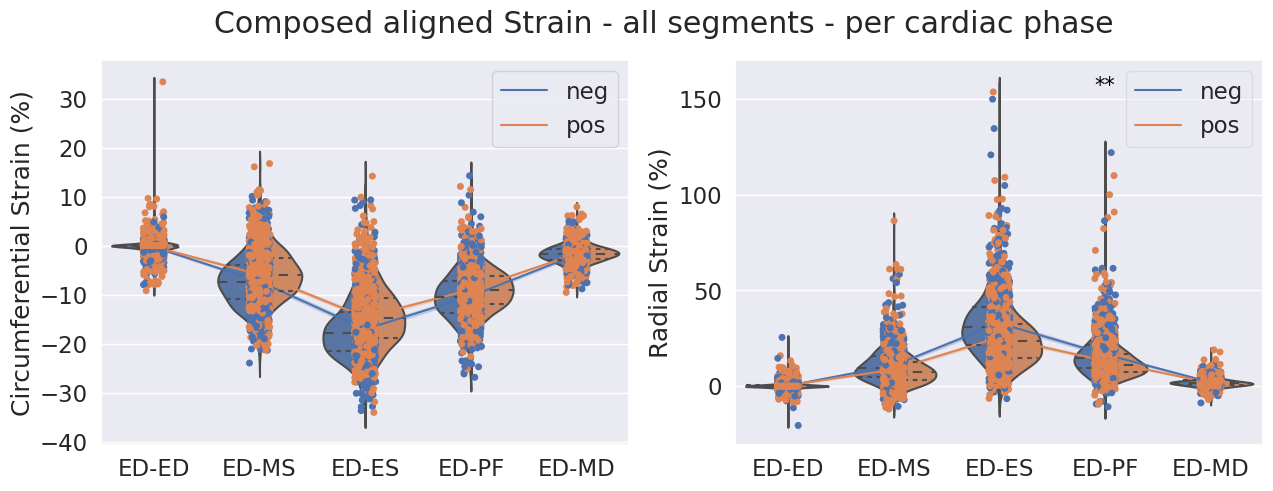

****************************************
RS strain in phase: ED-ES - significant AHA segments: [10], p-values: [0.00159]
aha  target
10   0         21.916959
     1         15.802750
Name: our_rs, dtype: float64


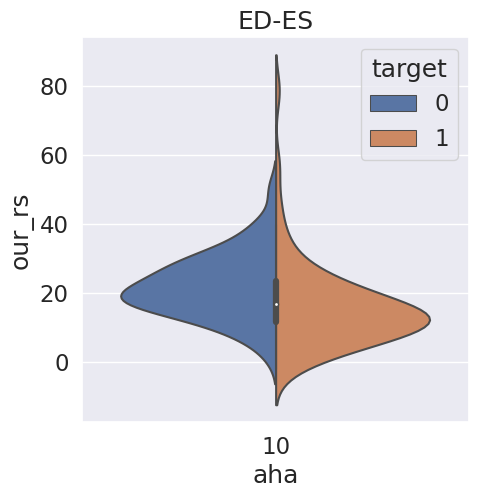

****************************************
CS strain in phase: ED-MS - significant AHA segments: [14], p-values: [0.03611]
aha  target
14   0        -5.829694
     1        -5.519737
Name: our_cs, dtype: float64


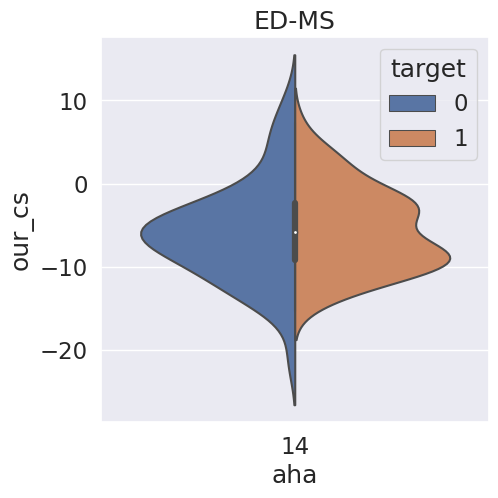

****************************************
CS strain in phase: ED-ES - significant AHA segments: [4, 10, 14], p-values: [0.04212, 0.0, 0.00159]
aha  target
4    0        -11.497939
     1        -11.917408
10   0        -13.127592
     1        -10.552763
14   0        -19.185347
     1        -17.279961
Name: our_cs, dtype: float64


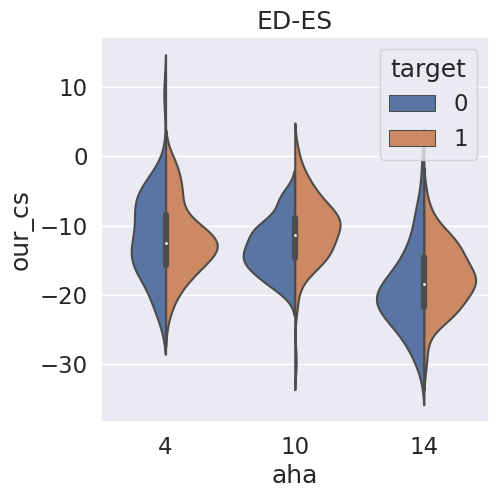

<Figure size 640x480 with 0 Axes>

In [313]:
# show the circle strain sliced by the predicted keyframes
from src.utils.Evaluation import plot_strain_per_time
target = 'target'
sig_niv = 0.05
_ = plot_strain_per_time(temp_key,title='Composed aligned Strain - all segments - per cardiac phase',method='comp', hue=target, sig_niv=sig_niv, scale=False); plt.show()

In [314]:
df_radial.pat.unique().shape, df_circ.pat.unique().shape

((125,), (125,))

In [13]:
# modify the dataframe structure to align with the dl based strain values - all frames
# filter rows with None
msk_r = ~df_radial_p.isin(['None', 'None ']).any(axis=1)
msk_c = ~df_circ_p.isin(['None', 'None ']).any(axis=1)
# make sure no none are left in the cleaned circle dataframe
assert ((~msk_r).sum() + (~msk_c).sum()) == 0, 'none in radial: {}, none in circ:{}'.format((~msk_r).sum(), (~msk_c).sum())
msk = (msk_r * msk_c).astype(bool)
df_radial_m = df_radial_p.loc[msk,:]
df_circ_m = df_circ_p.loc[msk,:]

# define the columns of interest - be carefull this is hardcoded for this specific dataset
cols = list(df_circ_p.columns[:33]) + list(df_circ_p.columns[-1:])

# melt rs and cs into a flat structure and concat both
temp_r = pd.melt(df_radial_m[cols], id_vars=['pat', 'aha', 'target', 'first_split'], var_name='frame', value_name='our_rs')
temp_c = pd.melt(df_circ_m[cols], id_vars=['pat', 'aha', 'target', 'first_split'], var_name='frame', value_name='our_cs')
temp = pd.concat([temp_r,temp_c['our_cs']],axis=1)

# minor column changes
temp = temp.rename(columns={'frame': 'phase'})
temp['our_cs'] = temp['our_cs'].astype(float)
temp['our_rs'] = temp['our_rs'].astype(float)
temp['target'] = temp['target'].replace({'N':0, 'Y':1})

temp

pat  aha  target  first_split phase  our_rs  our_cs
0      aea_20220314    1       0            0     0   0.867  -0.836
1      aea_20220314    2       0            0     0   1.206  -1.075
2      aea_20220314    3       0            0     0   1.425  -1.268
3      aea_20220314    4       0            0     0  -0.165   0.231
4      aea_20220314    5       0            0     0  -1.798   2.507
...             ...  ...     ...          ...   ...     ...     ...
59995  wr_201709050   12       1            1    29   3.880  -1.333
59996  wr_201709050   13       1            1    29   0.919  -1.808
59997  wr_201709050   14       1            1    29   1.293  -3.530
59998  wr_201709050   15       1            1    29   0.065  -0.500
59999  wr_201709050   16       1            1    29   0.068   3.019

[60000 rows x 7 columns]

# Circle strain all frames

(16, 10)


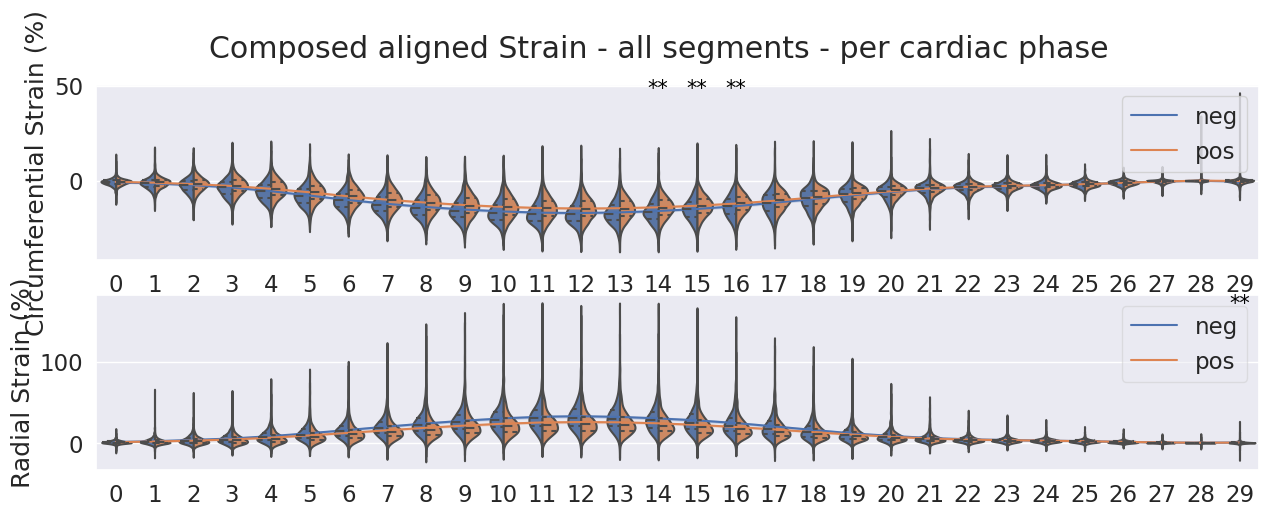

<Figure size 640x480 with 0 Axes>

In [316]:
from src.utils.Evaluation import plot_strain_per_time
target = 'target'
sig_niv = 0.05
_ = plot_strain_per_time(temp,title='Composed aligned Strain - all segments - per cardiac phase',method=None, hue=target, sig_niv=sig_niv, scale=False, vert=False); plt.show()

In [14]:
# load meta
path_to_df_meta = '/mnt/ssd2/data/dmd_circ_138/02_imported_4D_unfiltered/SAx_3D_dicomTags_phase.csv'
df_meta = pd.read_csv(path_to_df_meta)
df_meta = df_meta.loc[:, ~df_meta.columns.str.contains('^Unnamed')]
df_meta['patient'] = df_meta['patient'].str.lower().str.ljust(12, '0')
df_meta.head()

pat_x  ed_pred_early  ms_pred_early  \
0  0_AEA_20220314_volume_clean.nrrd\n           28.0            6.0   
1  0_AJA_20230331_volume_clean.nrrd\n           28.0            5.0   
2  0_AJS_20200519_volume_clean.nrrd\n           29.0            1.0   
3  0_BAJ_20210528_volume_clean.nrrd\n           29.0            5.0   
4   0_BA_20201019_volume_clean.nrrd\n           29.0            4.0   

   es_pred_early  pf_pred_early  md_pred_early         pat_y   age gender  \
0           12.0           18.0           26.0  aea_20220314  None   None   
1           12.0           18.0           25.0  aja_20230331  None   None   
2           10.0           19.0           21.0  ajs_20200519  None   None   
3           11.0           18.0           25.0  baj_20210528  None   None   
4            8.0           12.0           27.0   ba_20201019  None   None   

   weight  ...    bb   soa        lgepos target ed#  ms#  es#  pf#  md#  \
0    55.9  ...  None  None          None      N  29    6   11   19   25   
1    31.0  ...  None  None          5,11      Y  29    5   11   18   25   
2    41.2  ...  None  None  5,6,11,13,16      Y  29    4   10   22   25   
3    34.0  ...  None  None         11,12      Y   0    5   11   18   25   
4    64.5  ...  None  None          None      N  29    4    8   12   27   

        patient  
0  aea_20220314  
1  aja_20230331  
2  ajs_20200519  
3  baj_20210528  
4  ba_202010190  

[5 rows x 45 columns]

In [15]:
len(df_meta.patient.unique())

139

In [16]:
df_meta.columns

Index(['pat_x', 'ed_pred_early', 'ms_pred_early', 'es_pred_early',
       'pf_pred_early', 'md_pred_early', 'pat_y', 'age', 'gender', 'weight',
       'height', 'bsa', 'hr', 'systolic bp', 'diastolic bp', 'lvef', 'lvedv',
       'lvesv', 'lv mass', 'rvef', 'rvedv', 'rvesv', 'reduced ef', 'lgepos_eq',
       'lgepos_', 'lge present', 'nocturnal bipap use',
       'resp support required', 'wheelchair', 'ambulatory', 'steroid use',
       'any med use', 'ace-i', 'arb', 'mra', 'bb', 'soa', 'lgepos', 'target',
       'ed#', 'ms#', 'es#', 'pf#', 'md#', 'patient'],
      dtype='object')

In [18]:
df_merged = pd.merge(left=df_melt, right=df_meta, how='inner', left_on='pat', right_on='patient')
df_merged['target'] = df_merged['lge present']
df_merged['pat'] = df_merged['pat_x']
print(len(df_merged.pat.unique()))
df_merged.head()

125


pat  aha frame  radial_strain  circ_strain  \
0  0_AEA_20220314_volume_clean.nrrd\n    1     0          0.867       -0.836   
1  0_AEA_20220314_volume_clean.nrrd\n    2     0          1.206       -1.075   
2  0_AEA_20220314_volume_clean.nrrd\n    3     0          1.425       -1.268   
3  0_AEA_20220314_volume_clean.nrrd\n    4     0         -0.165        0.231   
4  0_AEA_20220314_volume_clean.nrrd\n    5     0         -1.798        2.507   

                                pat_x  ed_pred_early  ms_pred_early  \
0  0_AEA_20220314_volume_clean.nrrd\n           28.0            6.0   
1  0_AEA_20220314_volume_clean.nrrd\n           28.0            6.0   
2  0_AEA_20220314_volume_clean.nrrd\n           28.0            6.0   
3  0_AEA_20220314_volume_clean.nrrd\n           28.0            6.0   
4  0_AEA_20220314_volume_clean.nrrd\n           28.0            6.0   

   es_pred_early  pf_pred_early  ...    bb   soa lgepos target  ed#  ms# es#  \
0           12.0           18.0  ...  None  None   None      N   29    6  11   
1           12.0           18.0  ...  None  None   None      N   29    6  11   
2           12.0           18.0  ...  None  None   None      N   29    6  11   
3           12.0           18.0  ...  None  None   None      N   29    6  11   
4           12.0           18.0  ...  None  None   None      N   29    6  11   

  pf# md#       patient  
0  19  25  aea_20220314  
1  19  25  aea_20220314  
2  19  25  aea_20220314  
3  19  25  aea_20220314  
4  19  25  aea_20220314  

[5 rows x 50 columns]

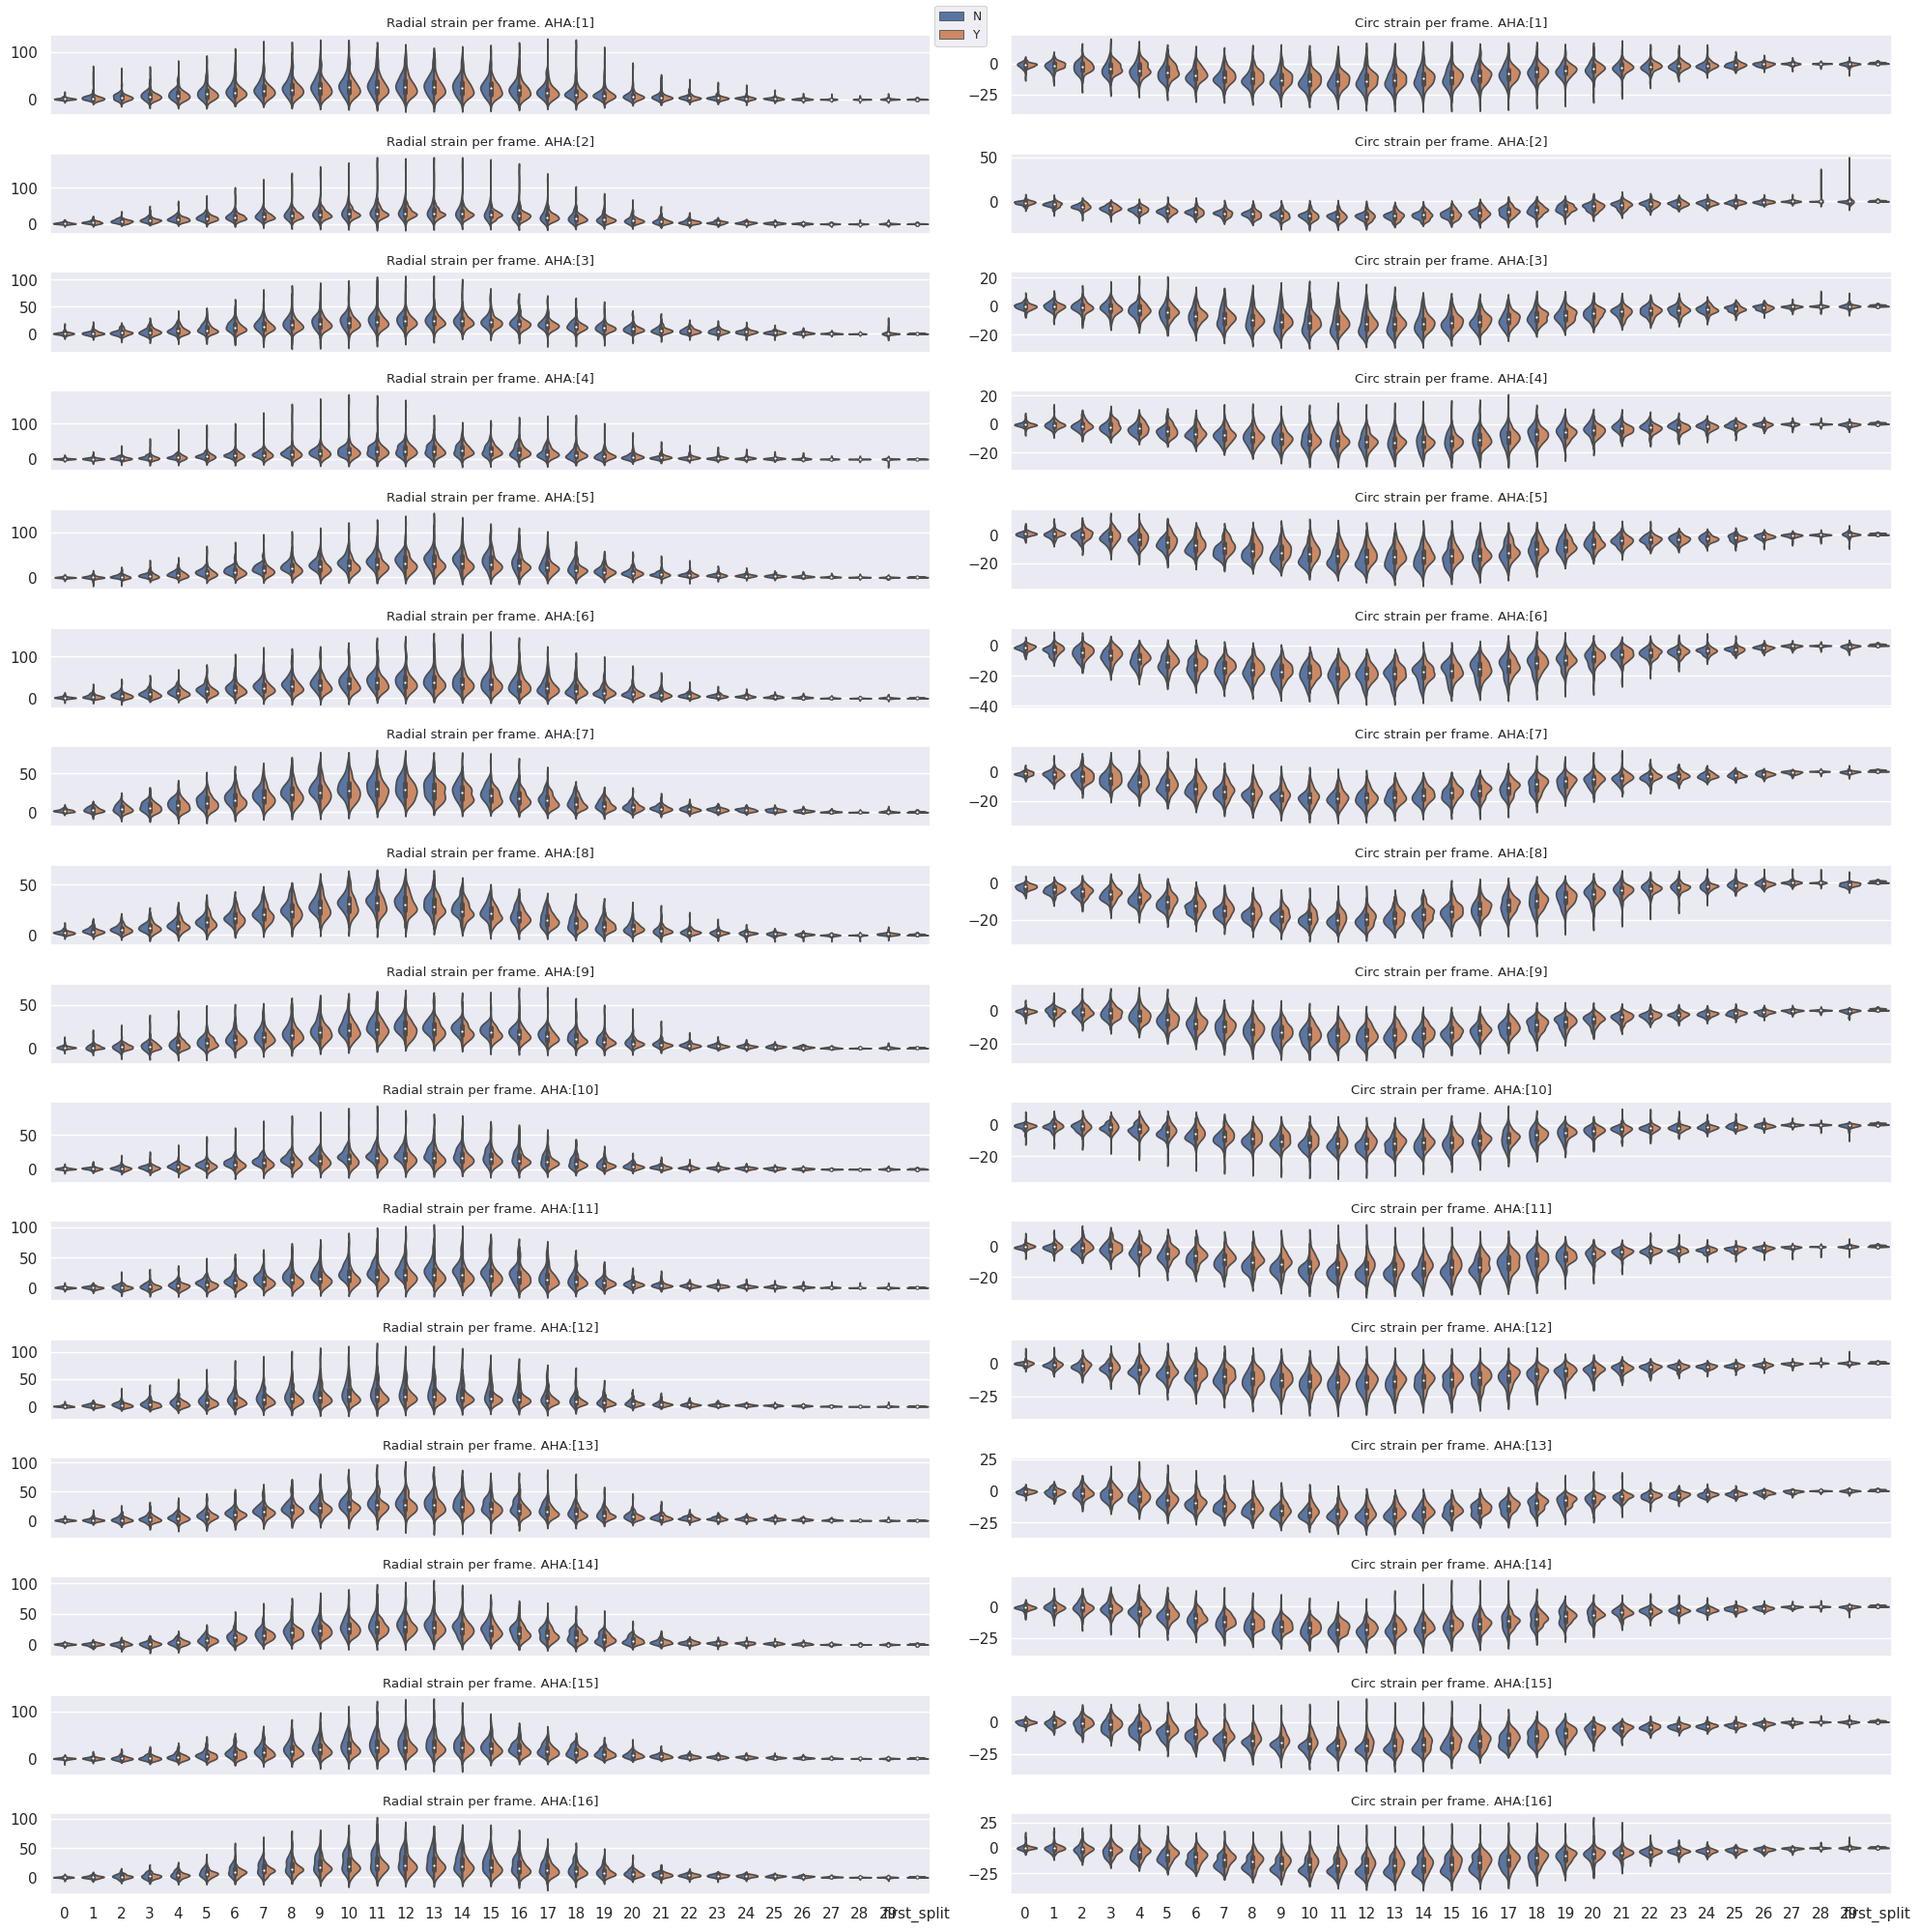

In [321]:
def plot_strain(df, segments=[1], ax=None, ax1=None, show_xlabel=False):
    sb.set_context('paper')
    #sb.set(font_scale = 1.5)
    if ax is None:
        fig, (ax, ax1) = plt.subplots(1,2,figsize=(20,4))
    ax.set_title('Radial strain per frame. AHA:{}'.format(segments))
    ax1.set_title('Circ strain per frame. AHA:{}'.format(segments))
    g1 = sb.violinplot(x="frame", y='radial_strain',
                     data=df[df['aha'].isin(segments)],
                  ax=ax,
                 hue='target',
                 split=True, legend=False)
    g2 = sb.violinplot(x="frame", y='circ_strain',
                     data=df[df['aha'].isin(segments)],
                  ax=ax1,
                 hue='target',
                 split=True)
    
    if show_xlabel:
        pass
    else:
        g1.set(ylabel=None)
        g2.set(ylabel=None)
        g1.set(xlabel=None)
        g2.set(xlabel=None)
        g1.legend([],[],frameon=False)
        g2.legend([],[],frameon=False)
        #g2.set(xticklabels=[])
        #g1.set(xticklabels=[])
    
    
seg_of_interest = 16
sb.set_context('paper')
sb.set(font_scale = 1)
fig, axes = plt.subplots(seg_of_interest,2,figsize=(20,20), sharex=True)
_ = [plot_strain(df_merged, segments=[i], ax=axes[i-1,0], ax1=axes[i-1,1], show_xlabel=i==seg_of_interest+1) for i in range(1,1 + seg_of_interest)]
handles, labels = axes[0,0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center')
plt.tight_layout()
plt.savefig('/mnt/ssd2/jcmr2023/circle/strain138@frame_per_segment.png')
plt.show()

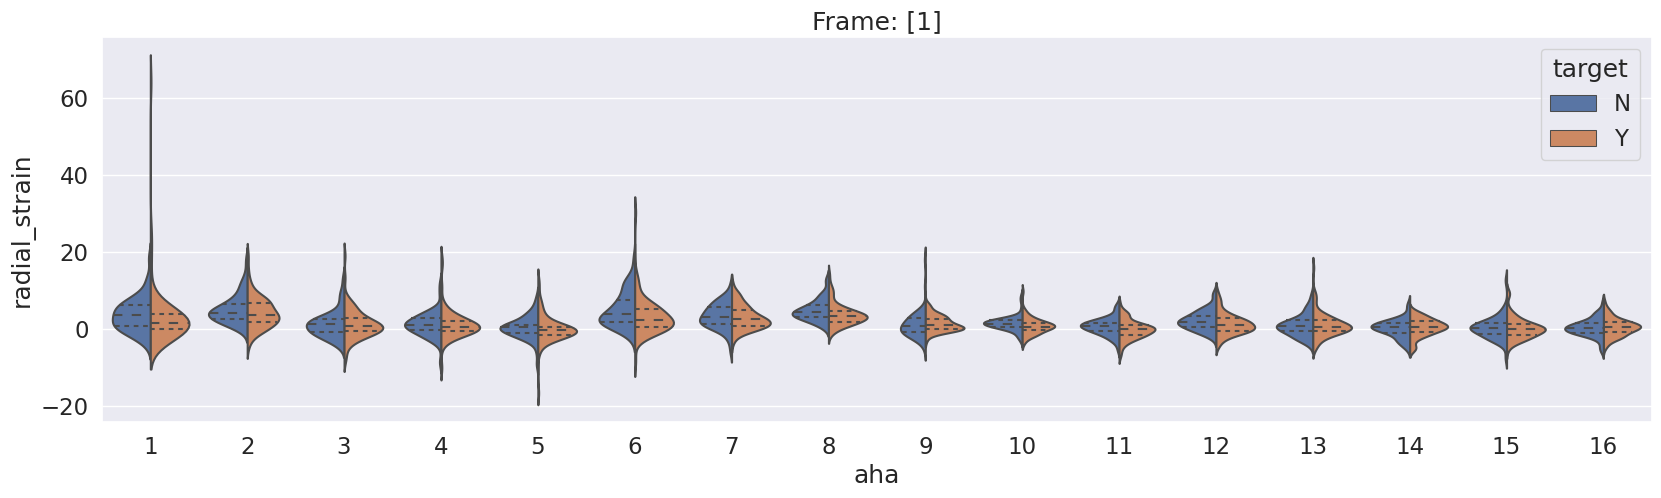

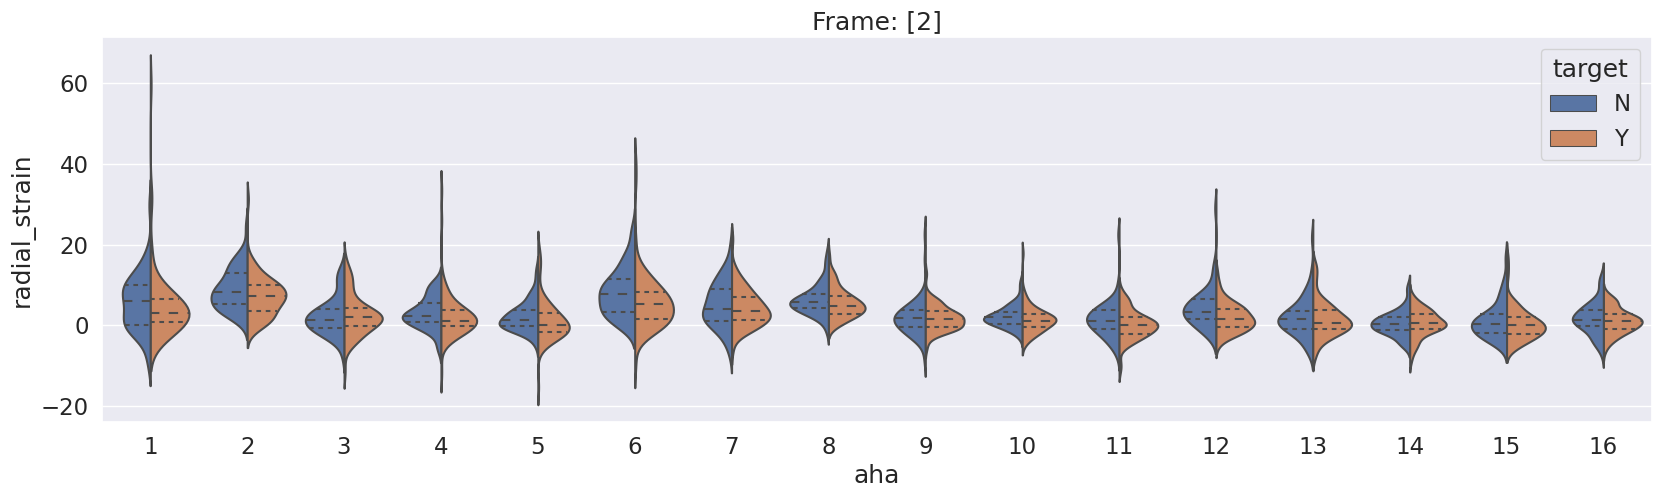

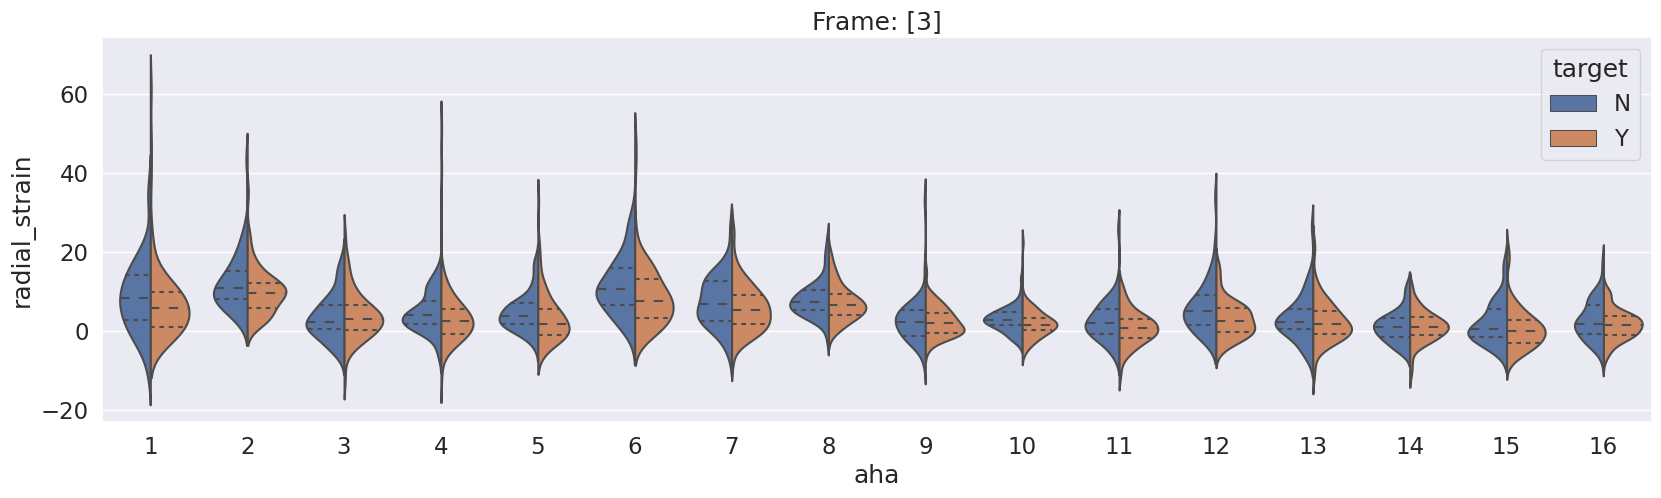

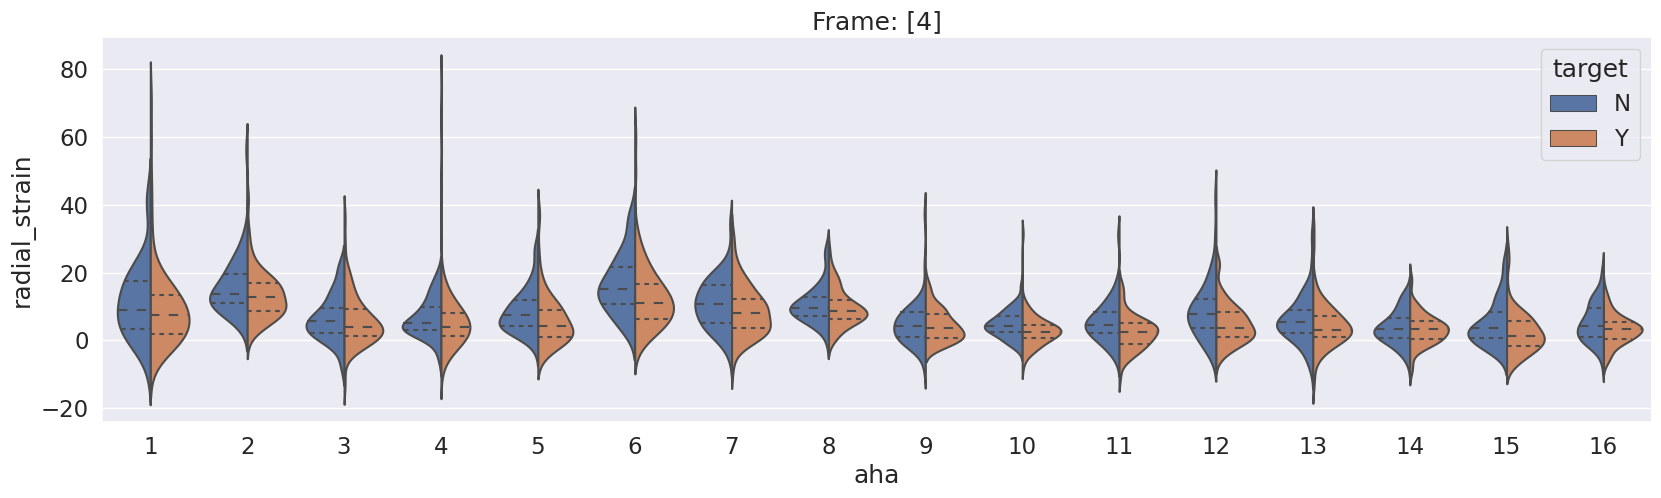

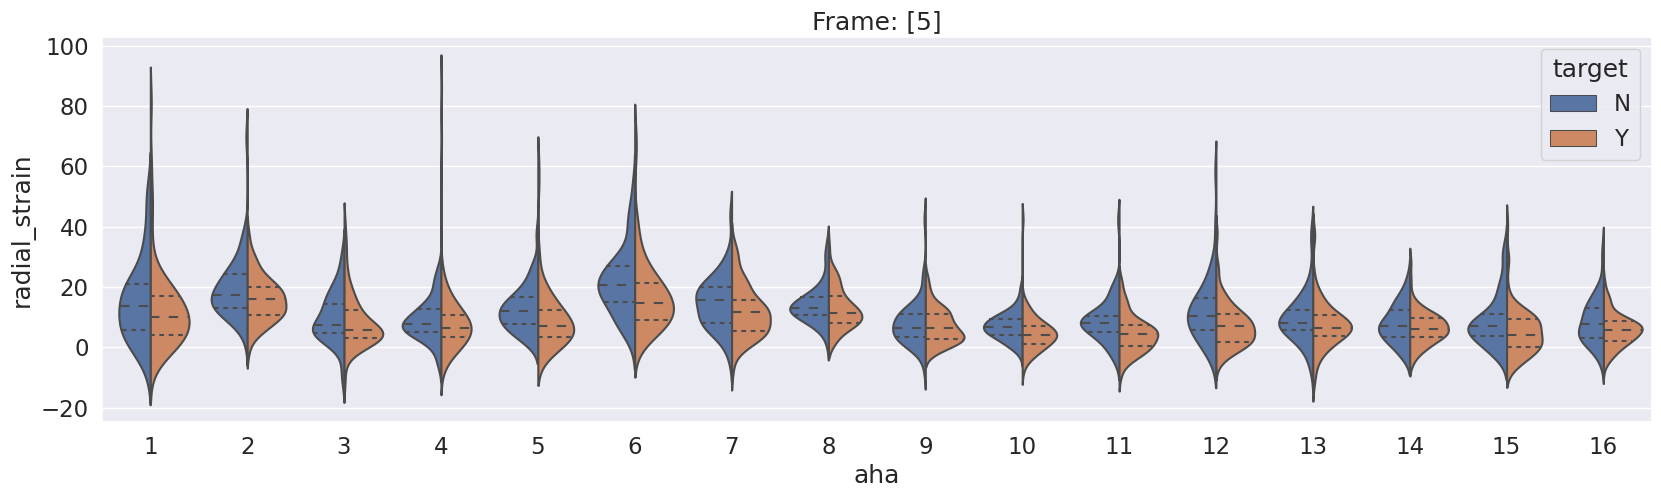

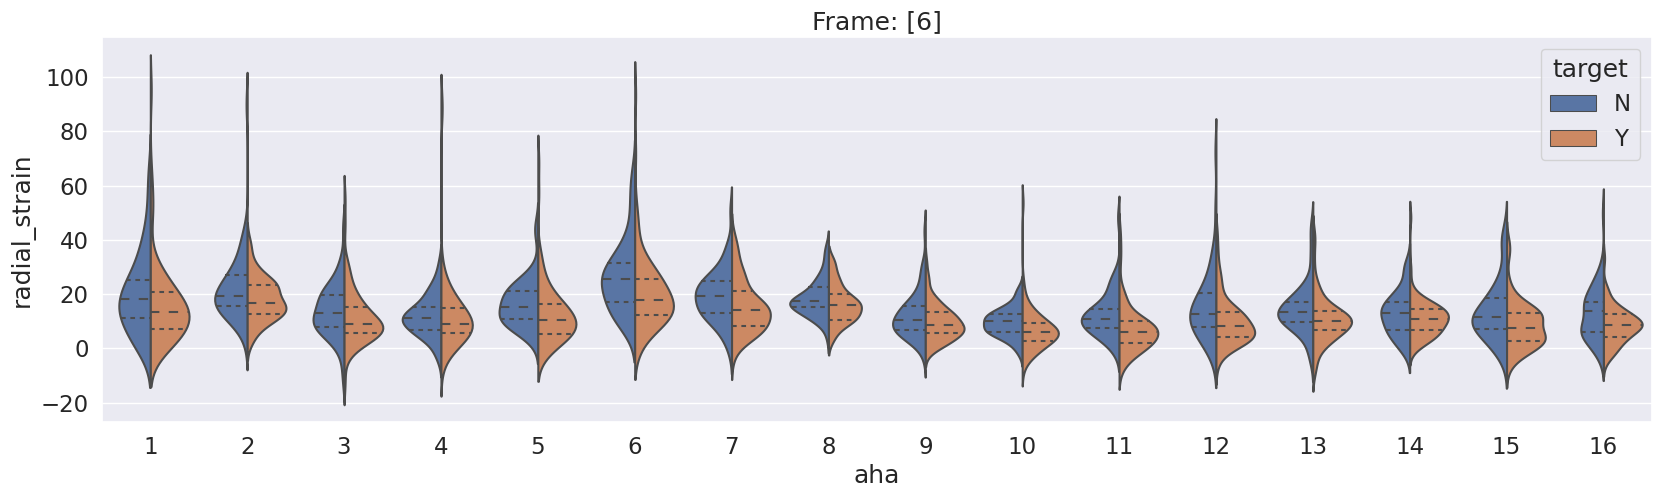

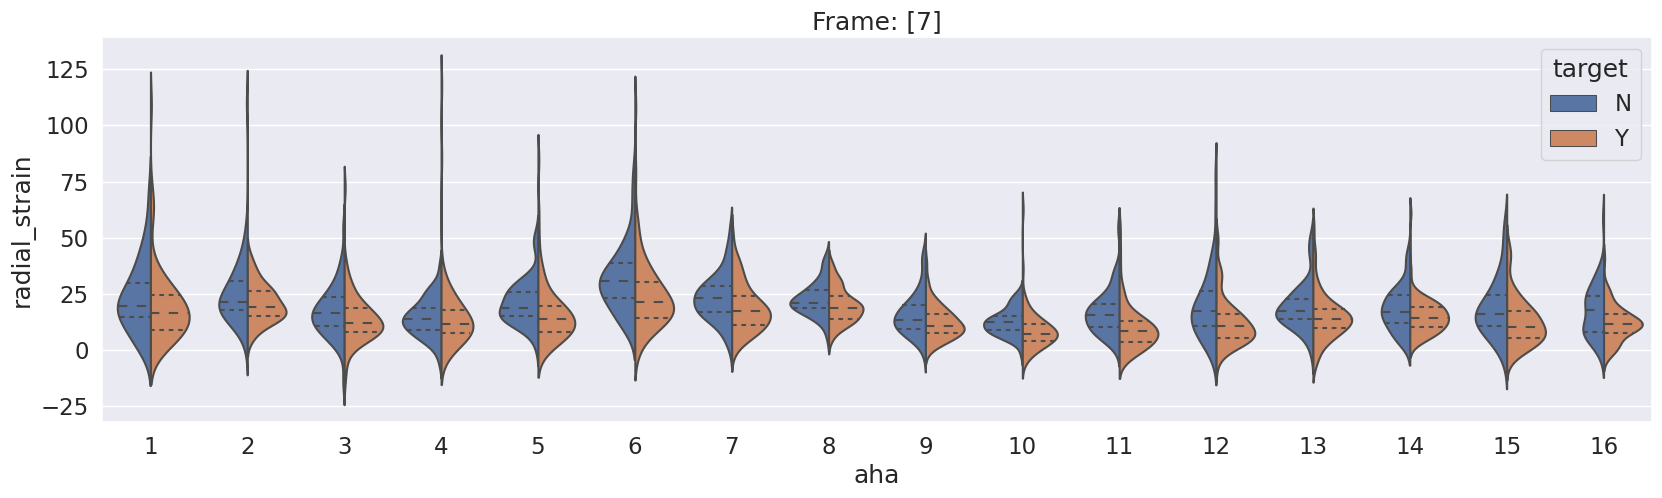

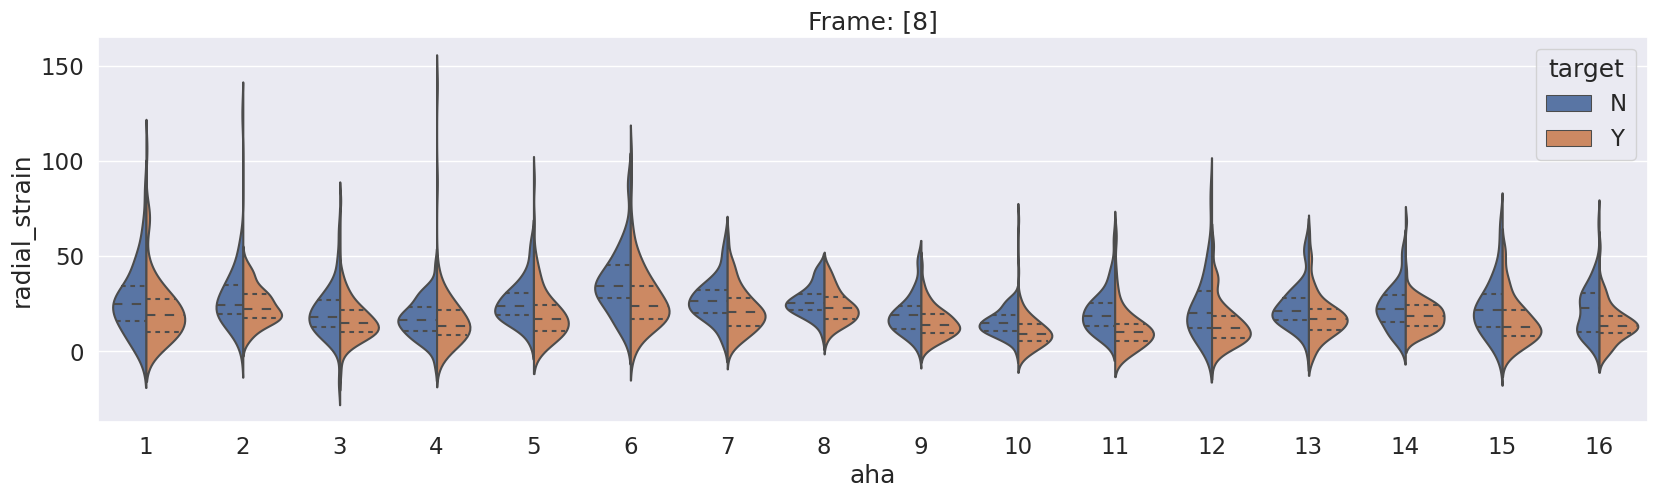

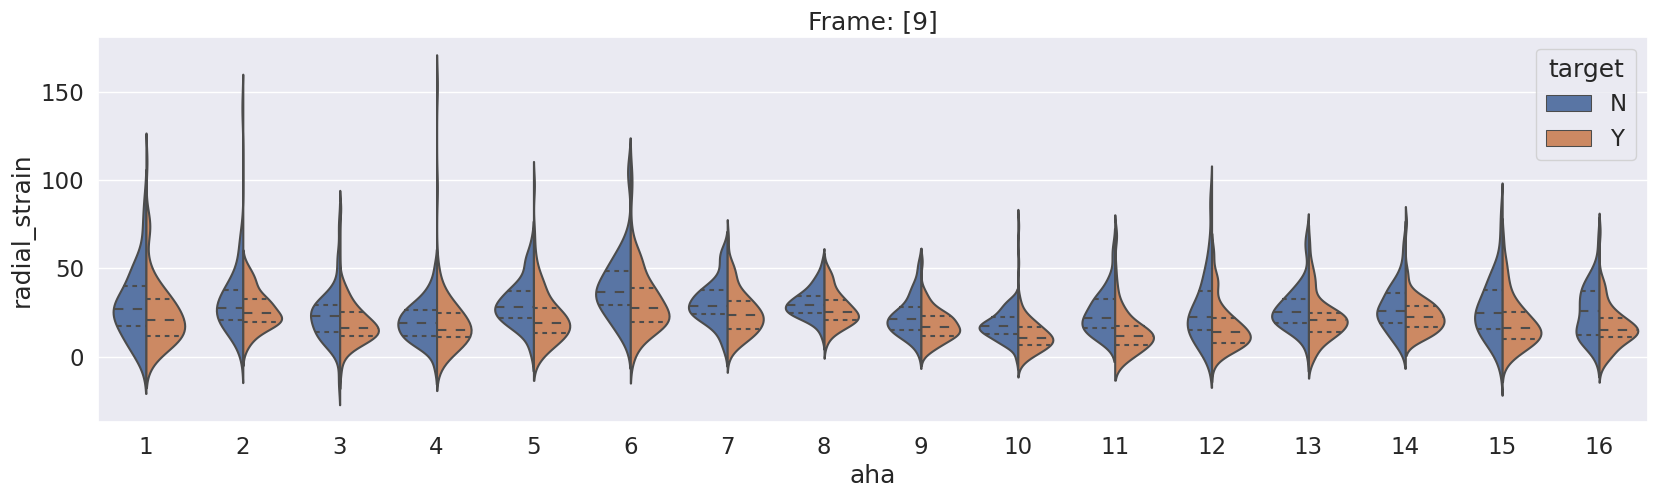

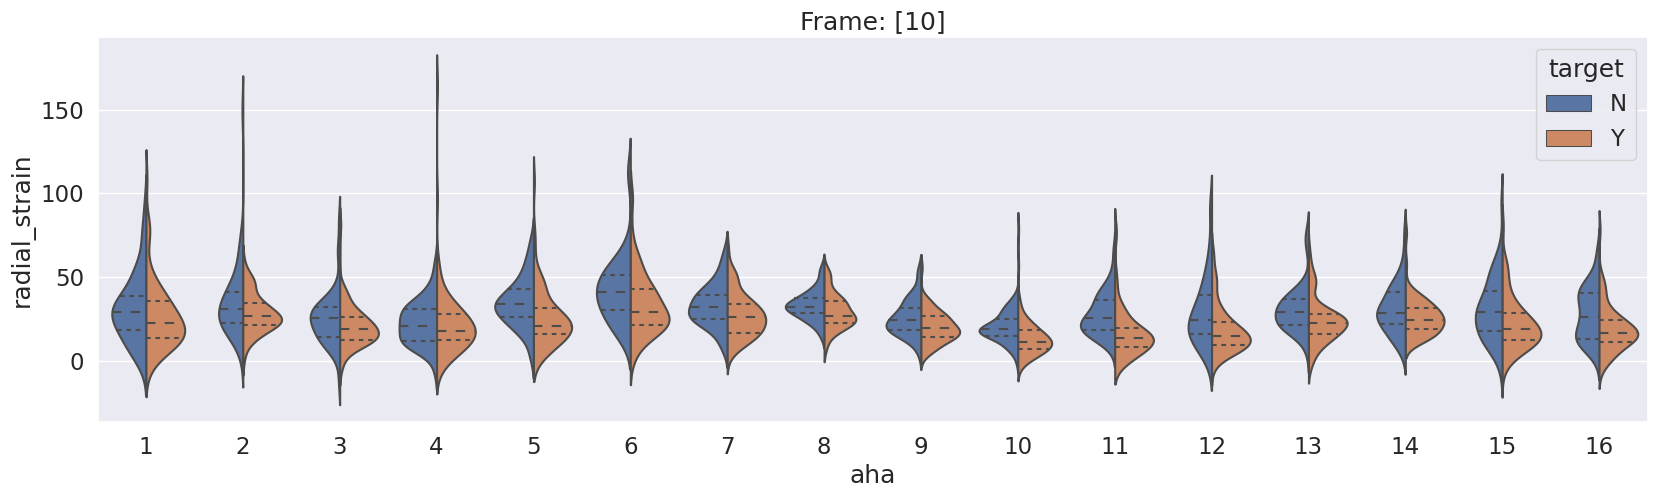

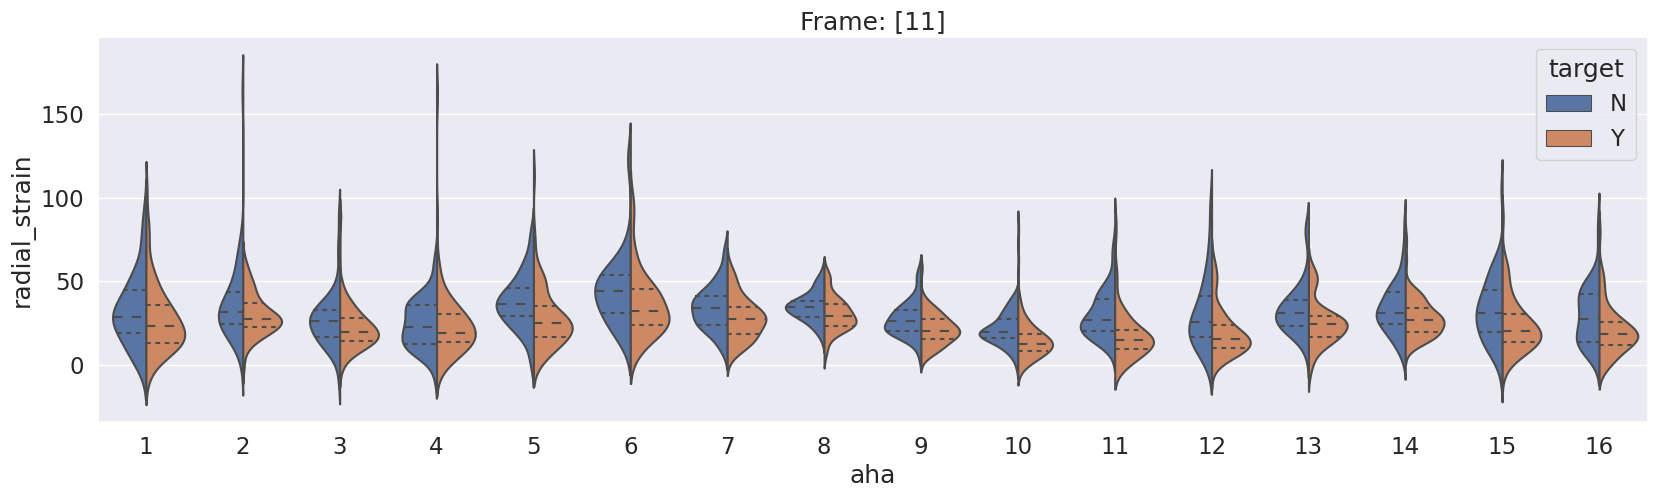

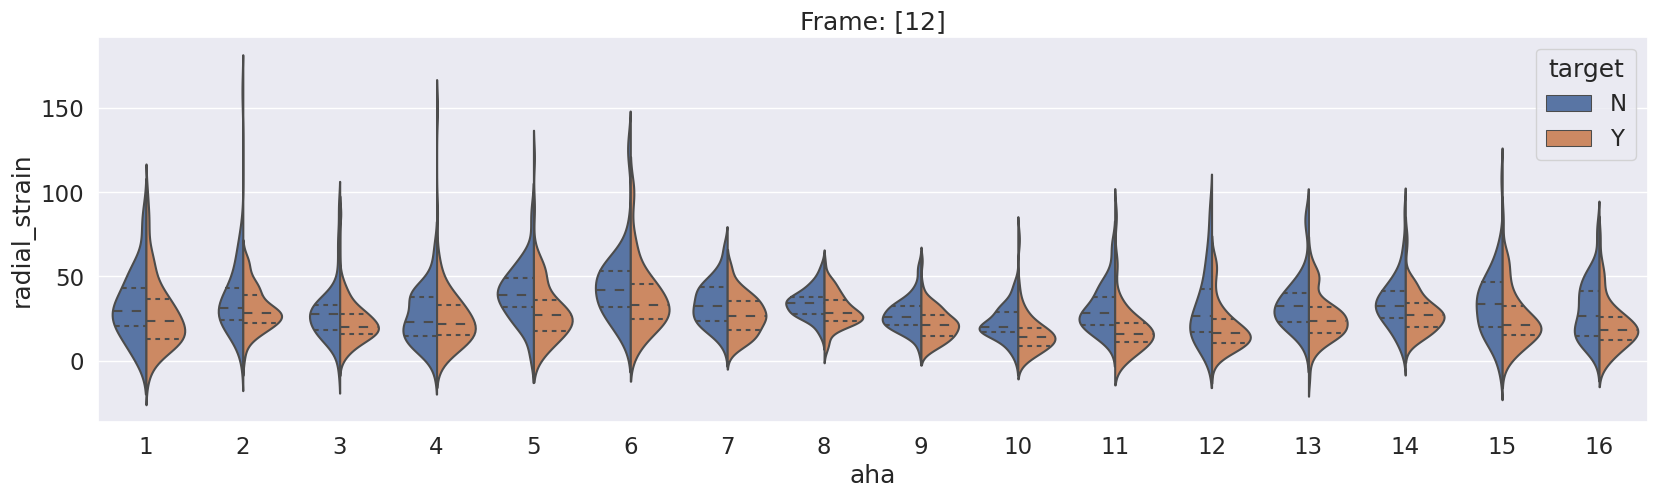

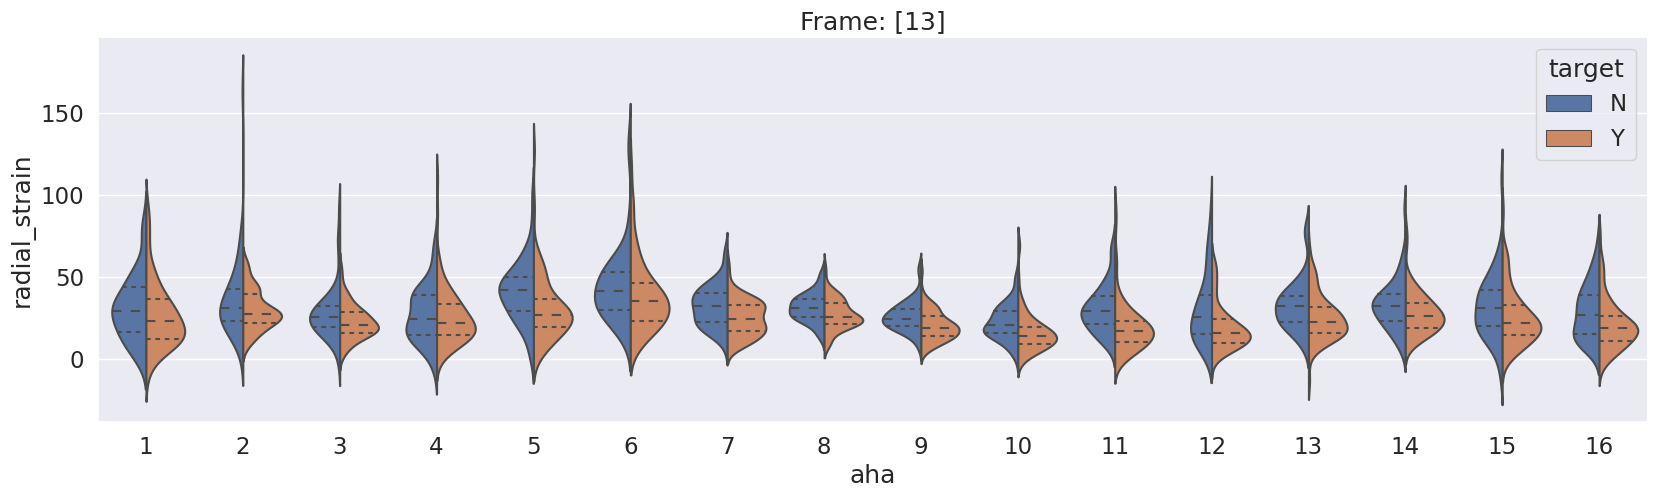

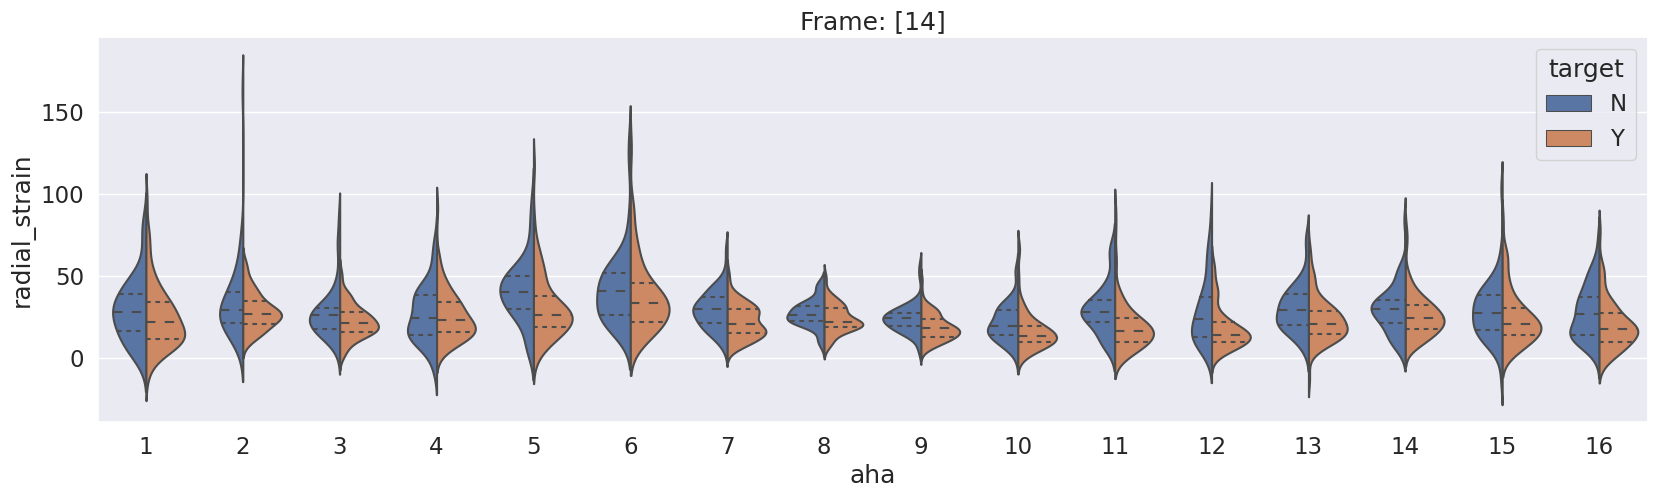

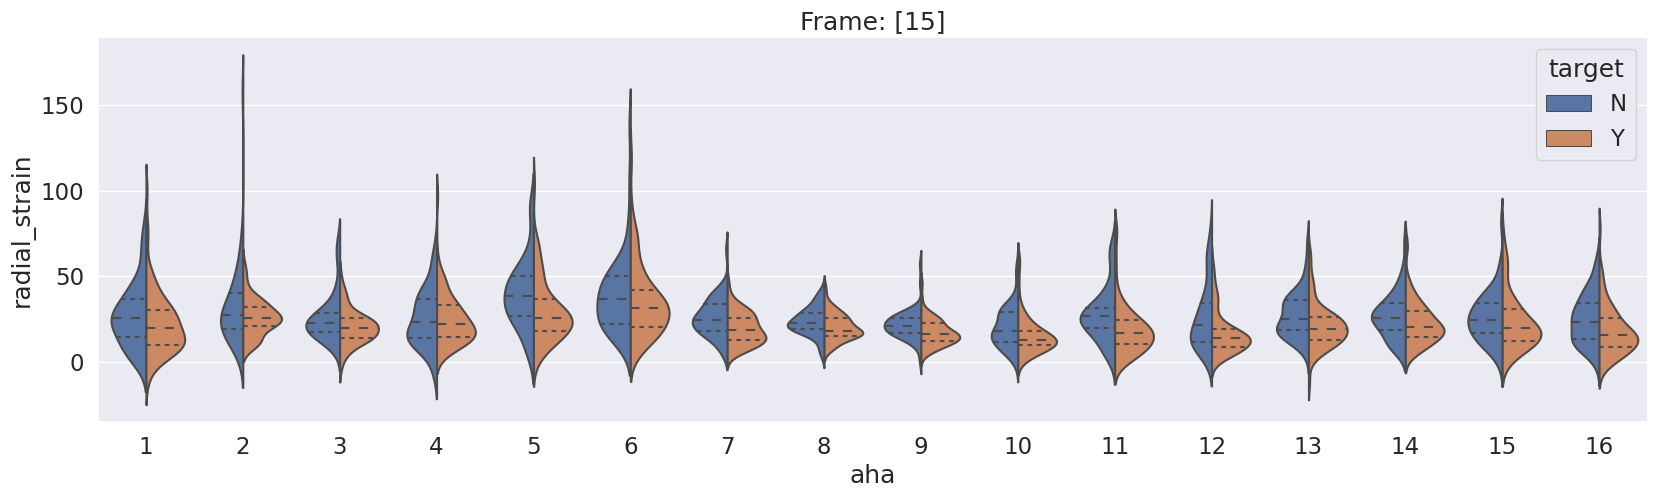

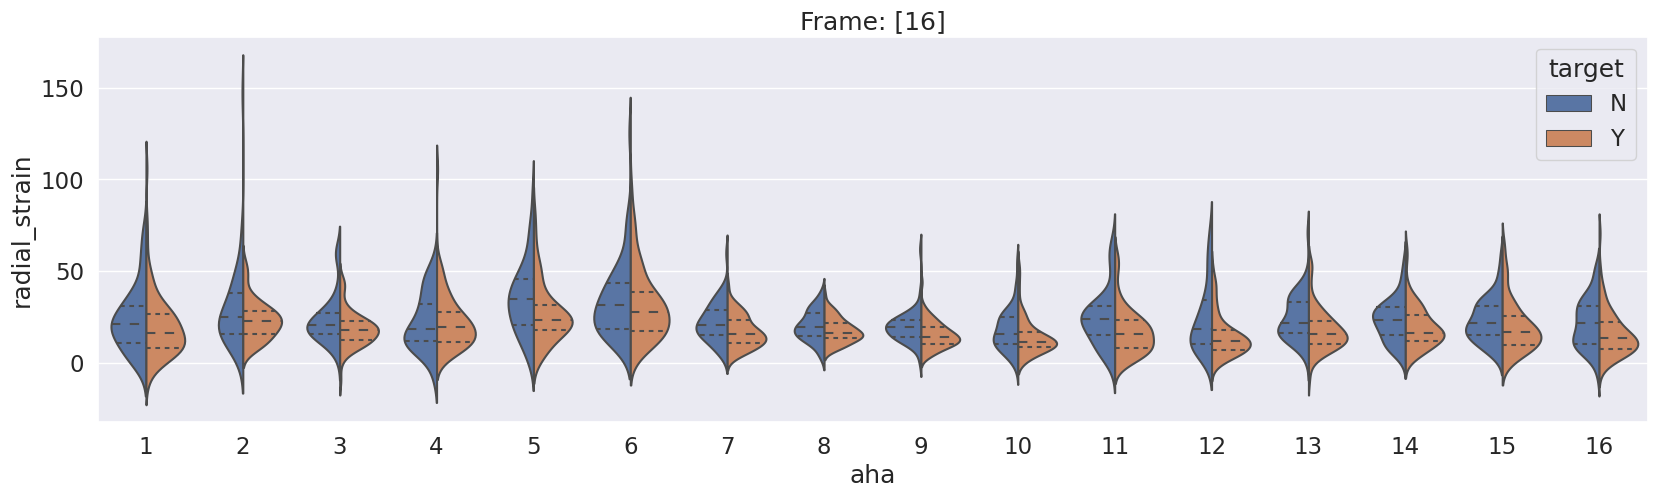

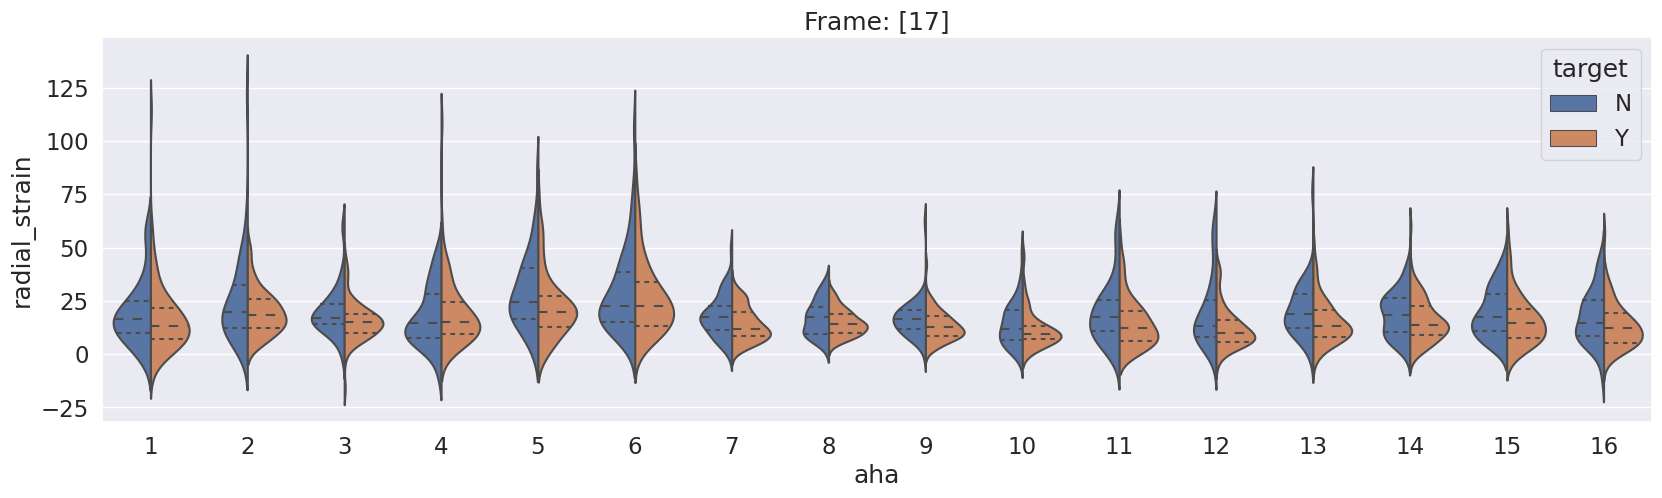

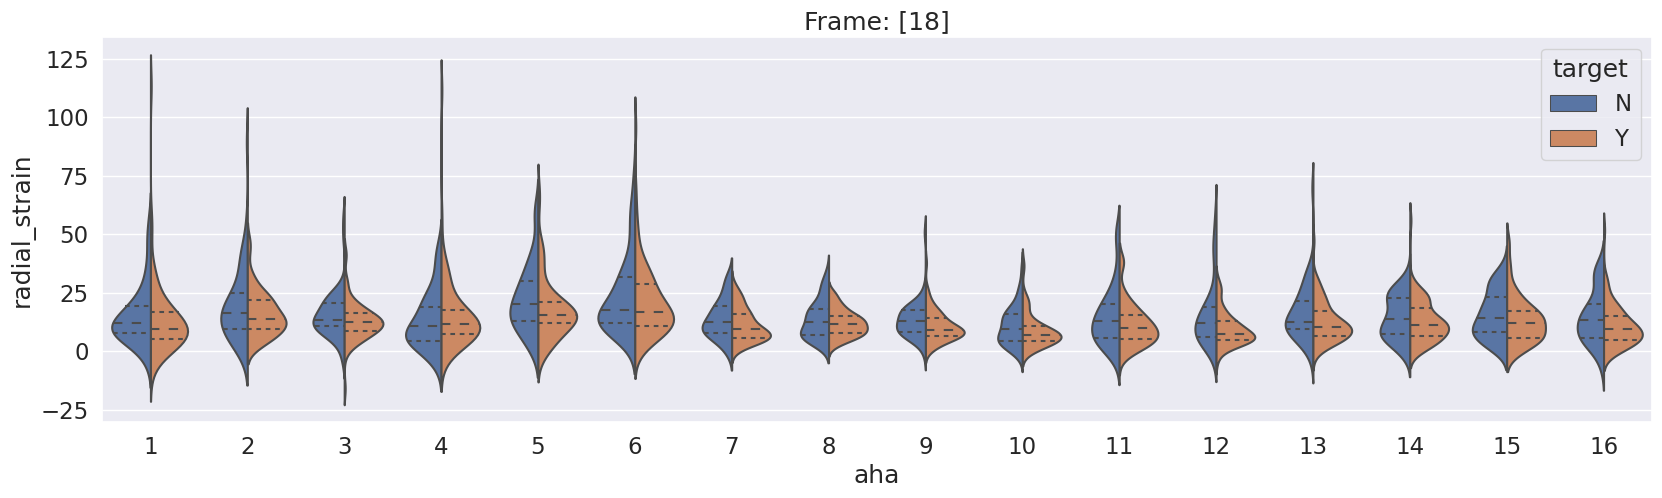

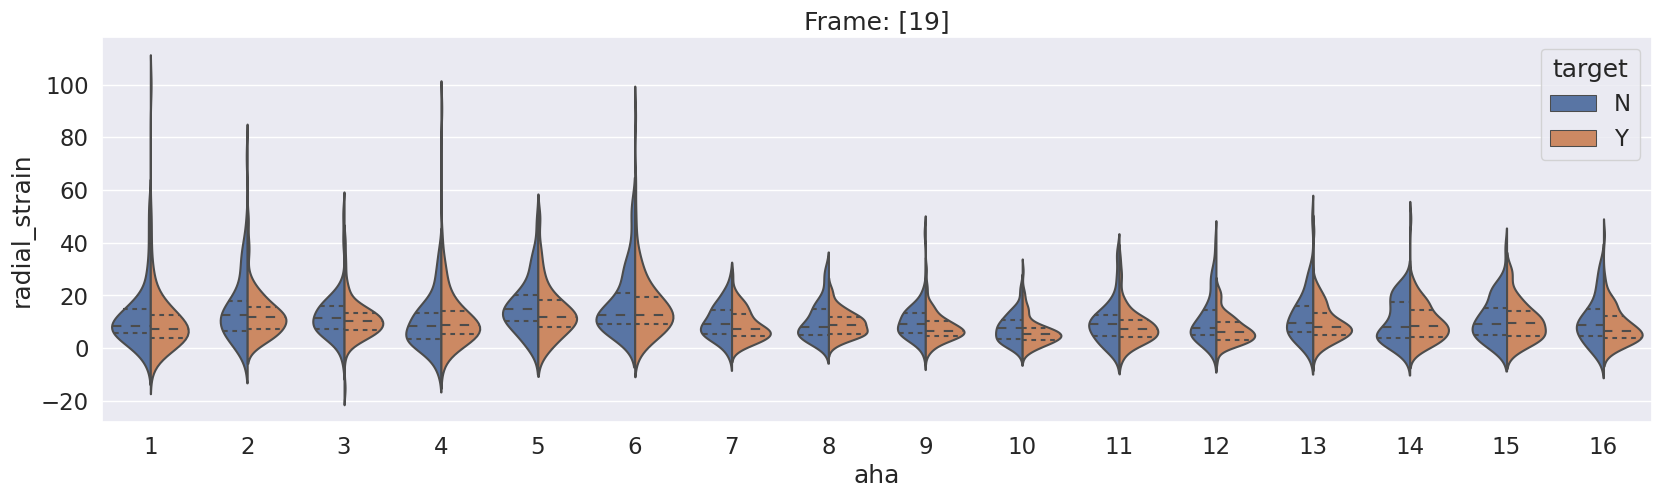

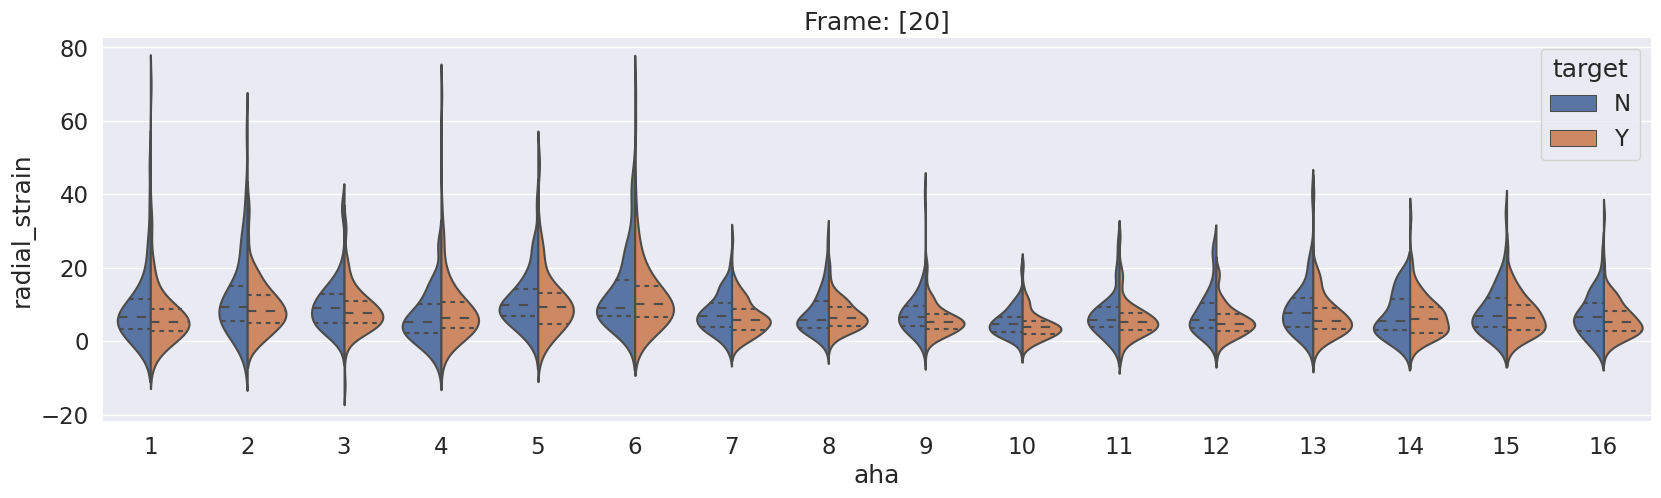

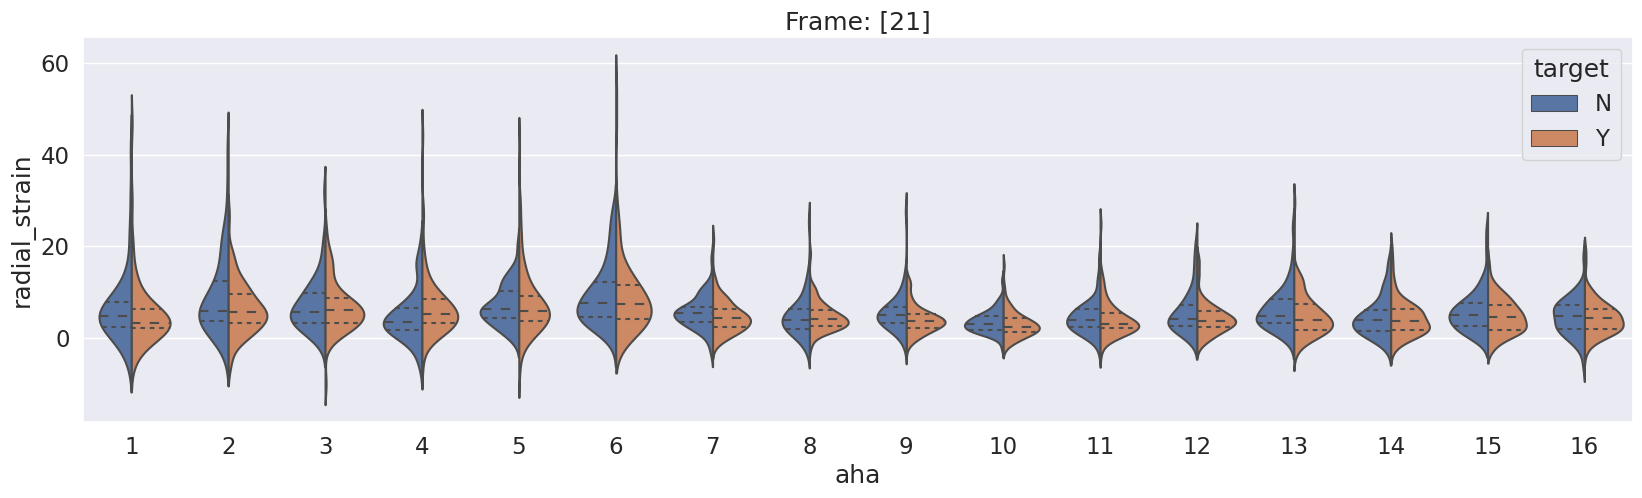

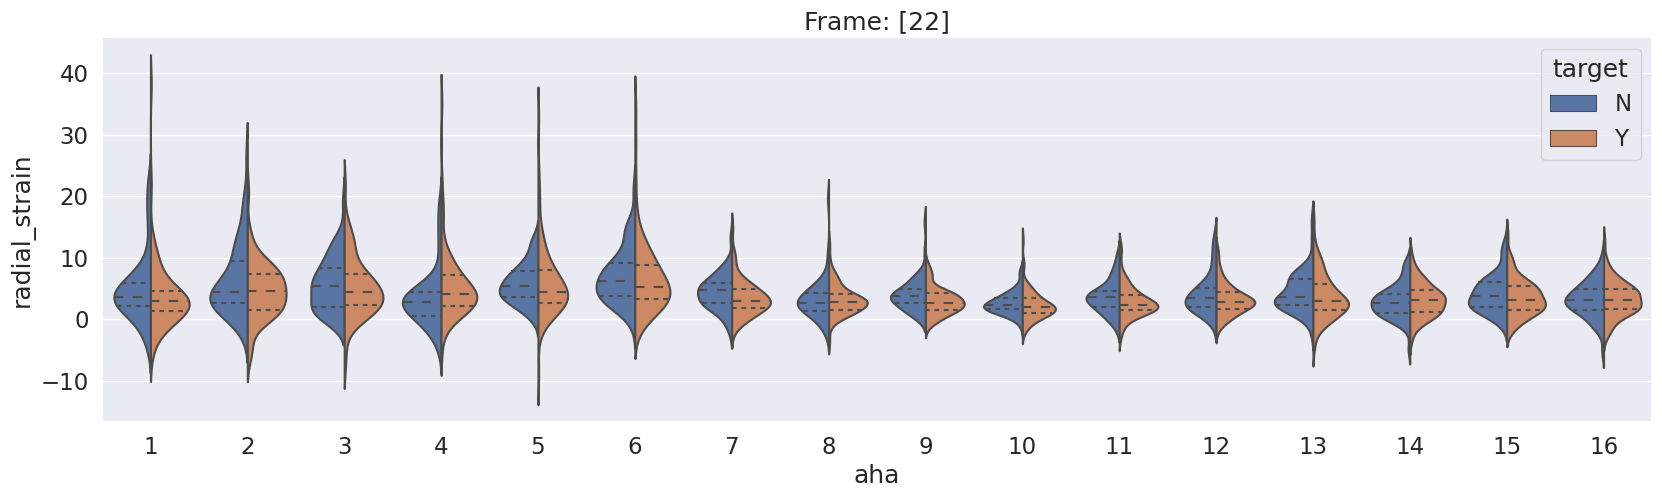

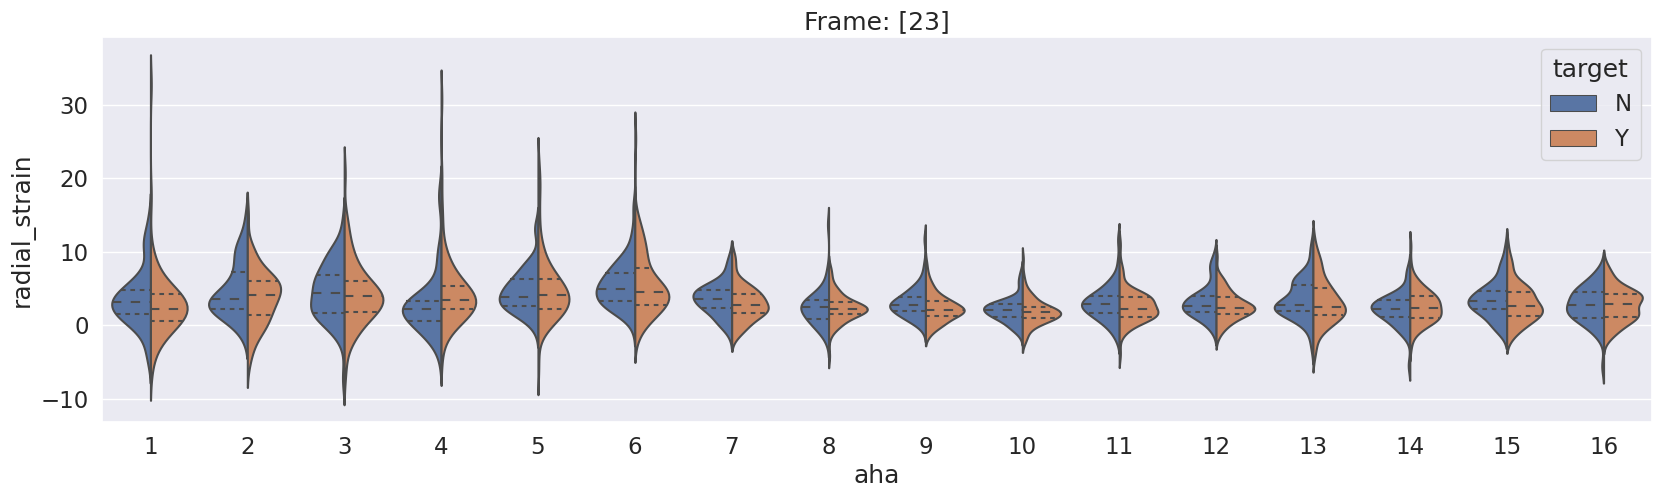

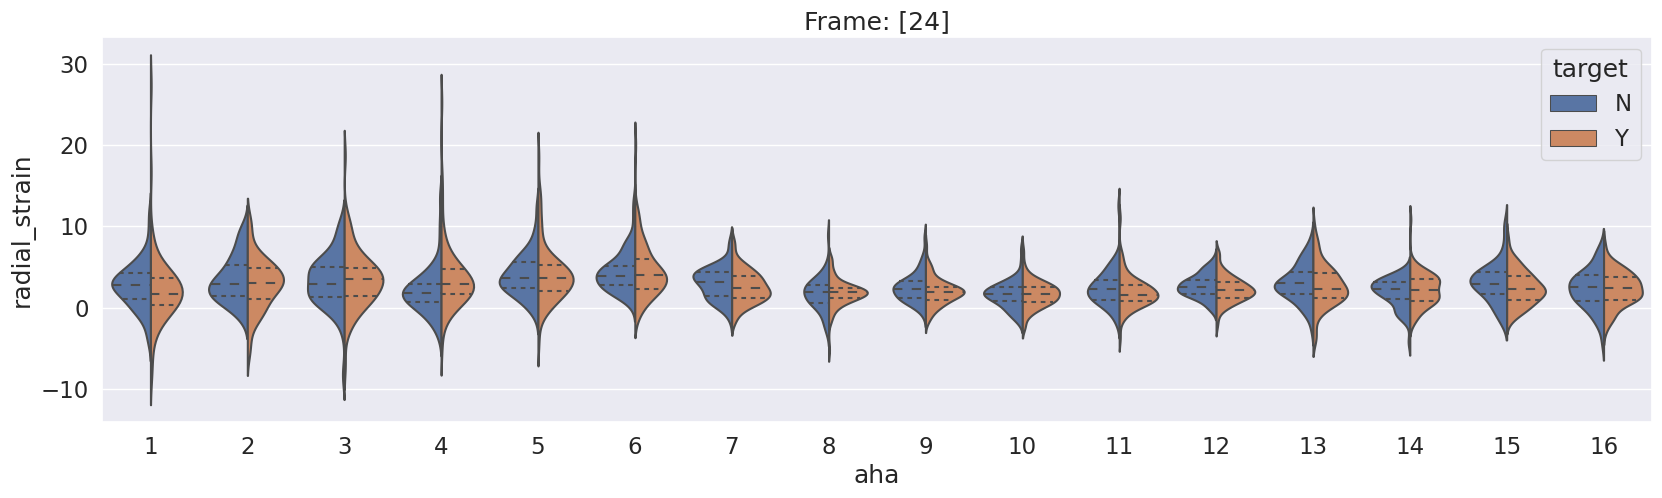

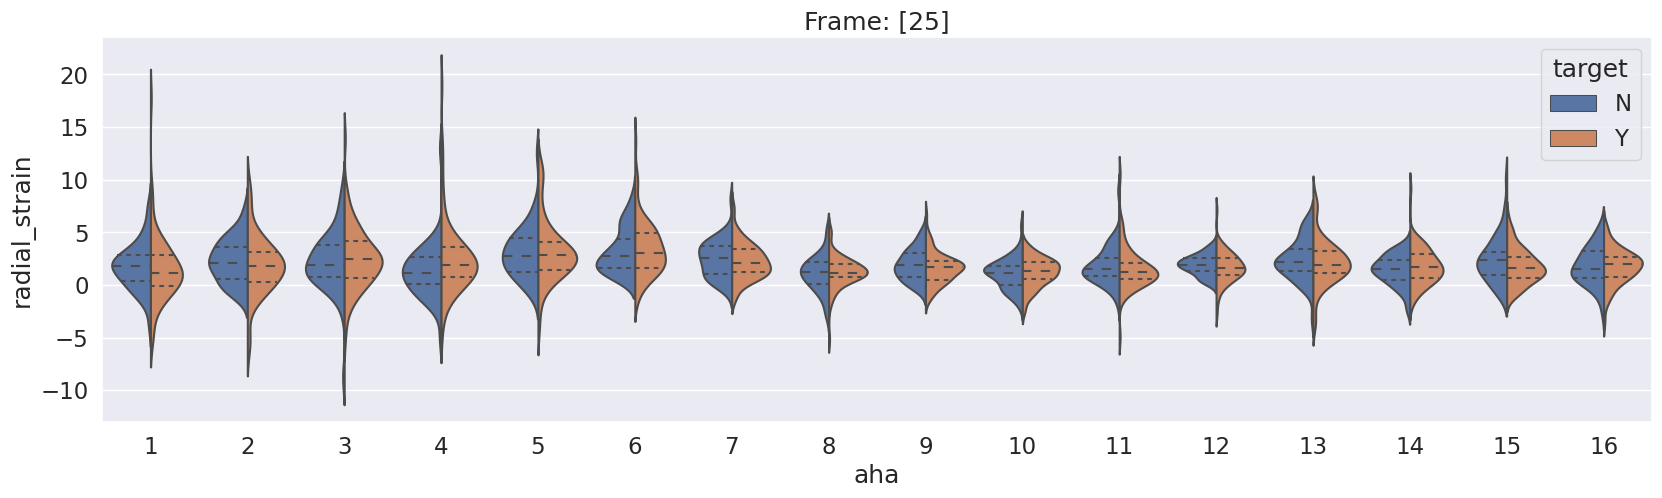

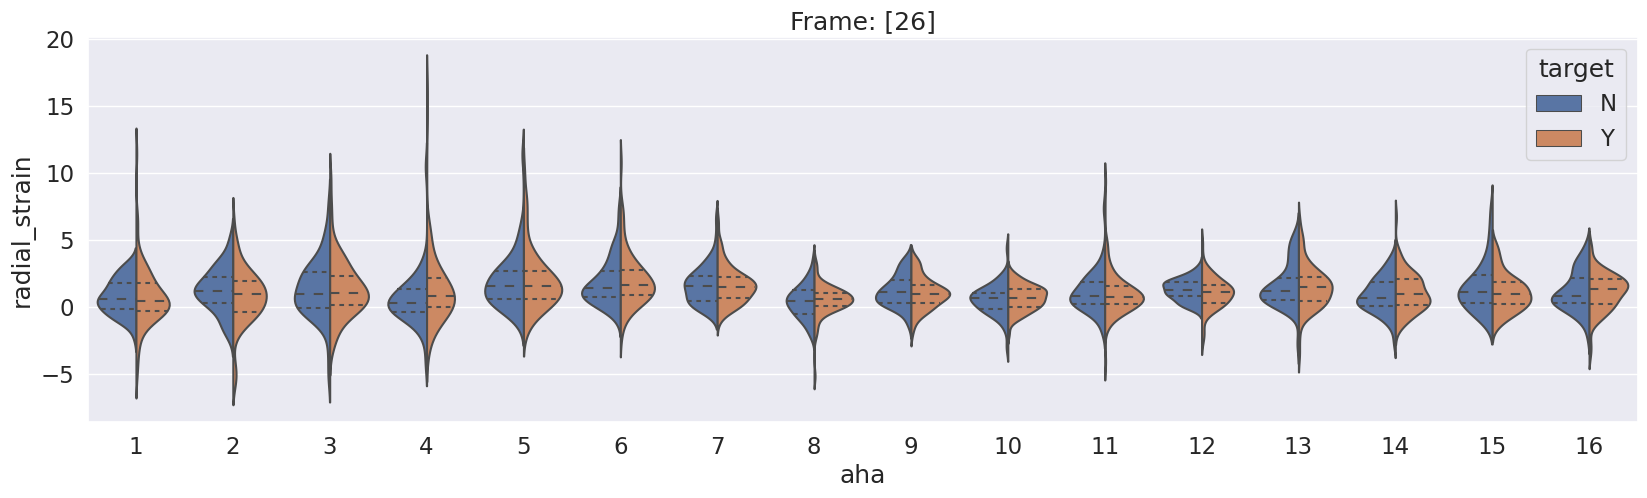

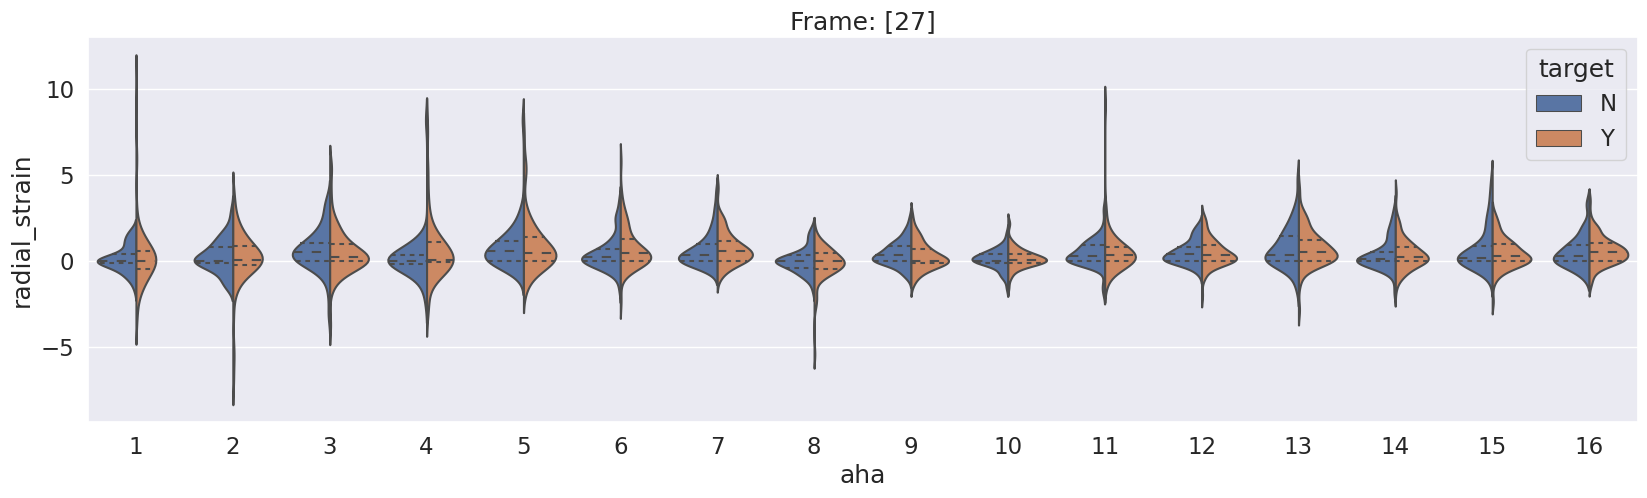

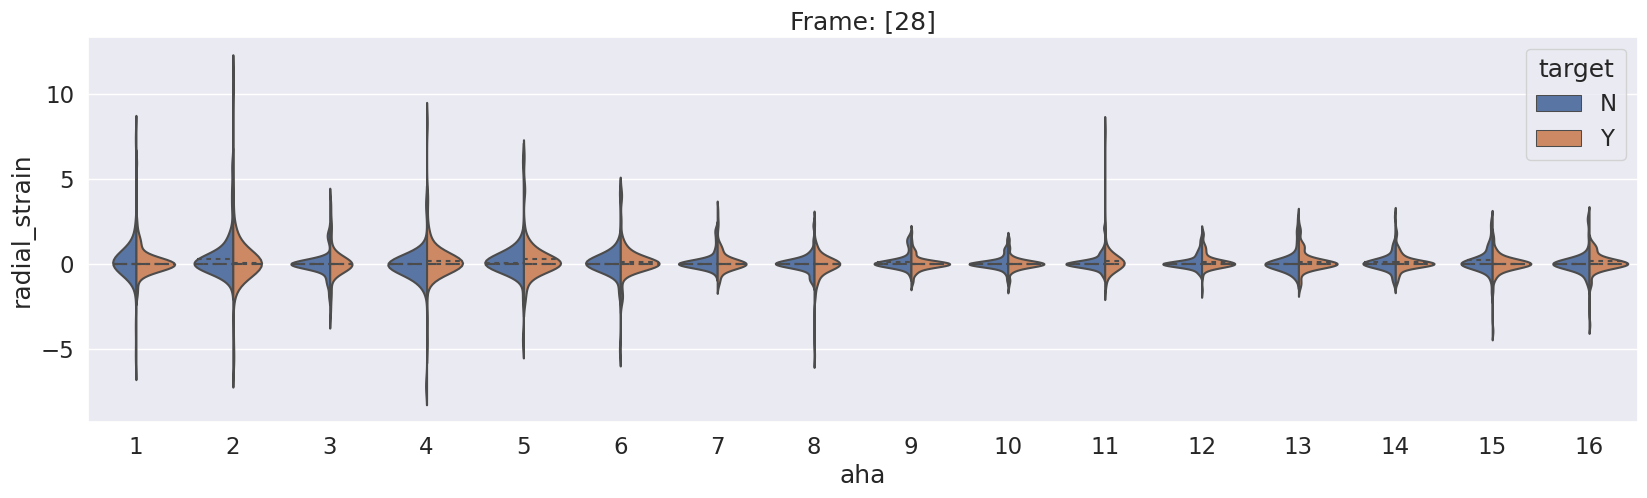

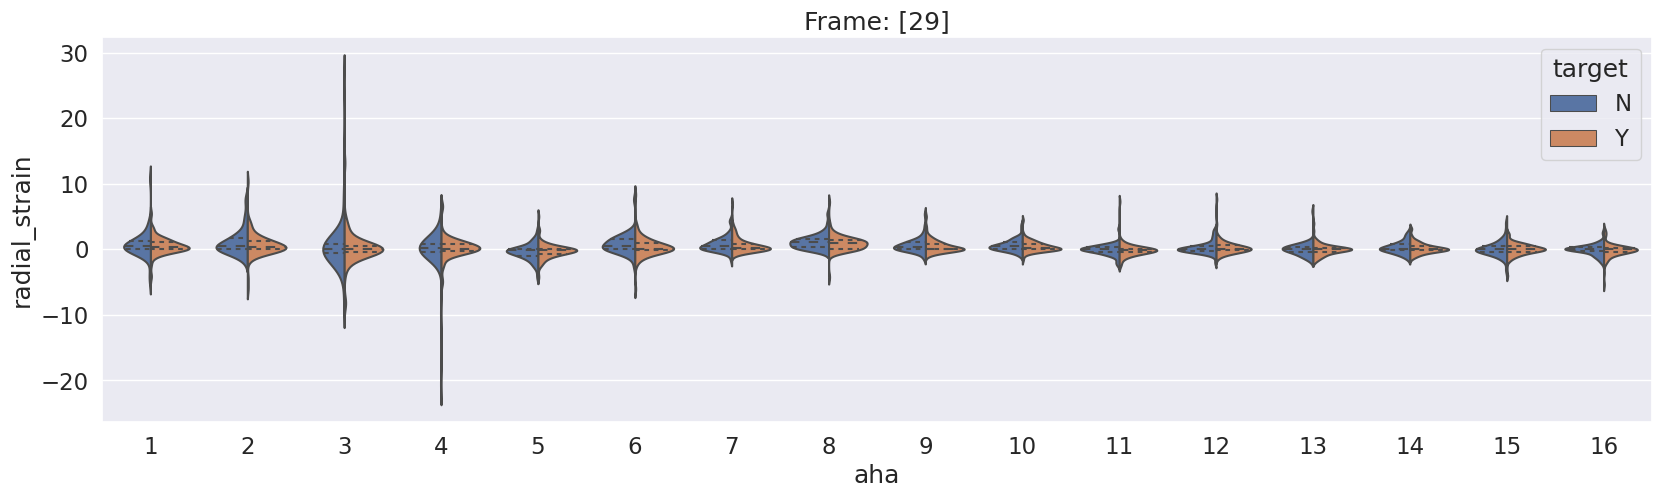

In [322]:
def plot_strain(df, segments=[1]):
    sb.set_context('paper')
    sb.set(font_scale = 1.5)
    fig, ax = plt.subplots(1,1,figsize=(20,5))
    plt.title('Frame: {}'.format(segments))
    sb.violinplot(x="aha", y="radial_strain",inner='quart',
                     data=df[df['frame'].isin(segments)],
                  ax=ax,
                 hue='target',
                 split=True
                 );plt.show()
_ = [plot_strain(df_merged, segments=[i]) for i in range(1,30)]

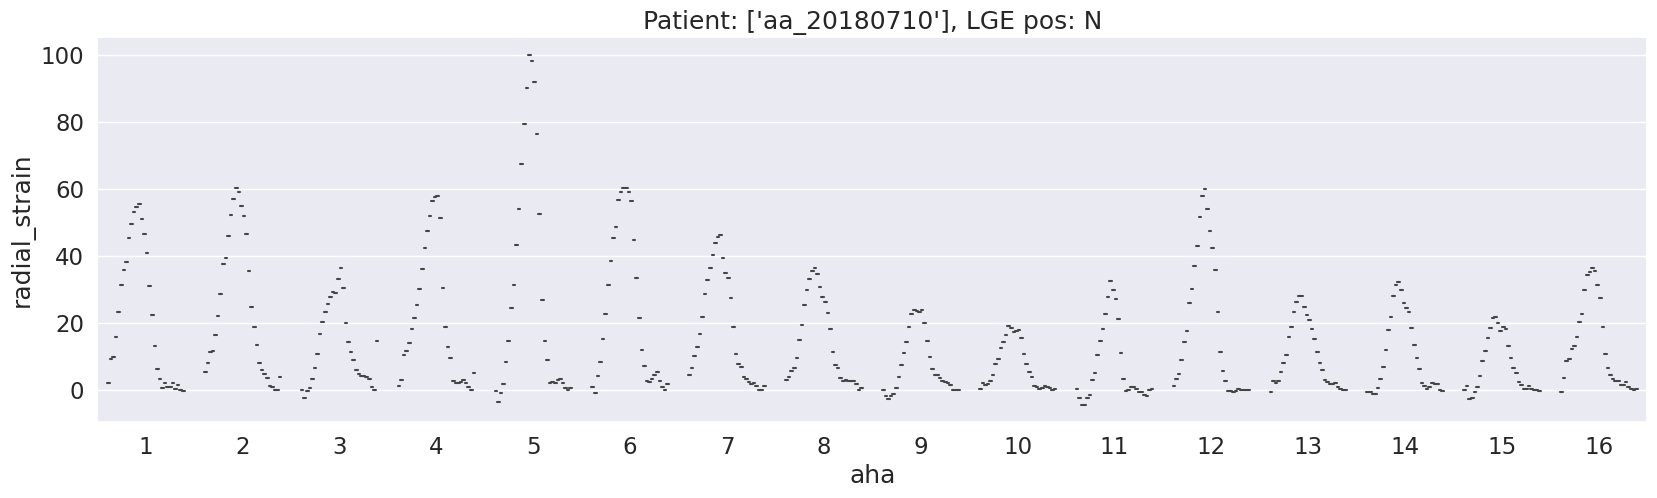

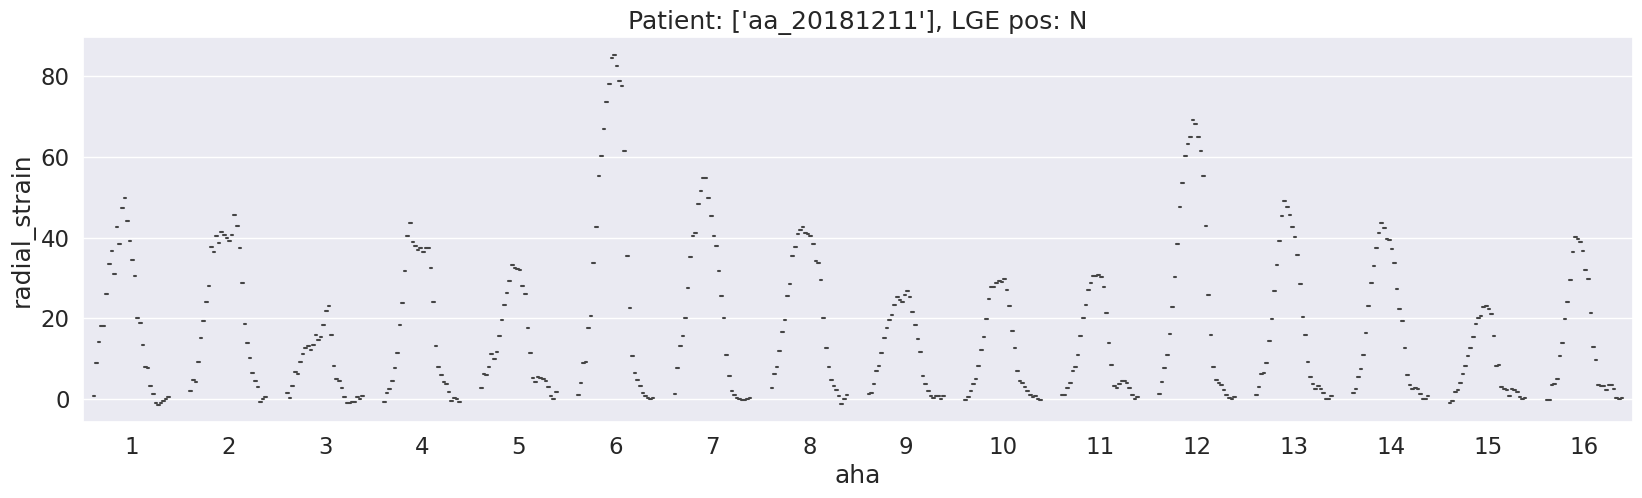

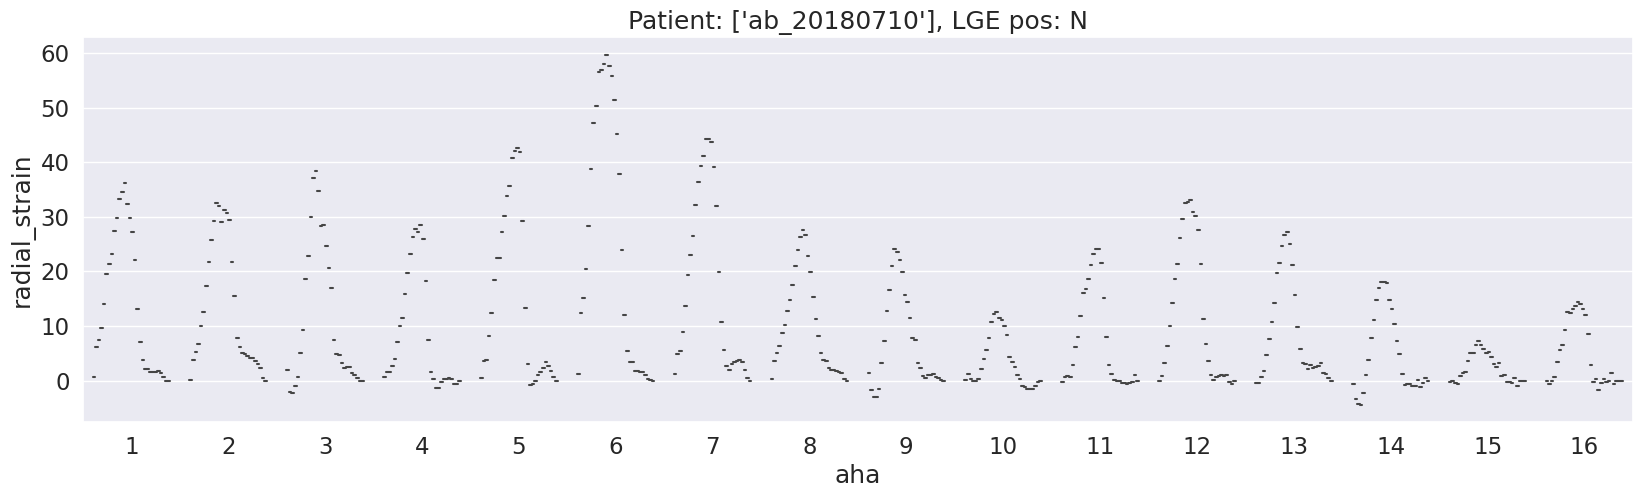

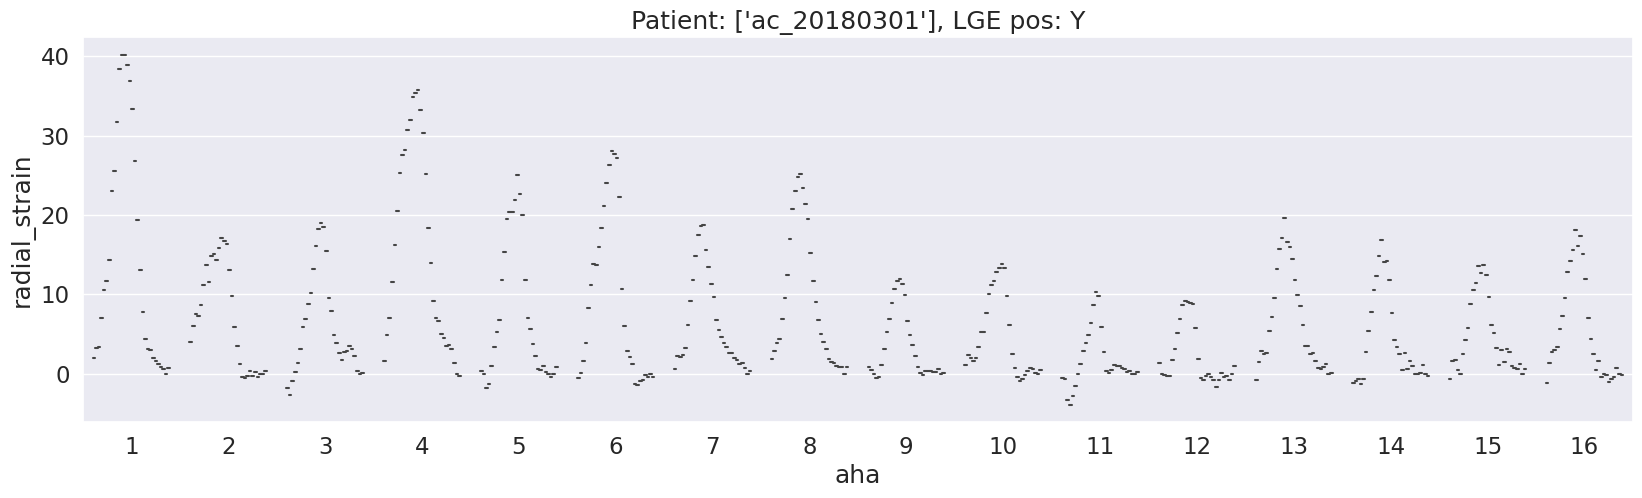

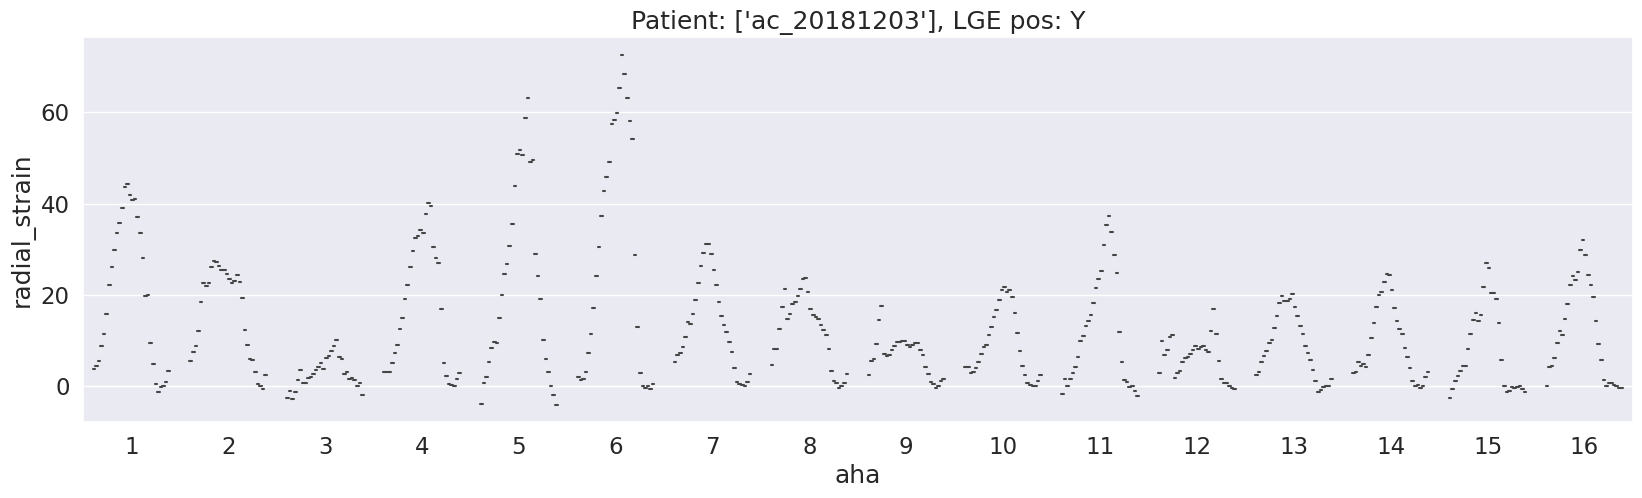

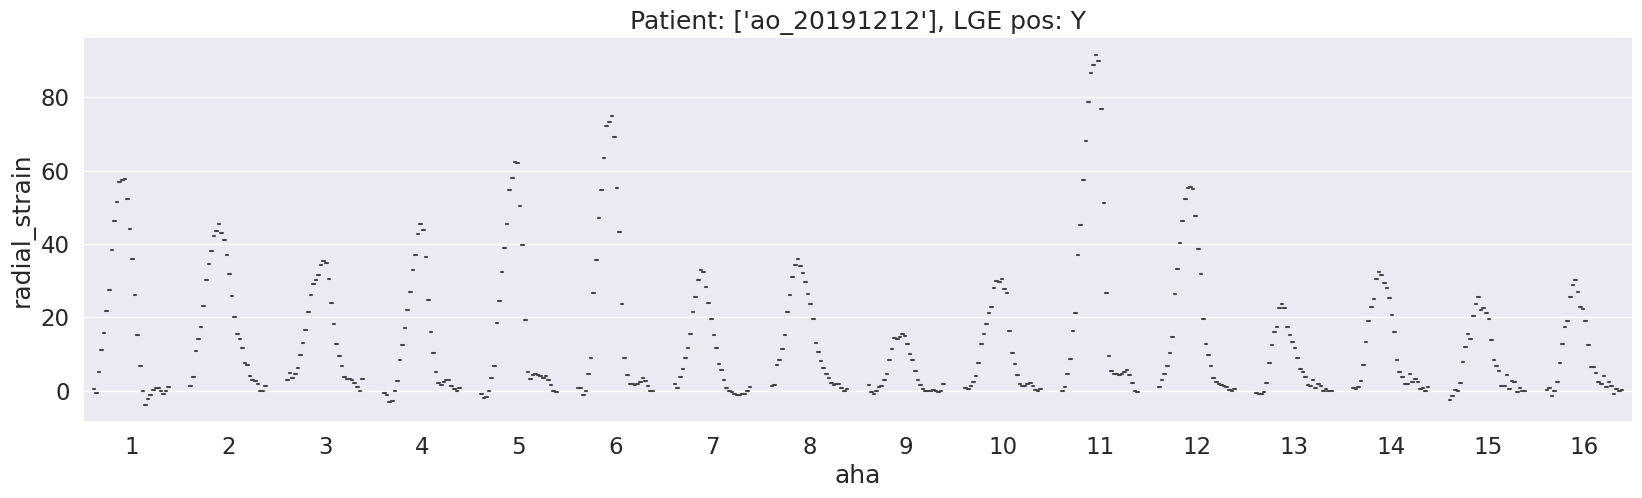

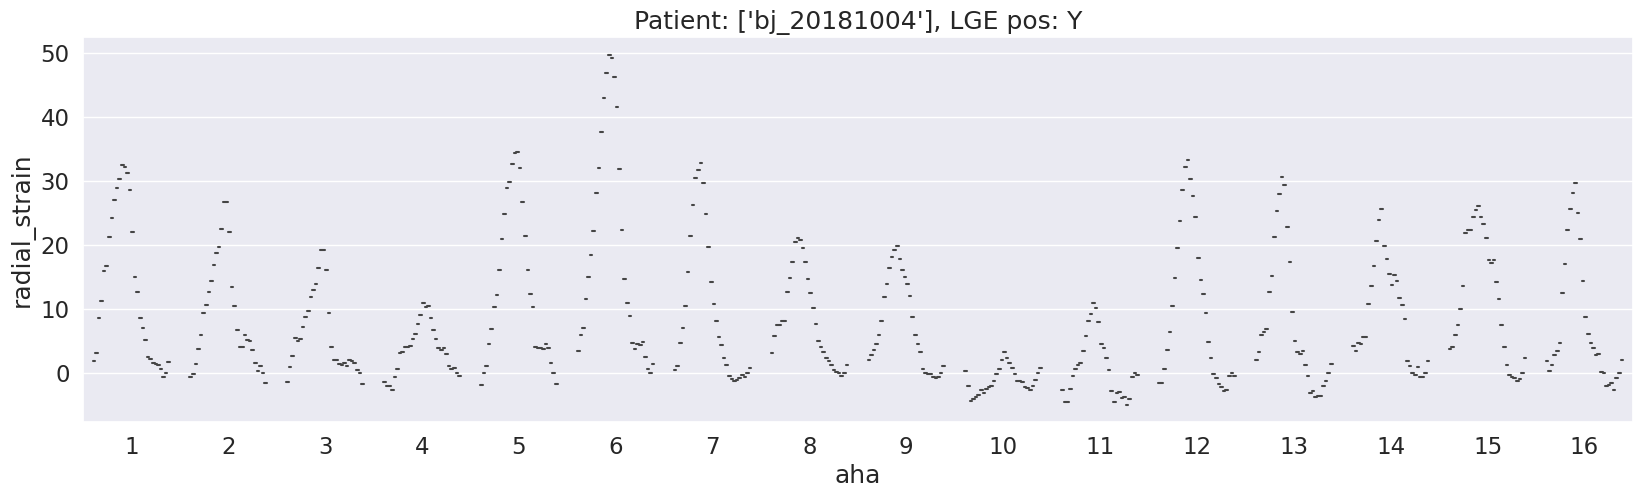

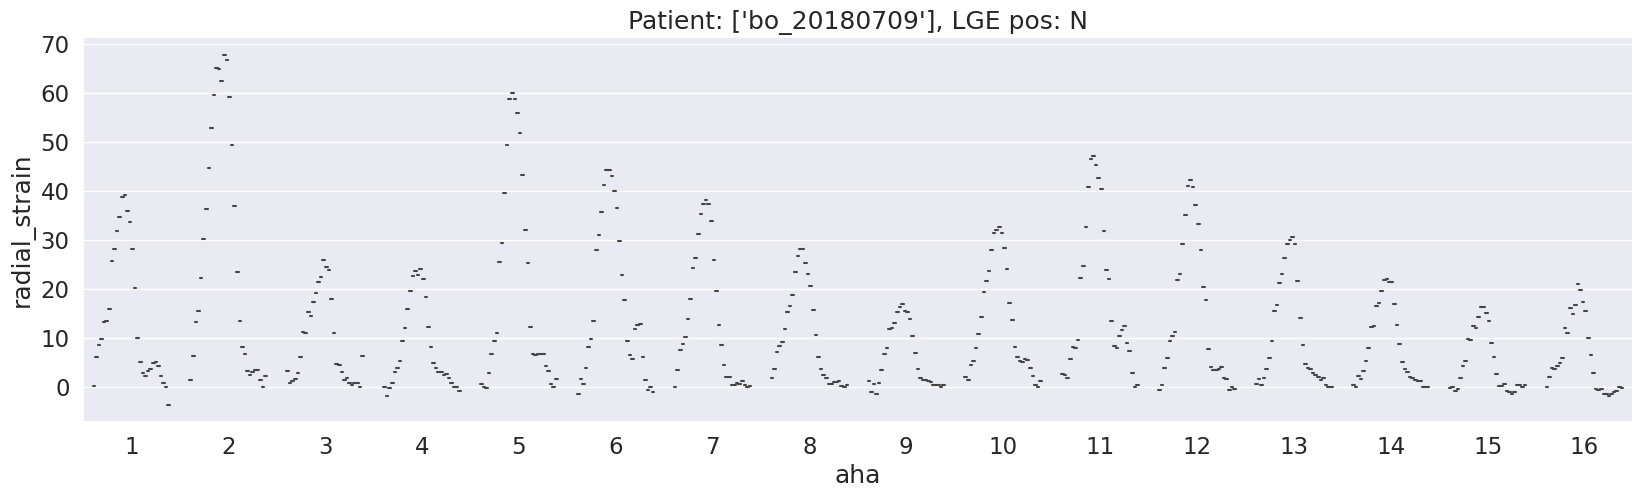

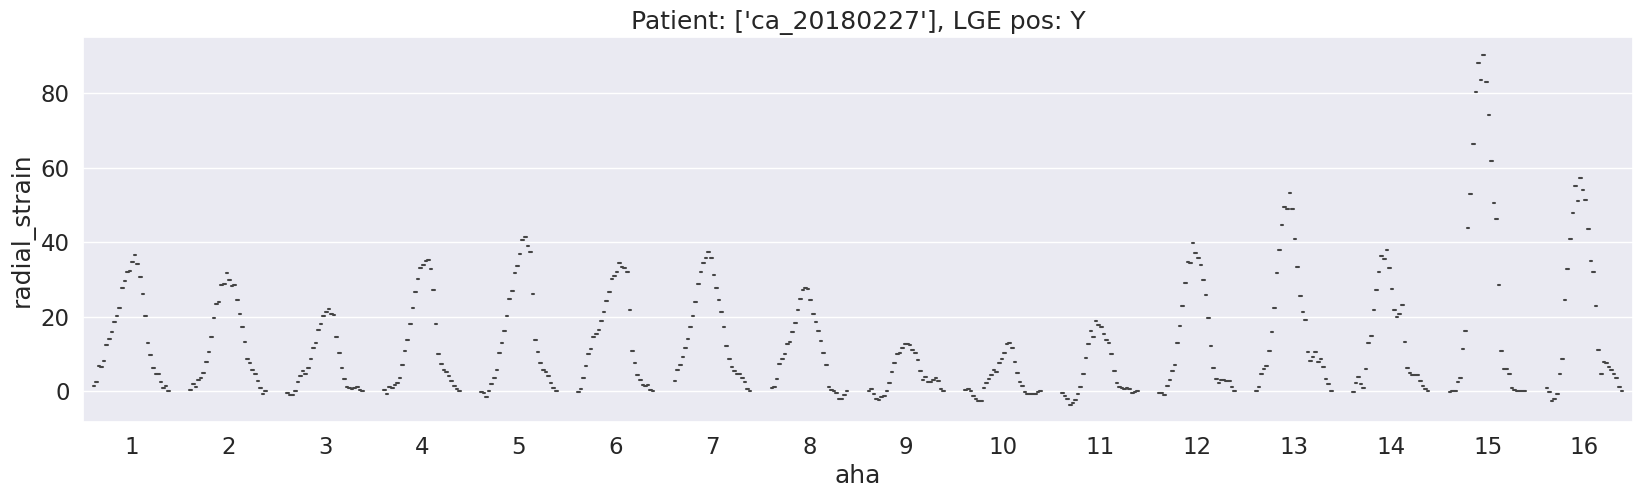

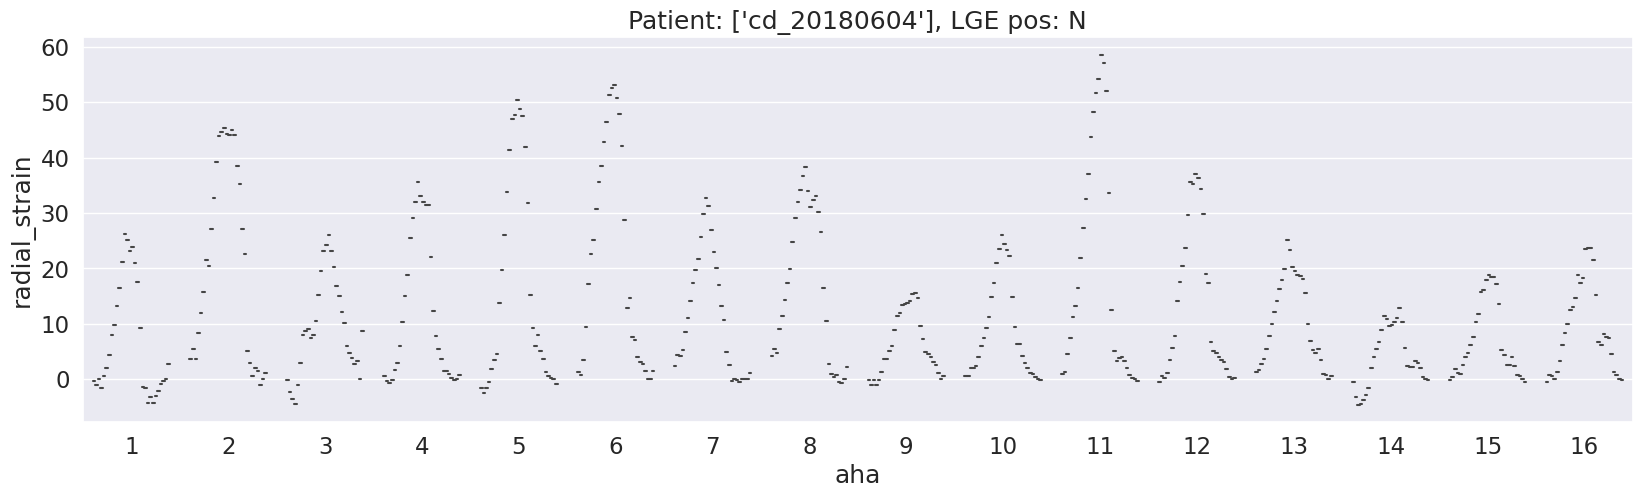

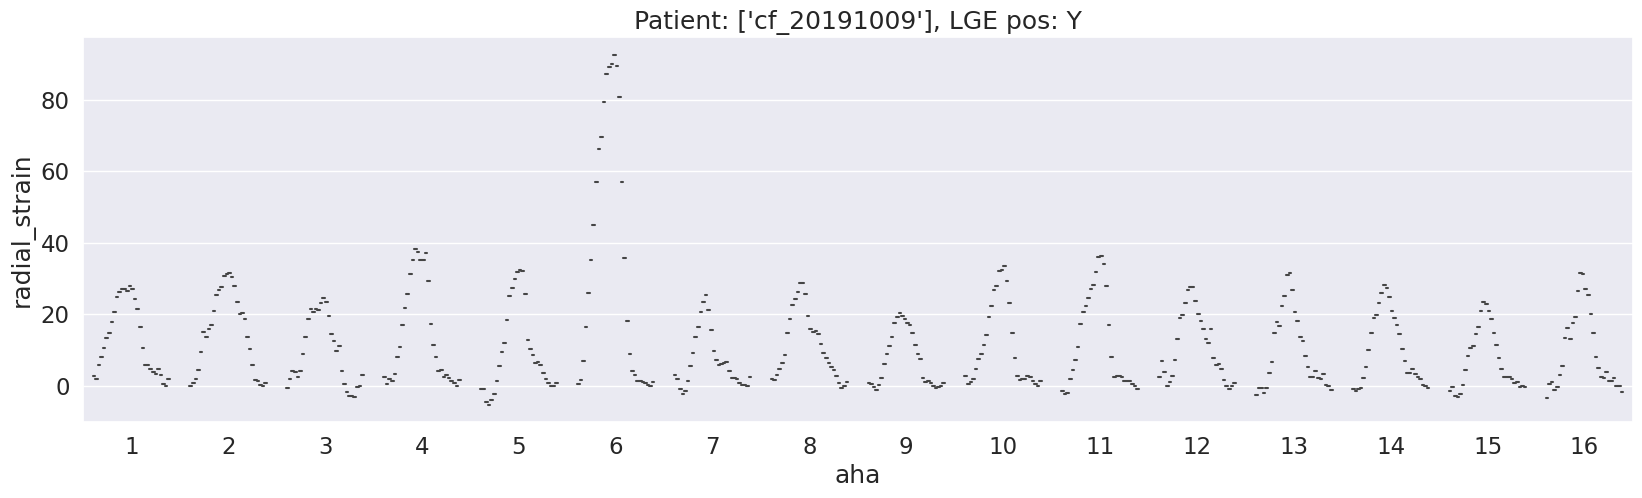

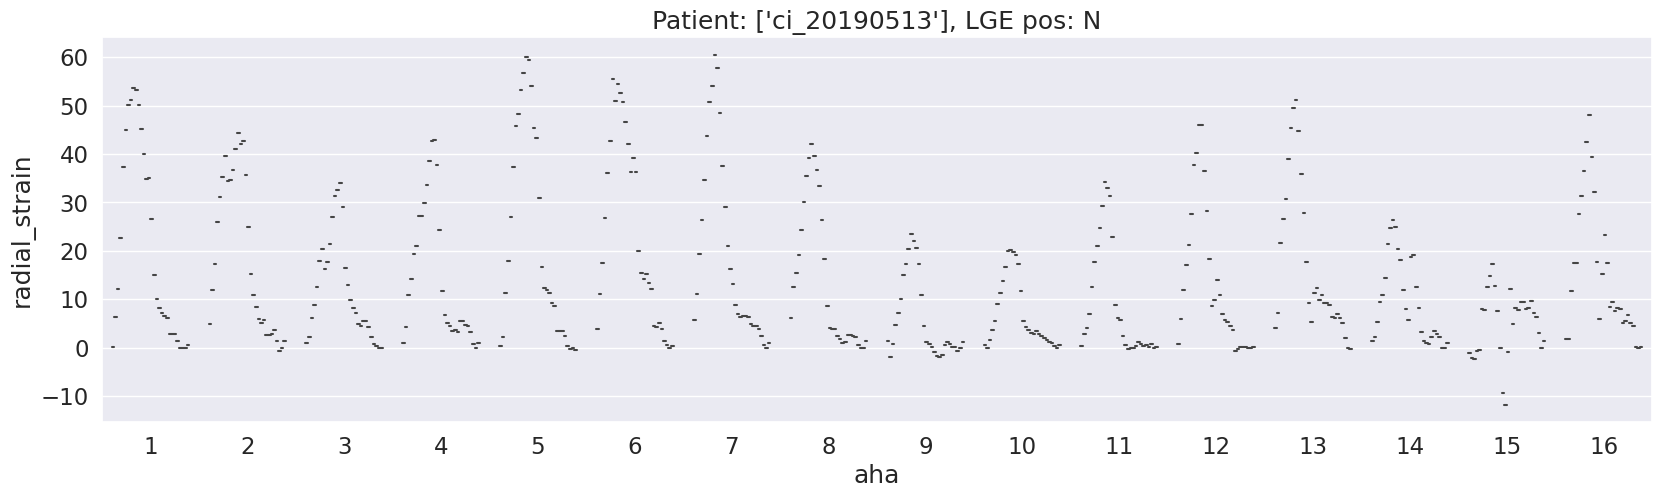

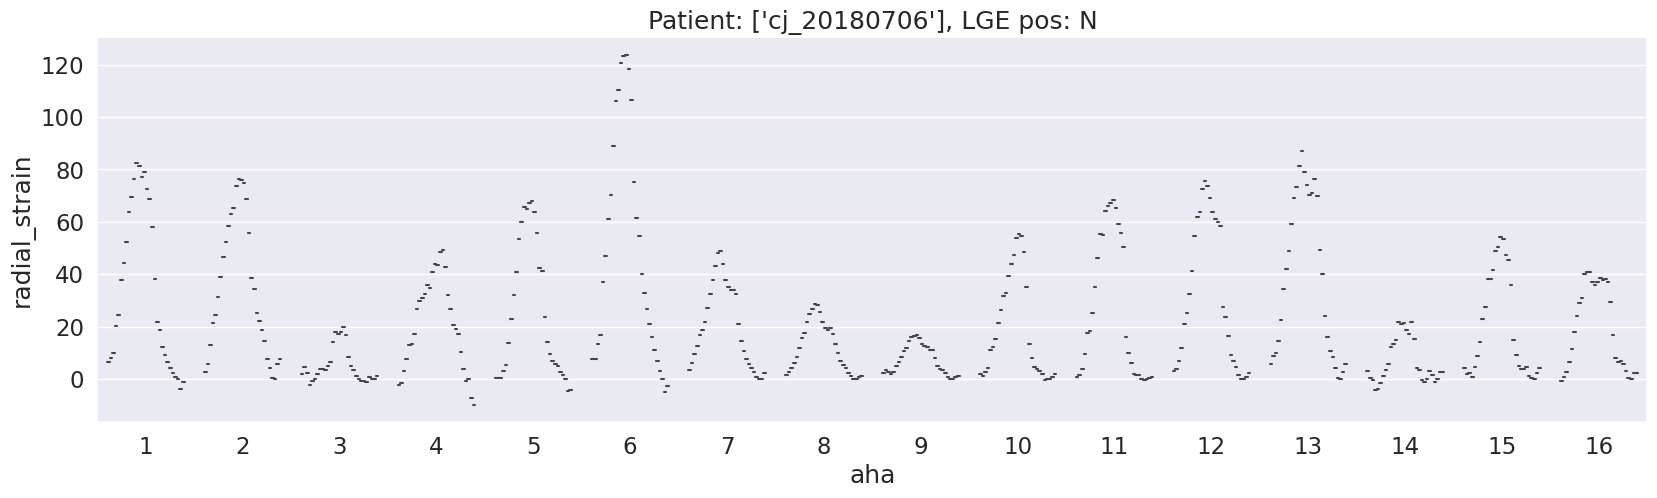

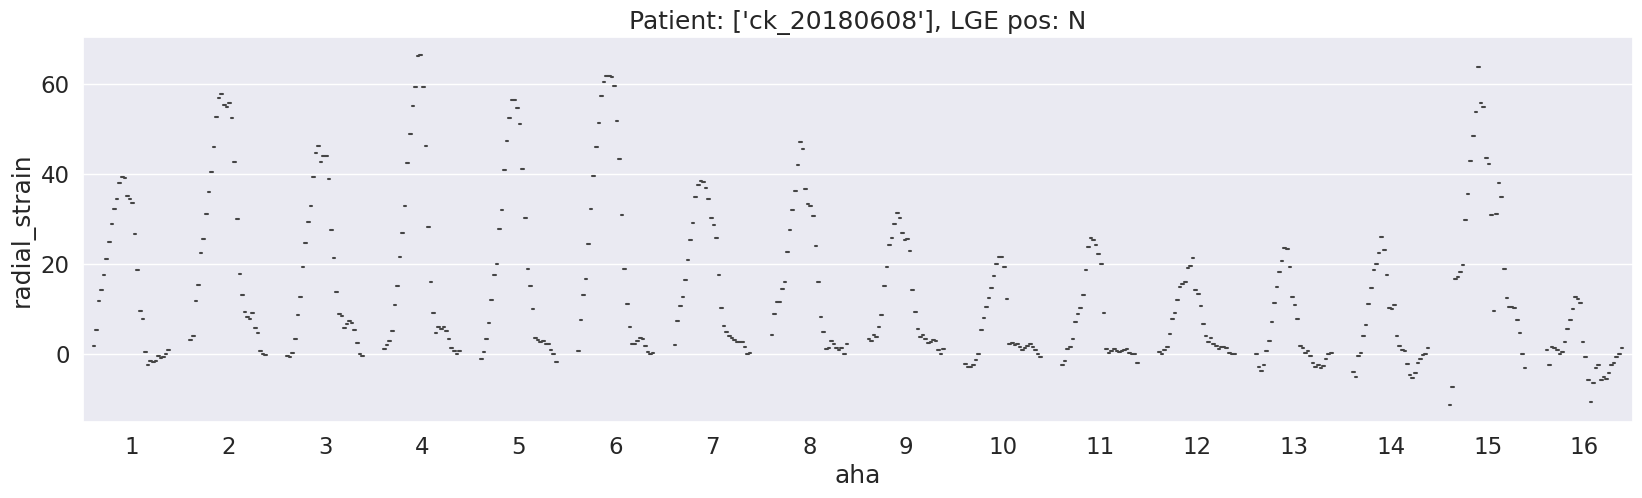

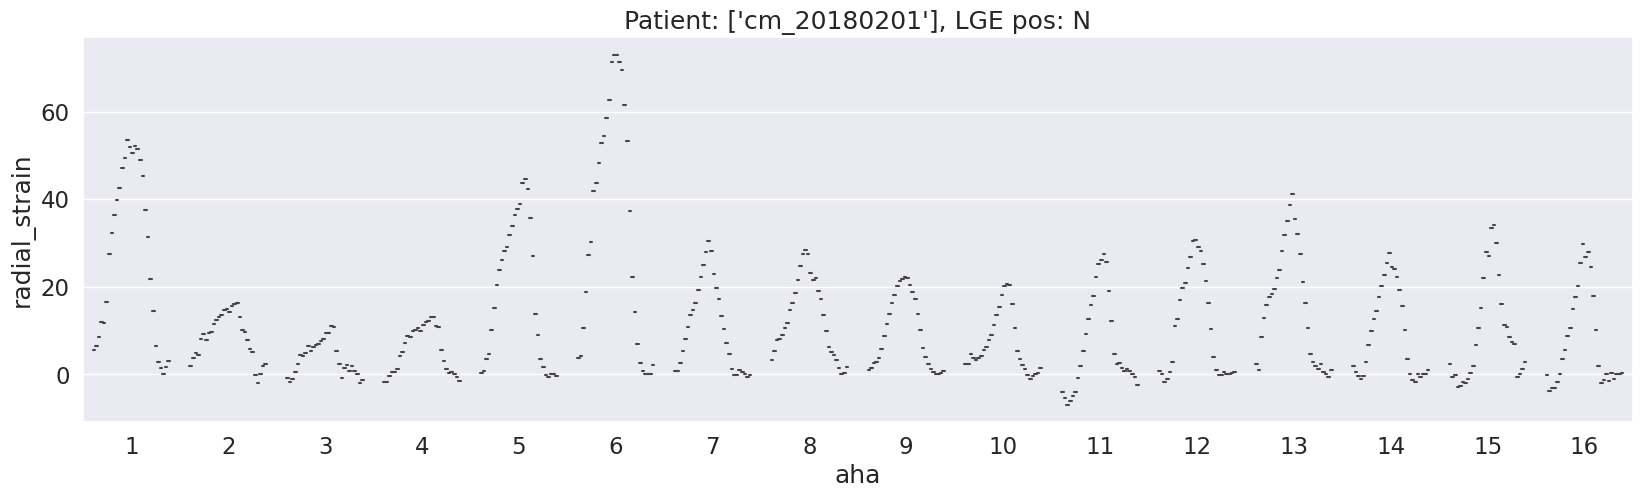

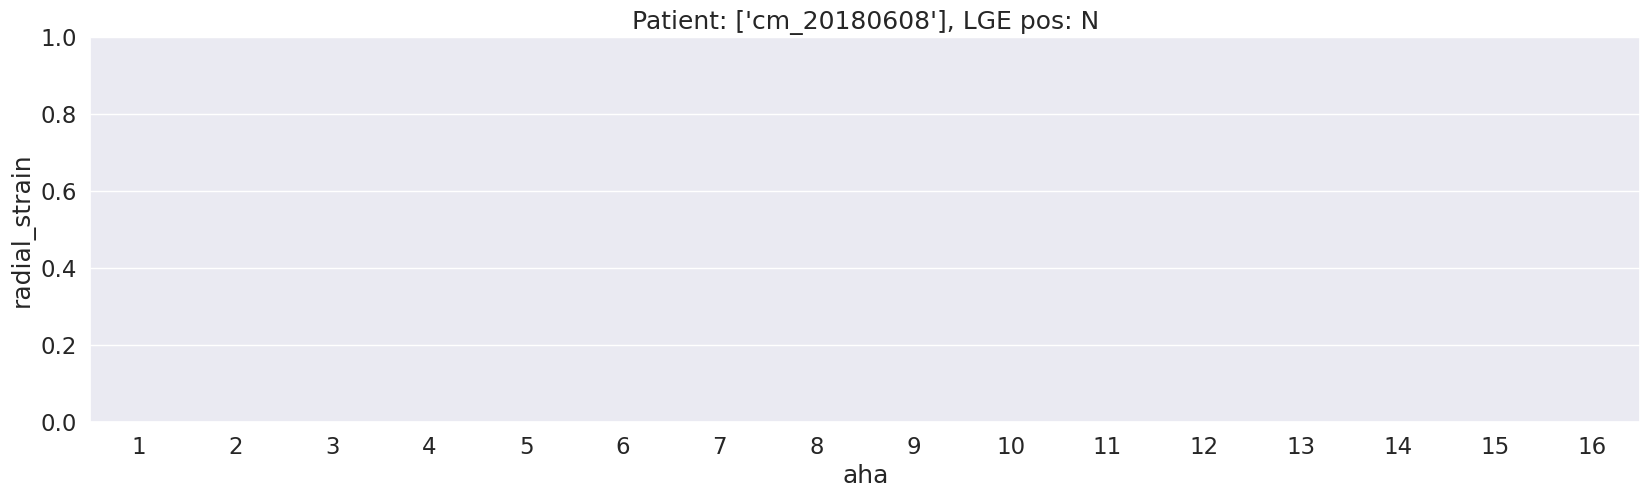

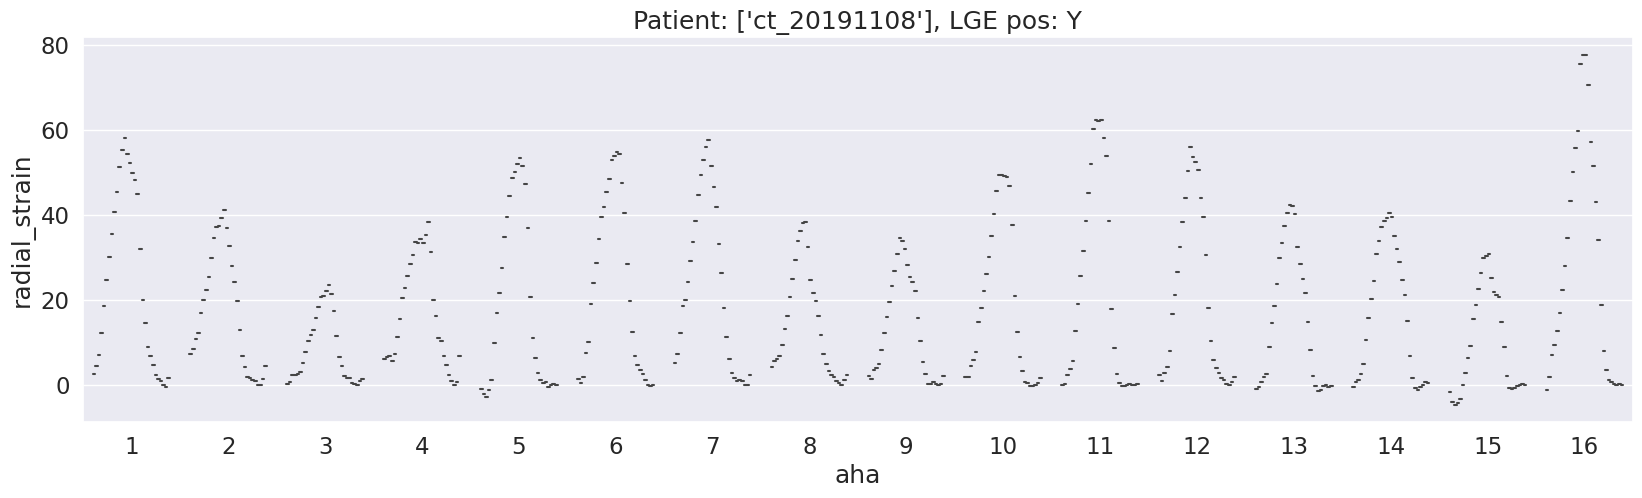

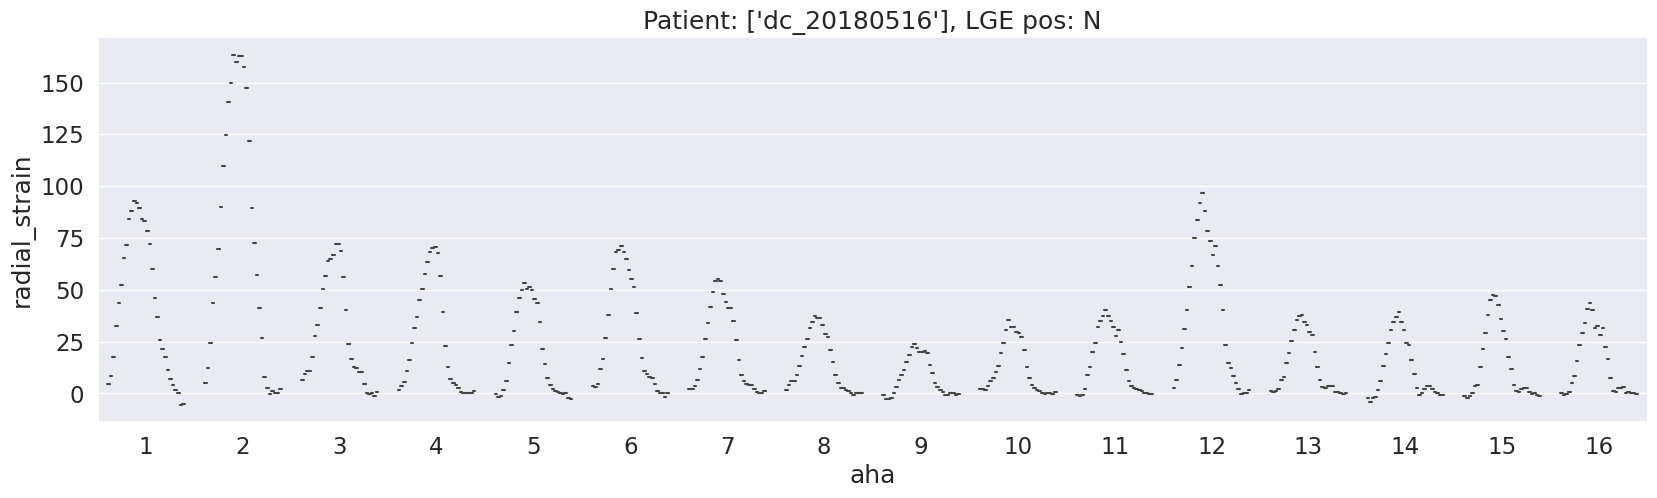

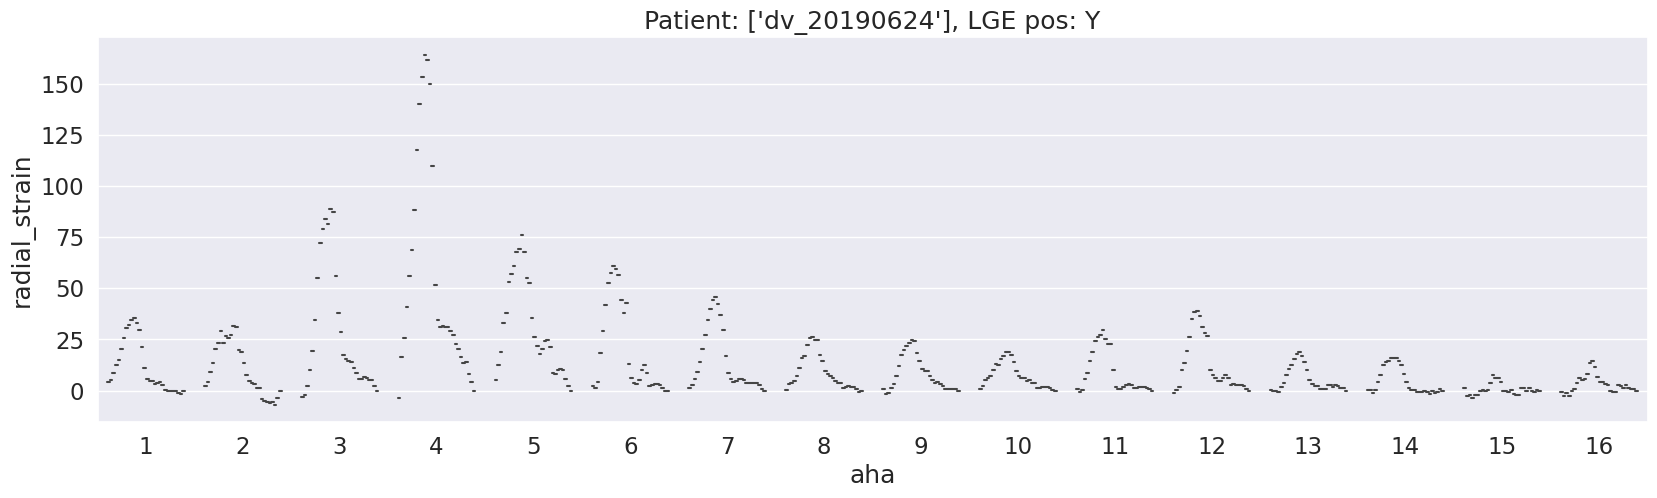

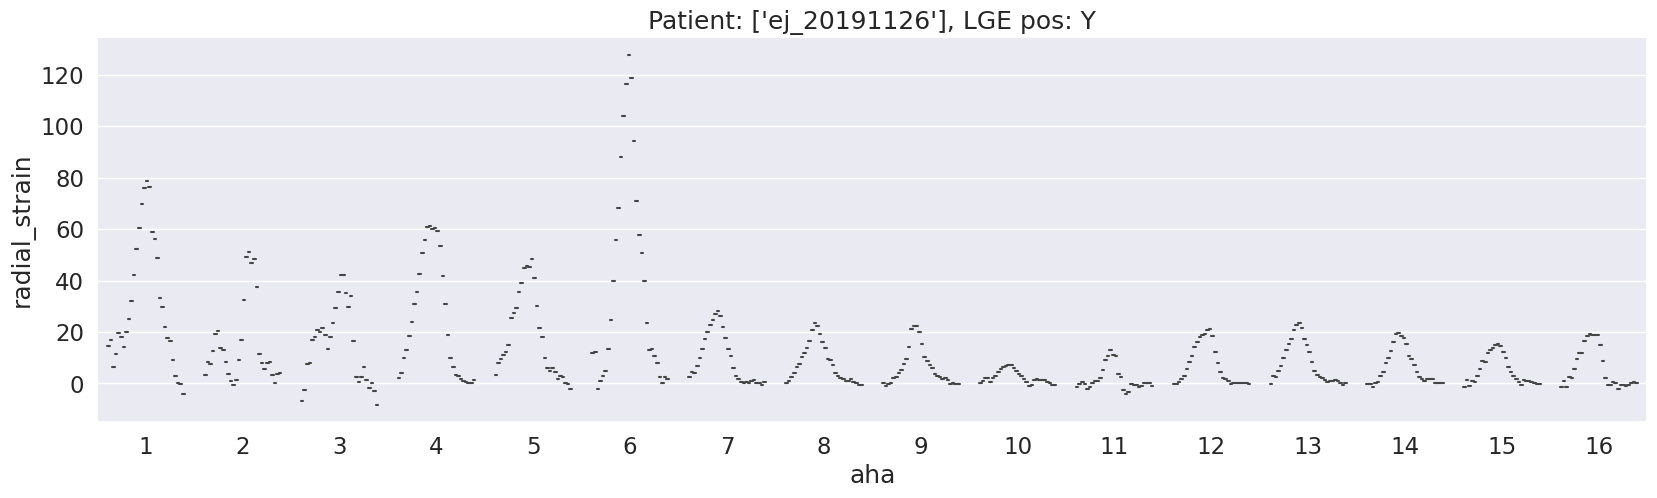

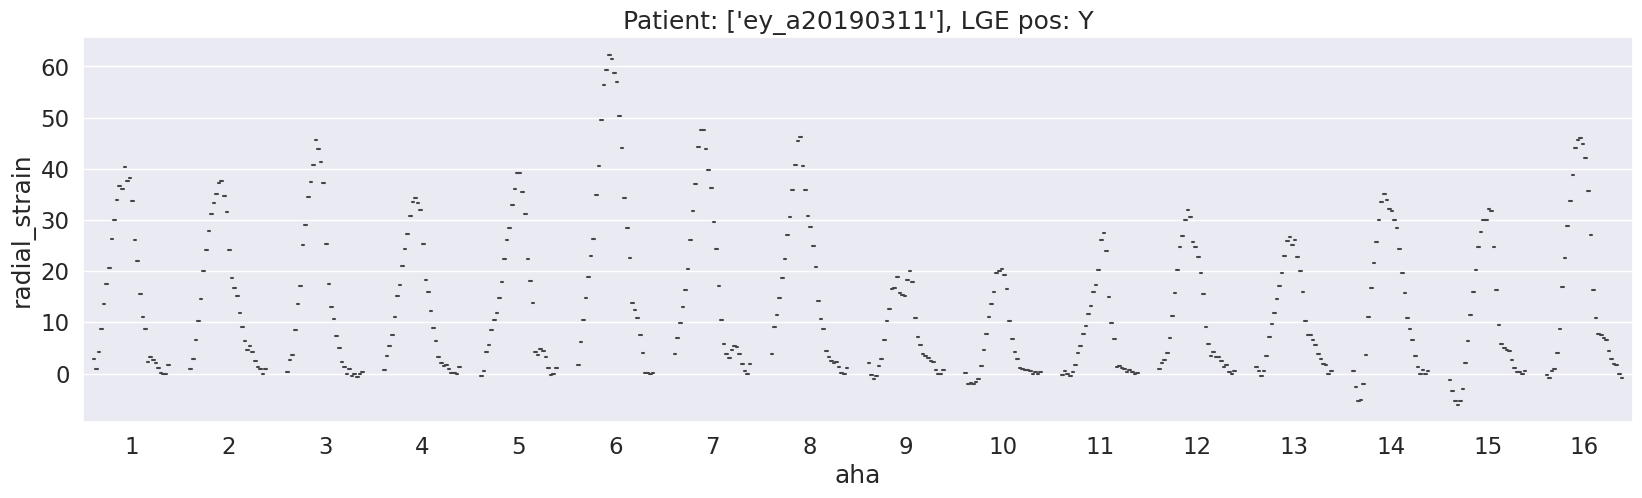

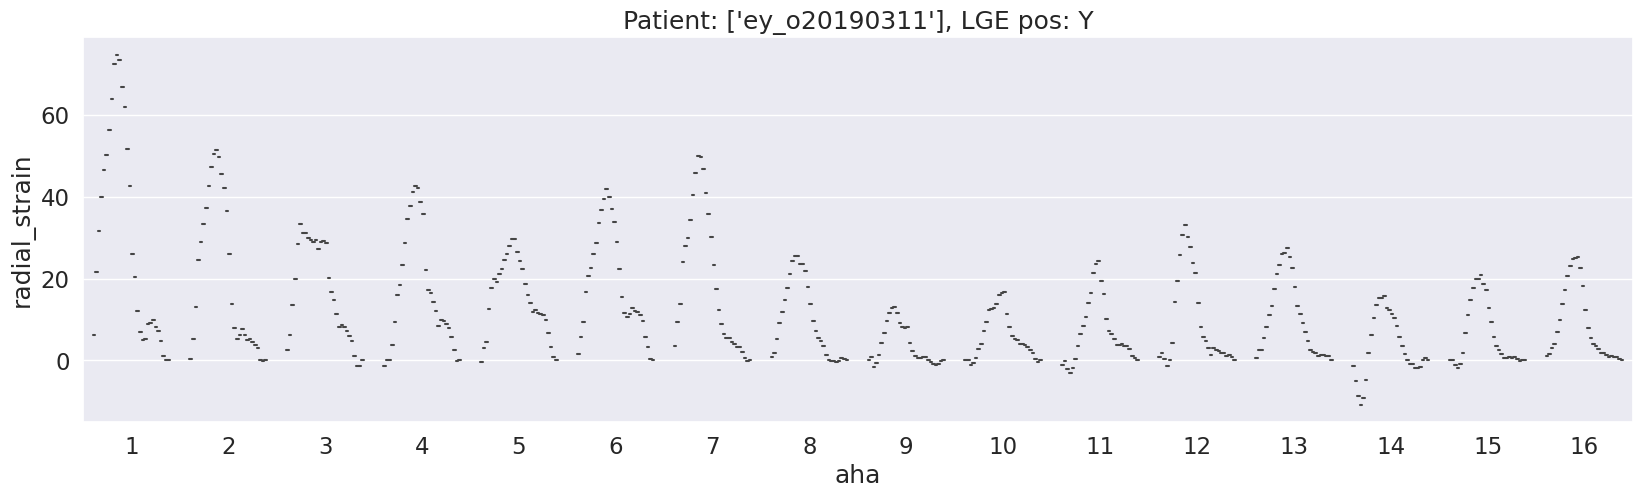

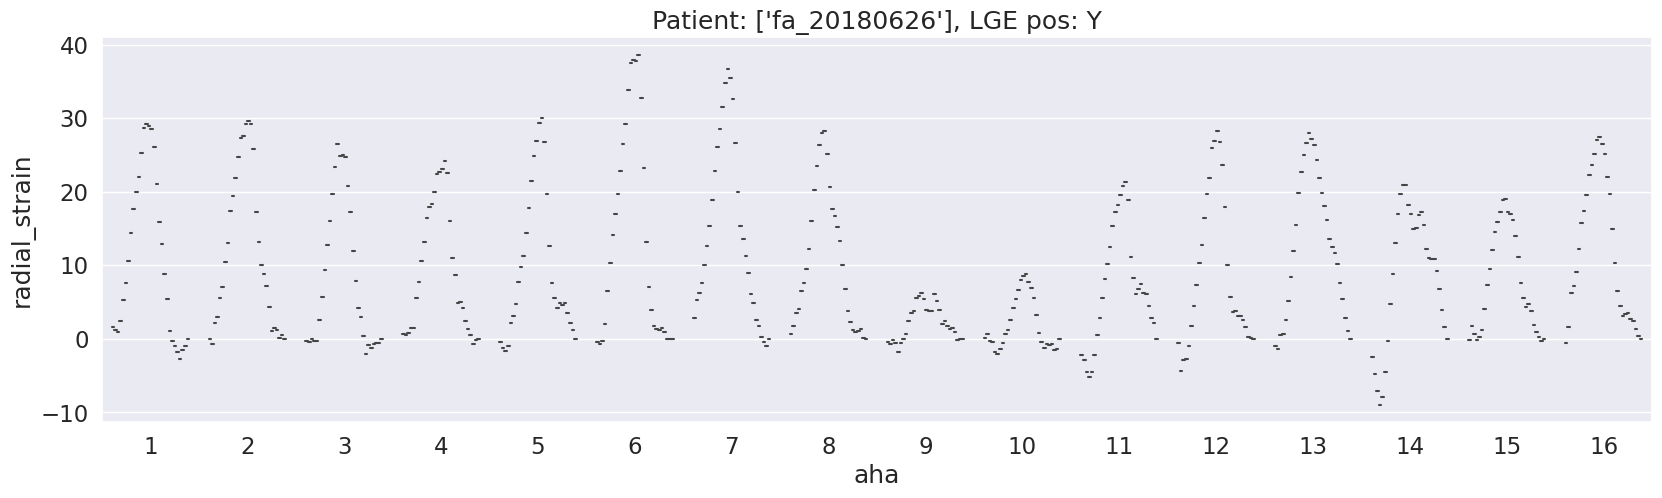

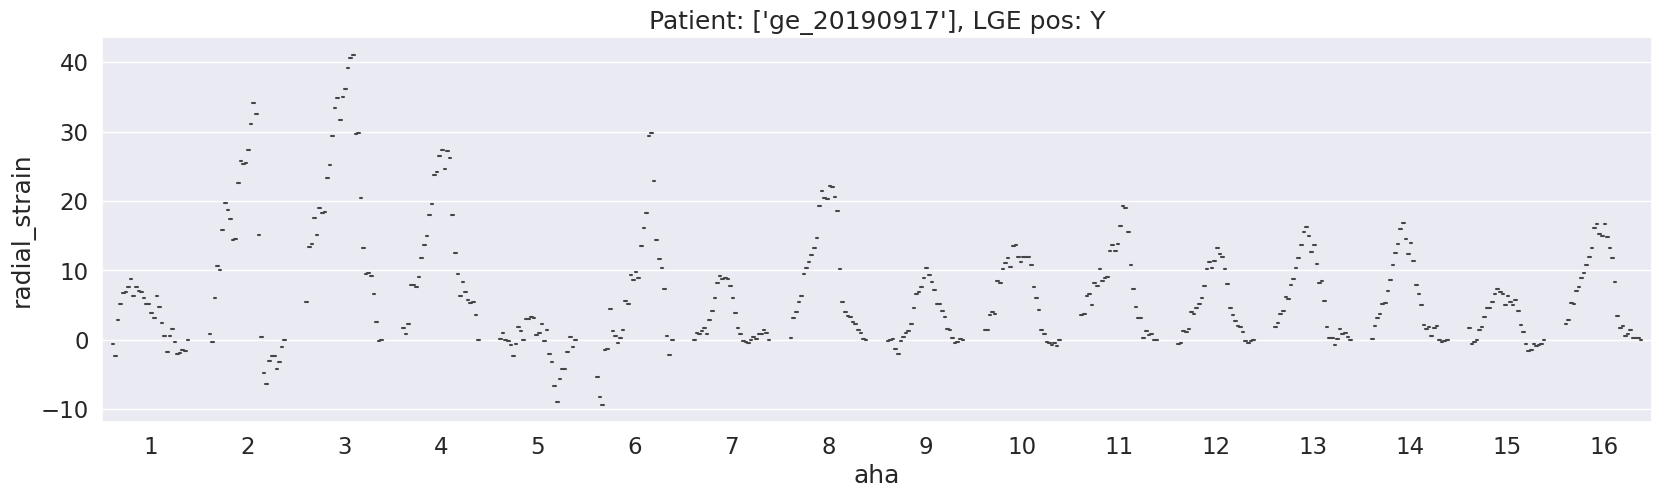

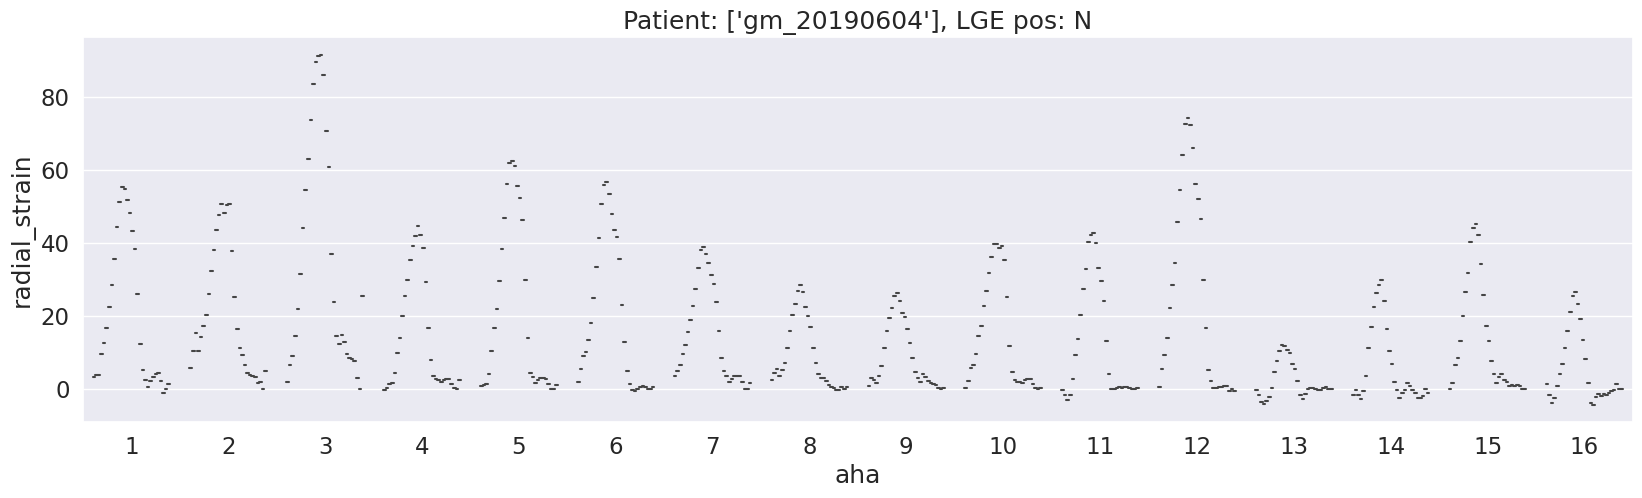

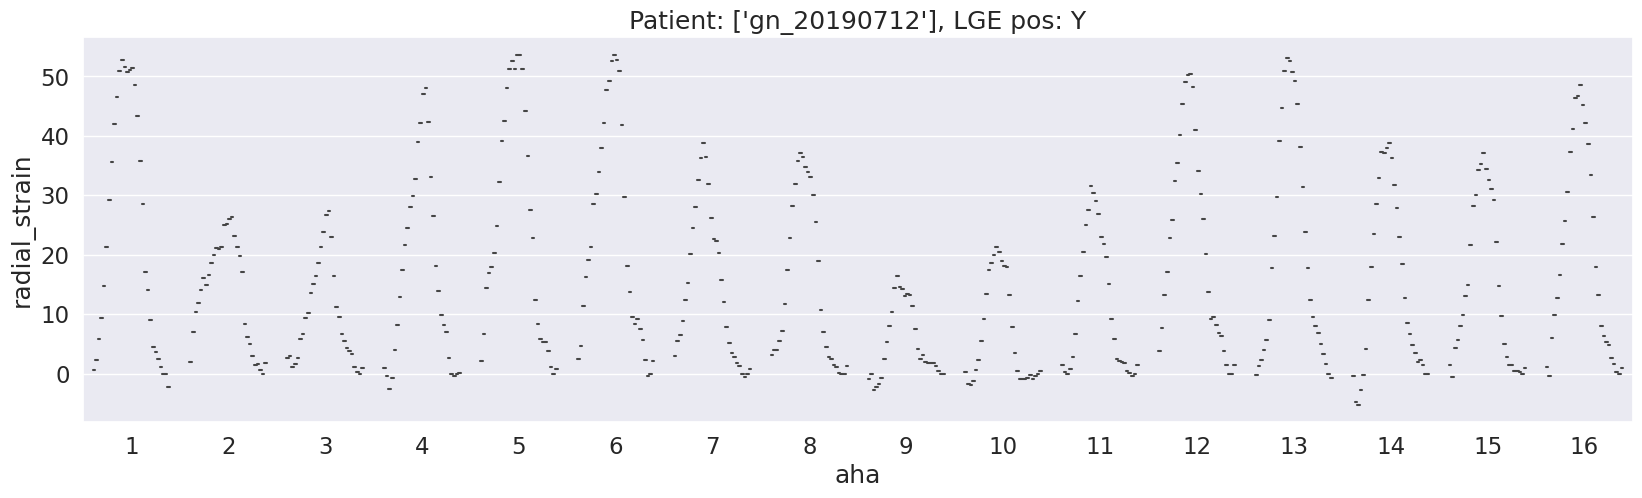

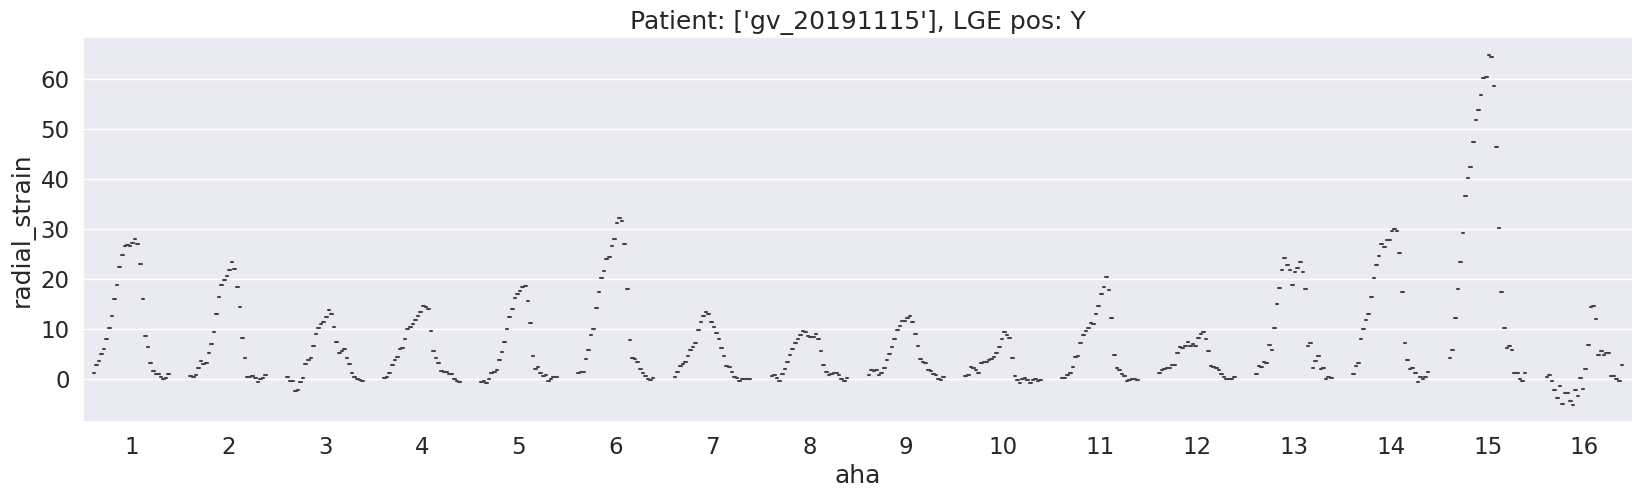

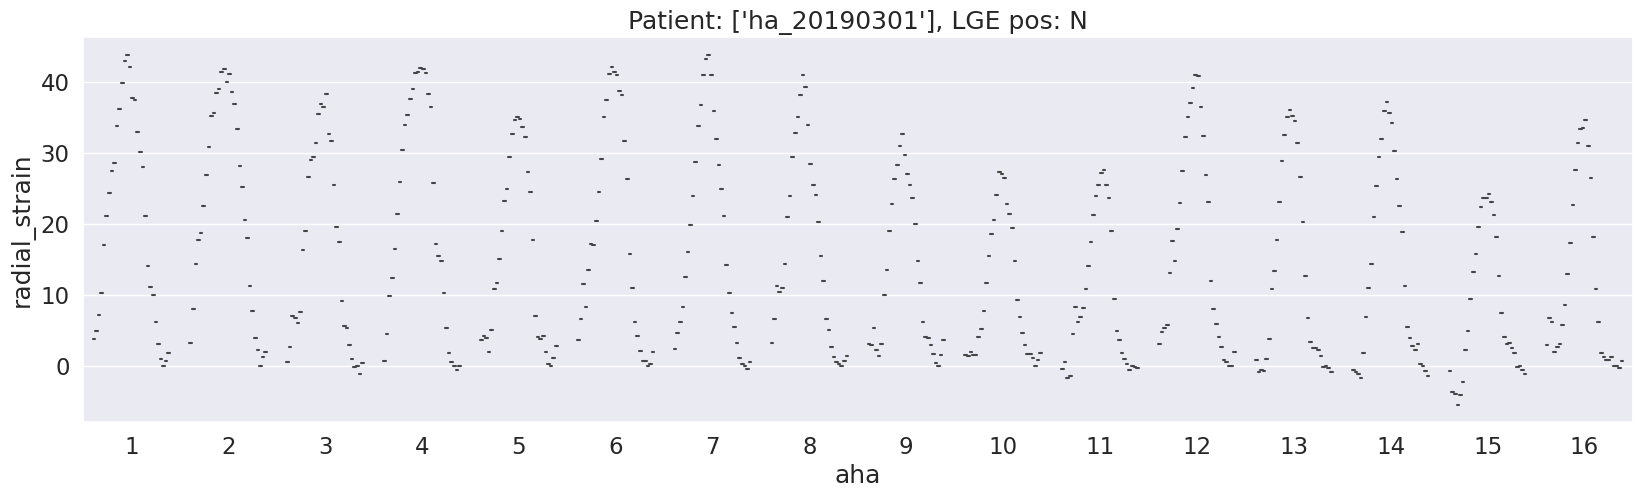

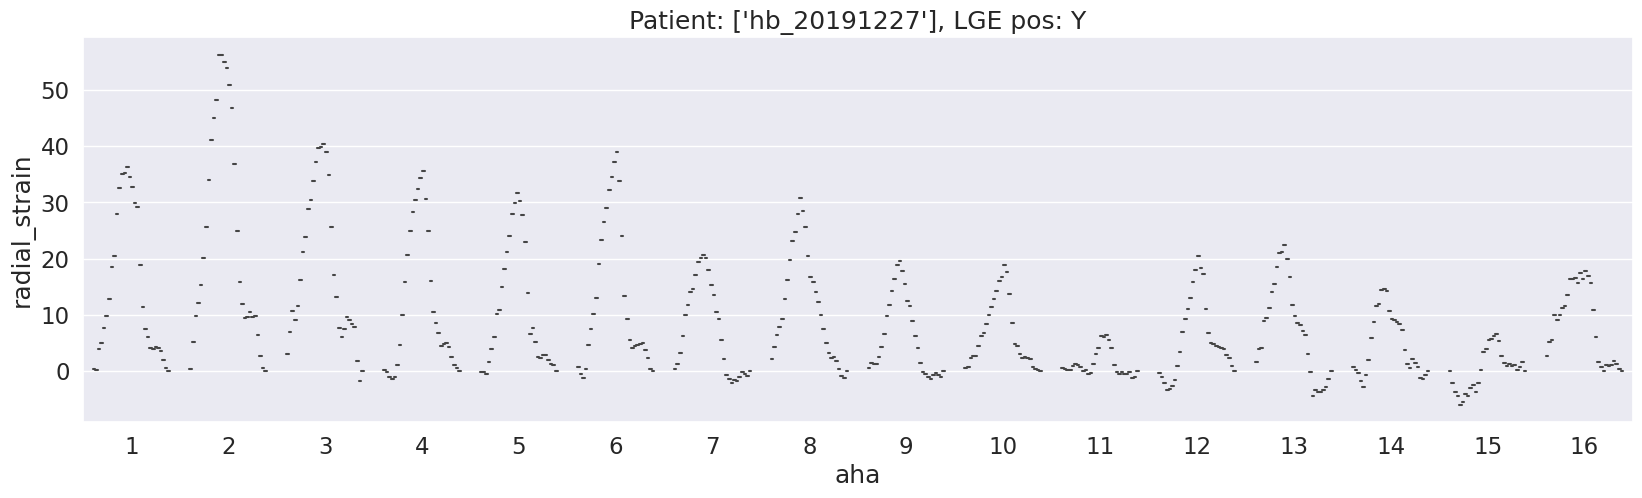

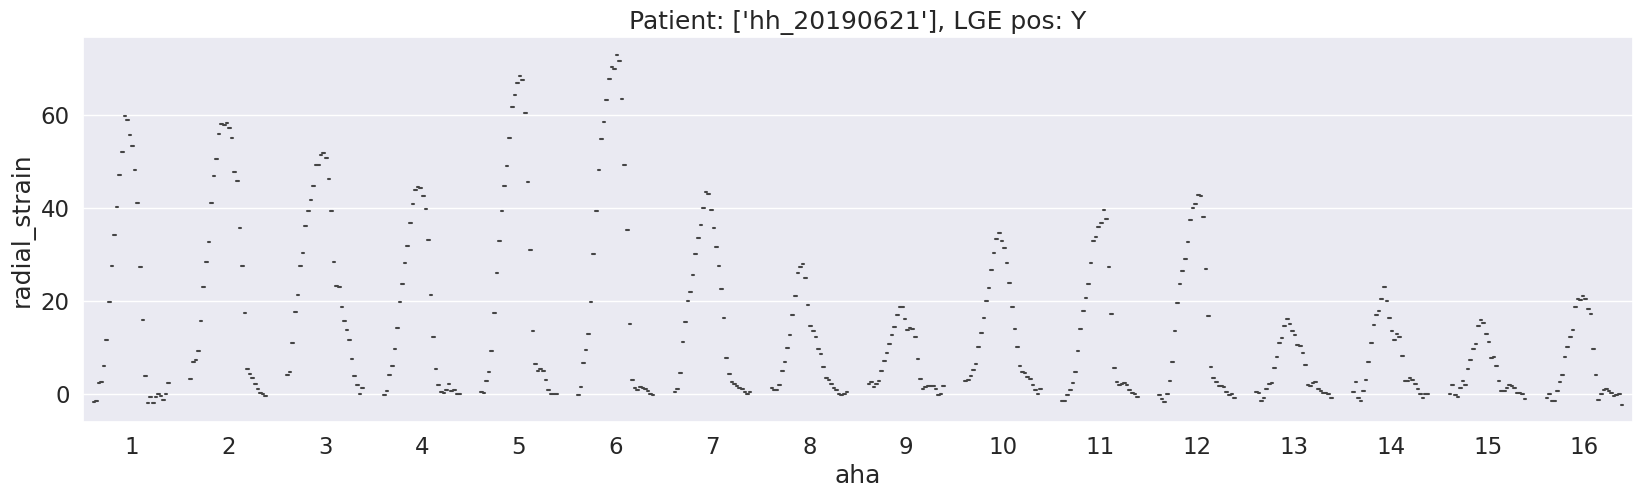

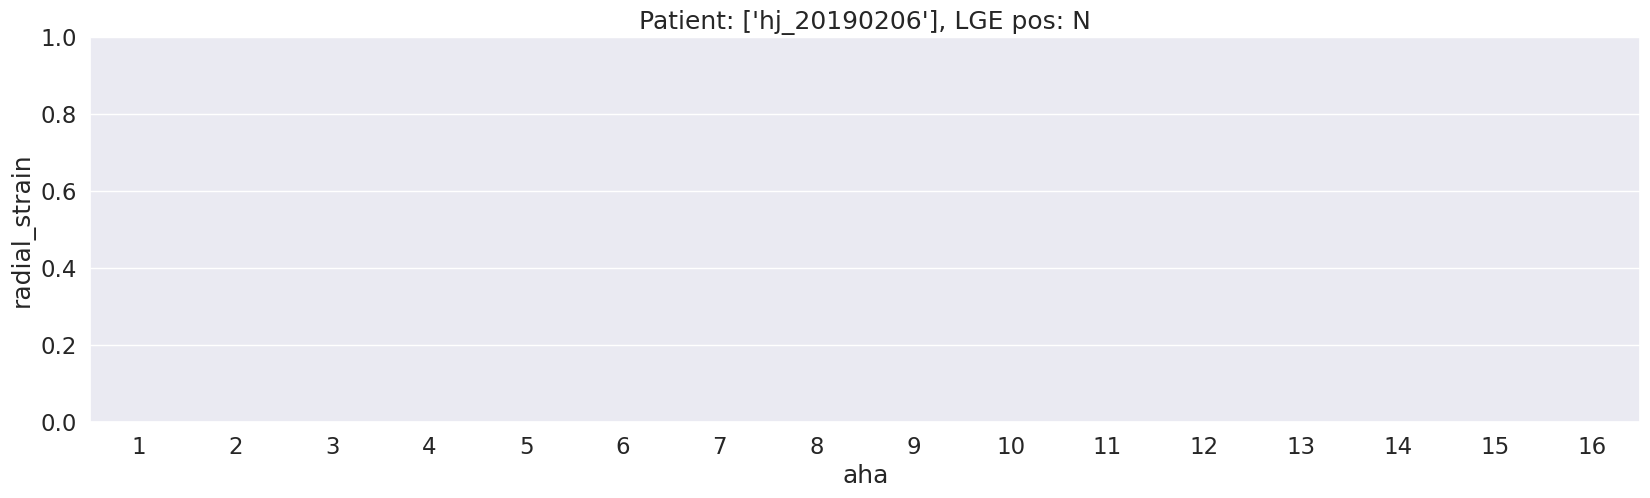

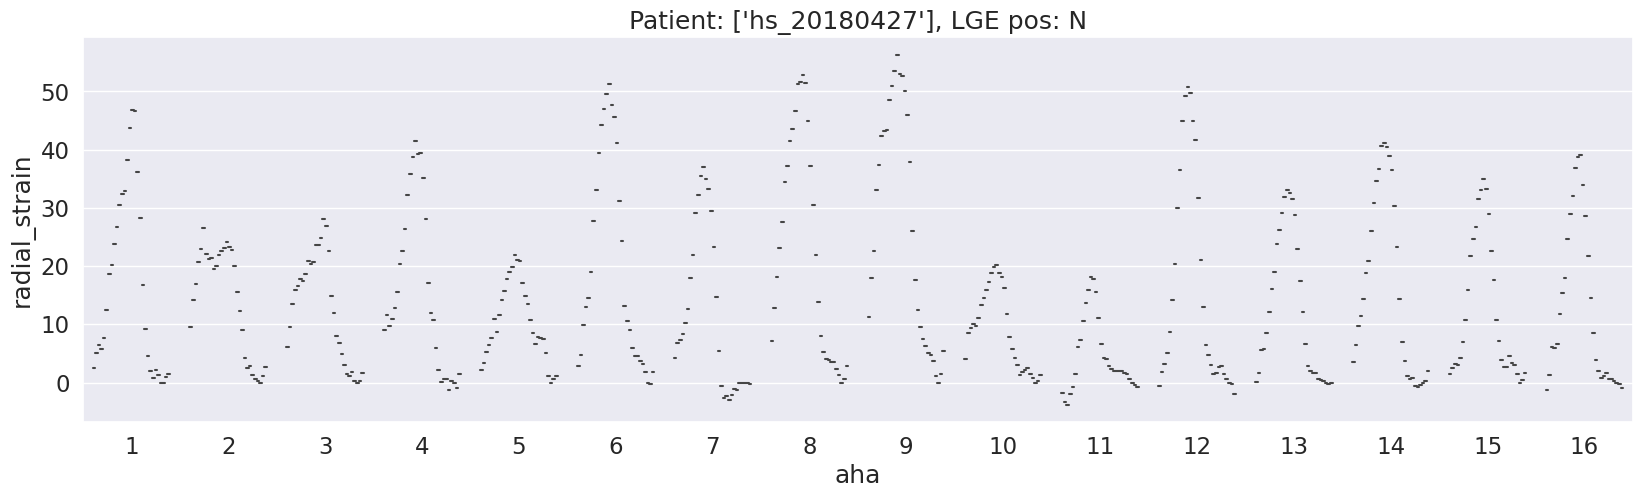

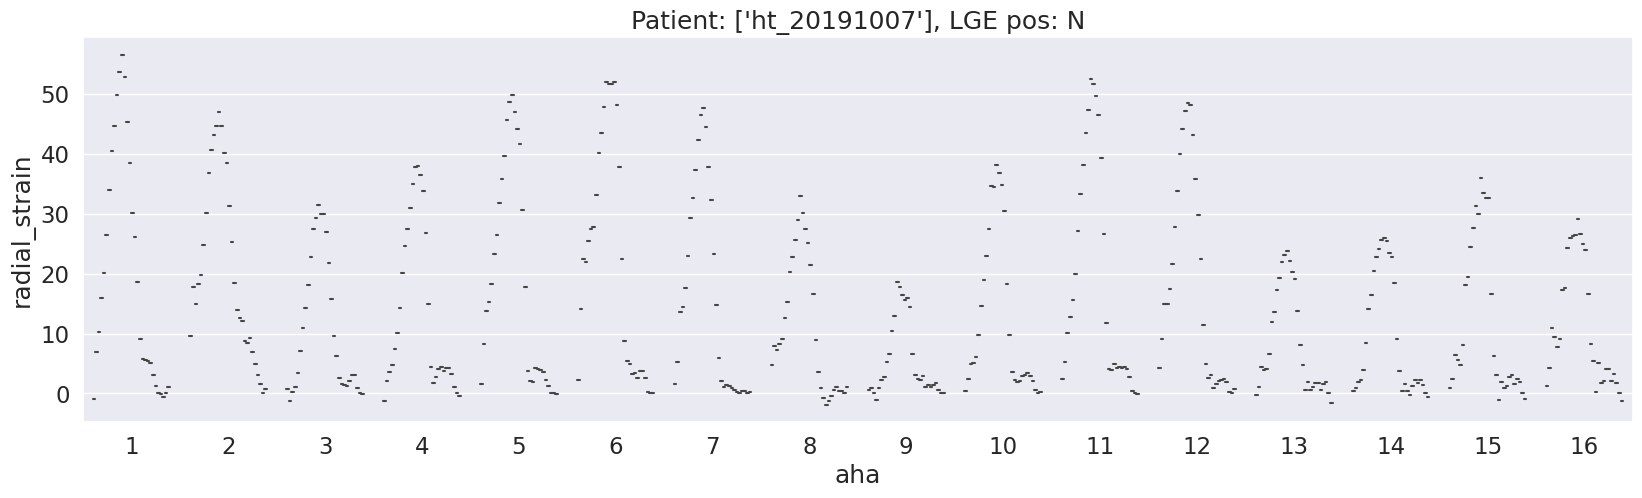

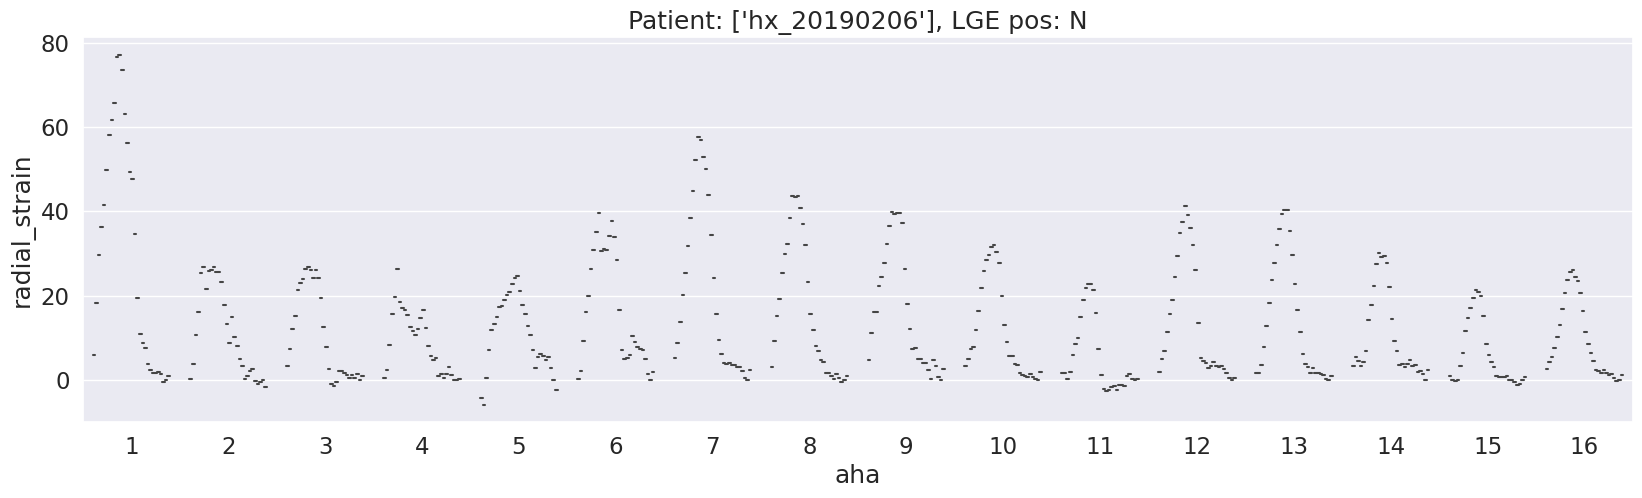

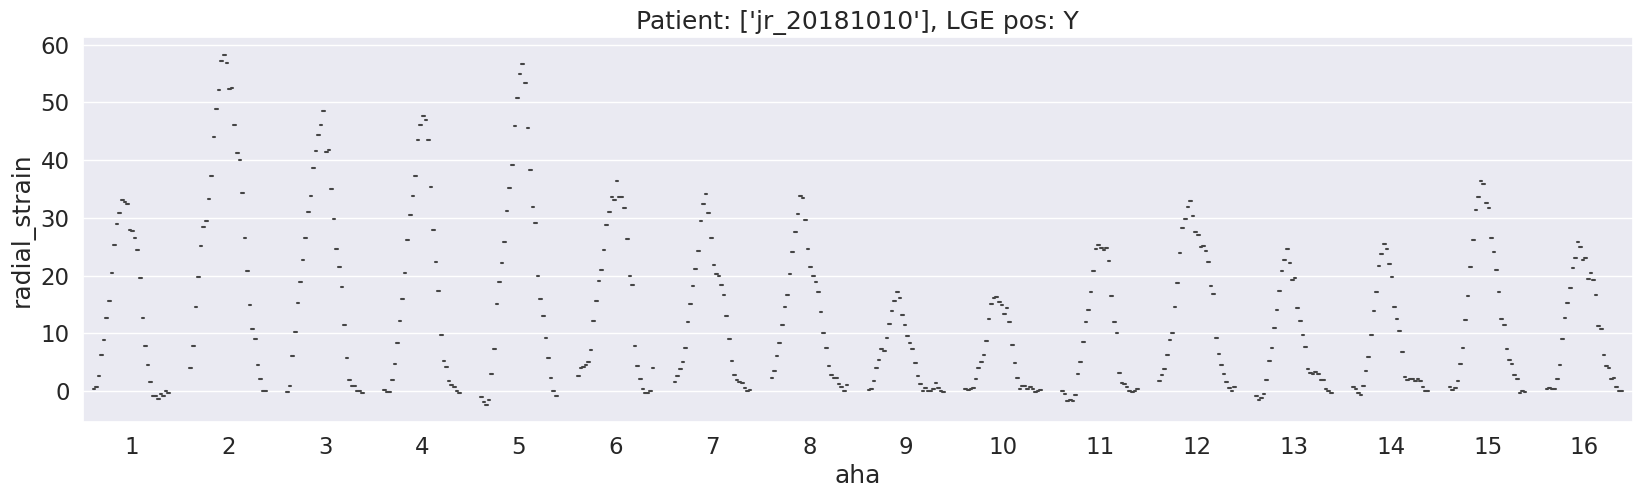

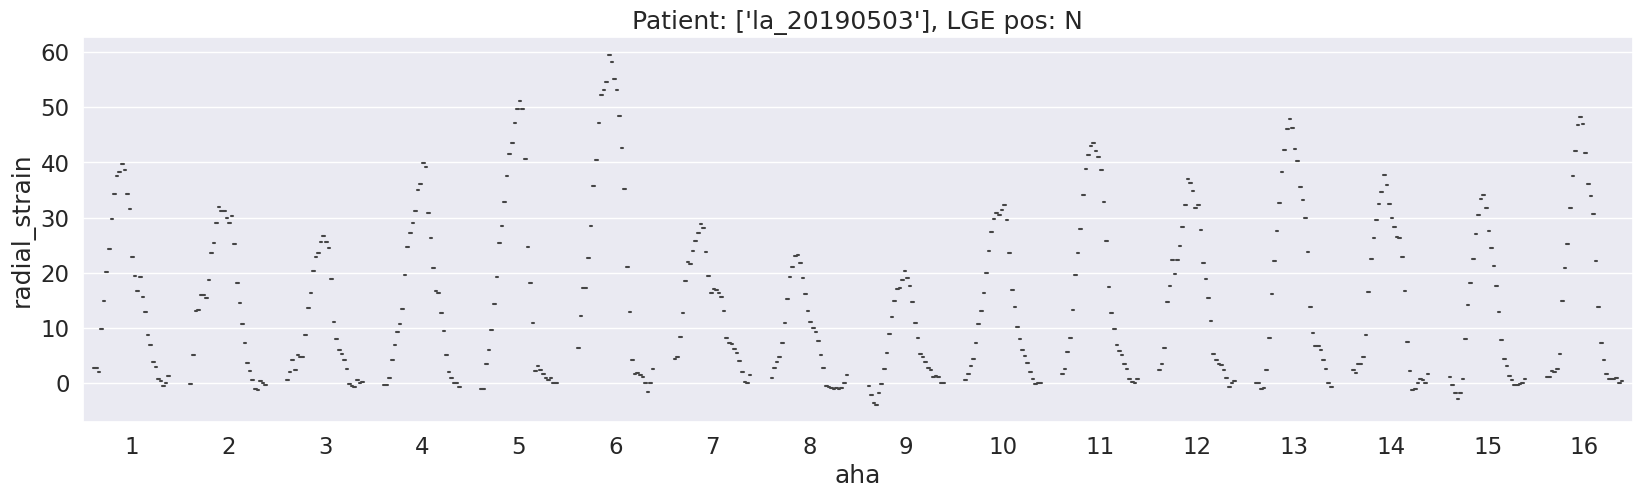

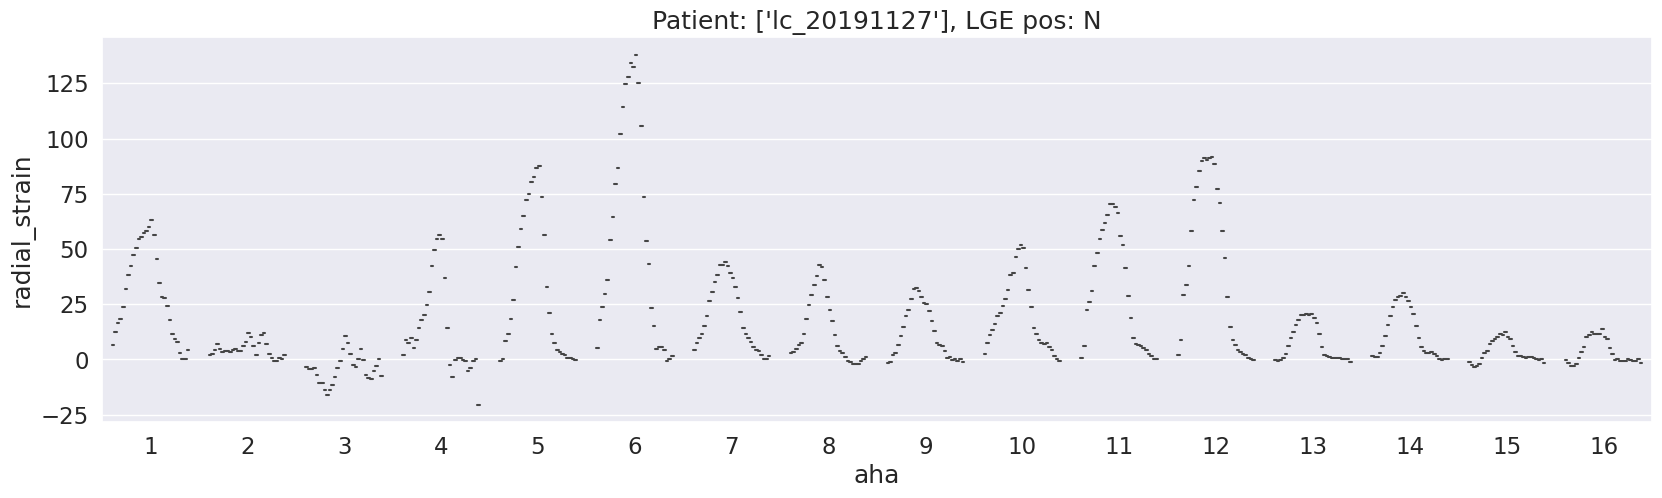

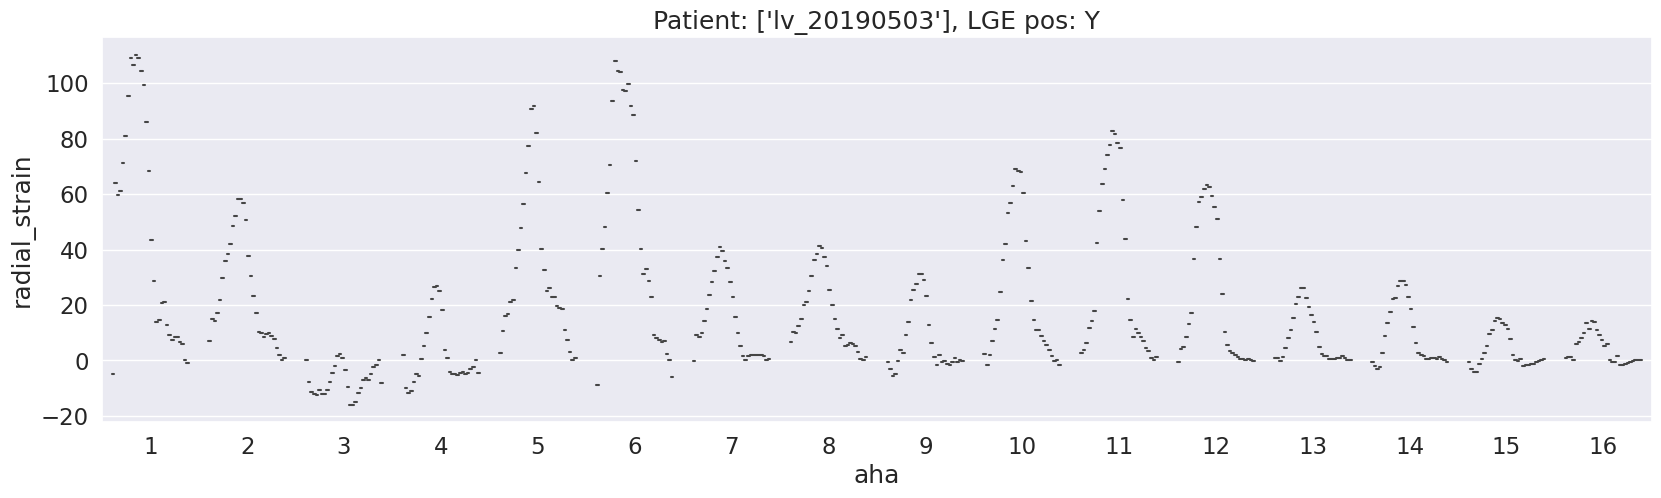

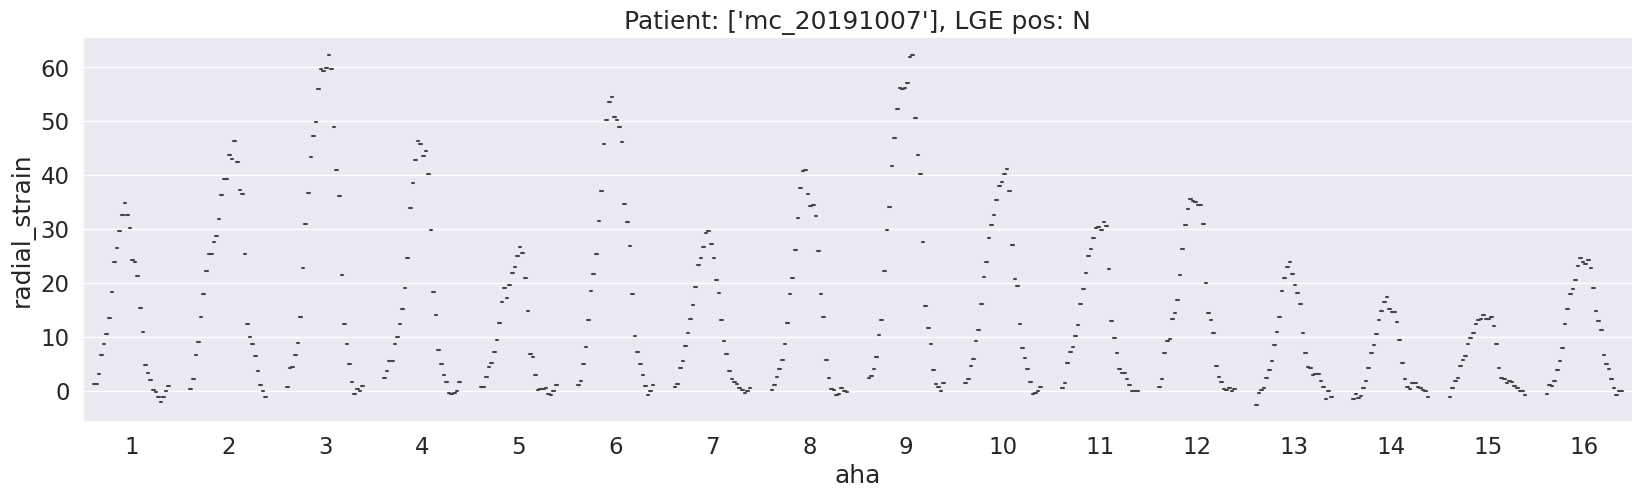

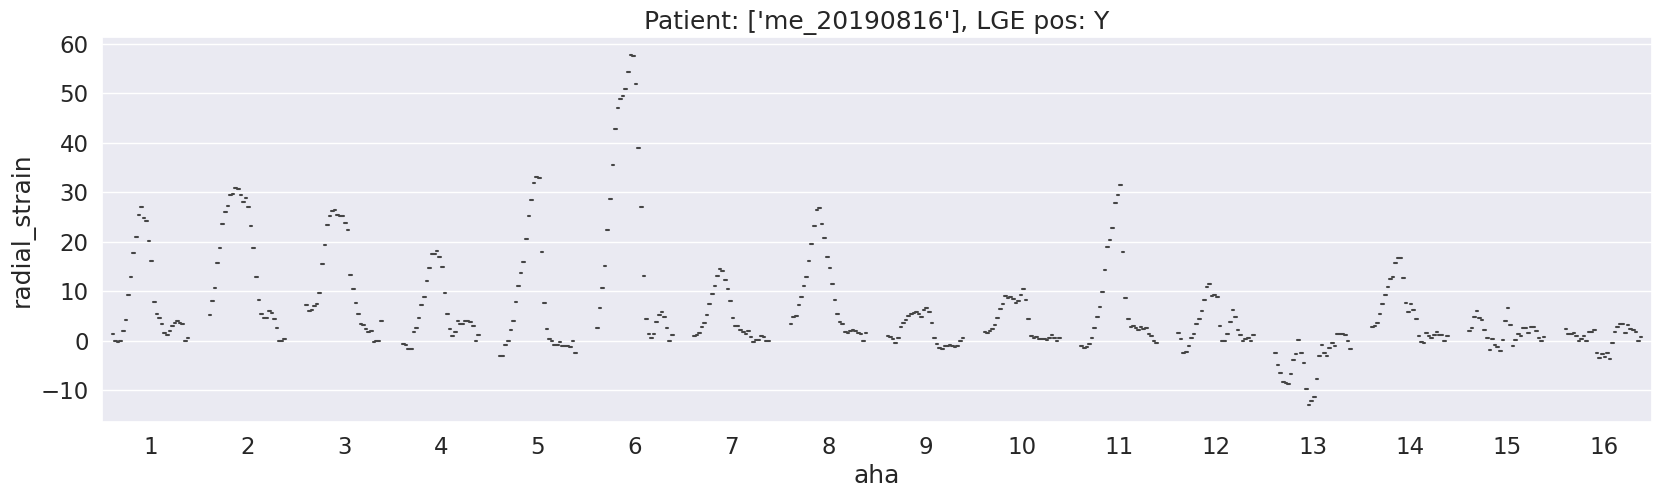

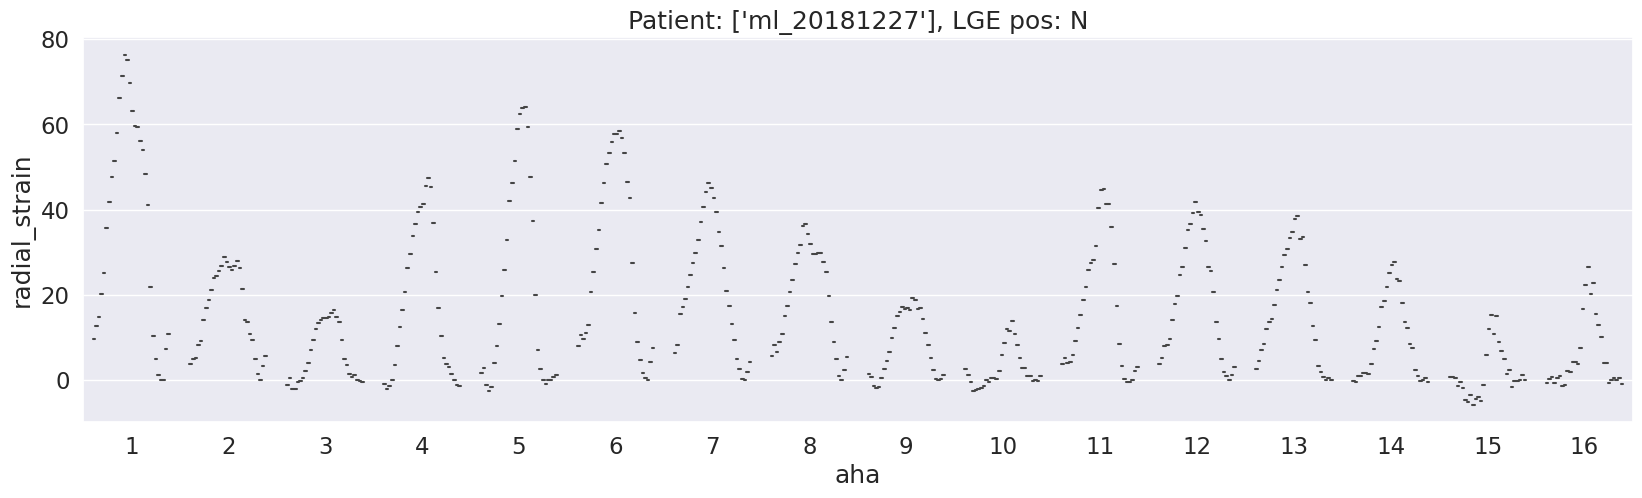

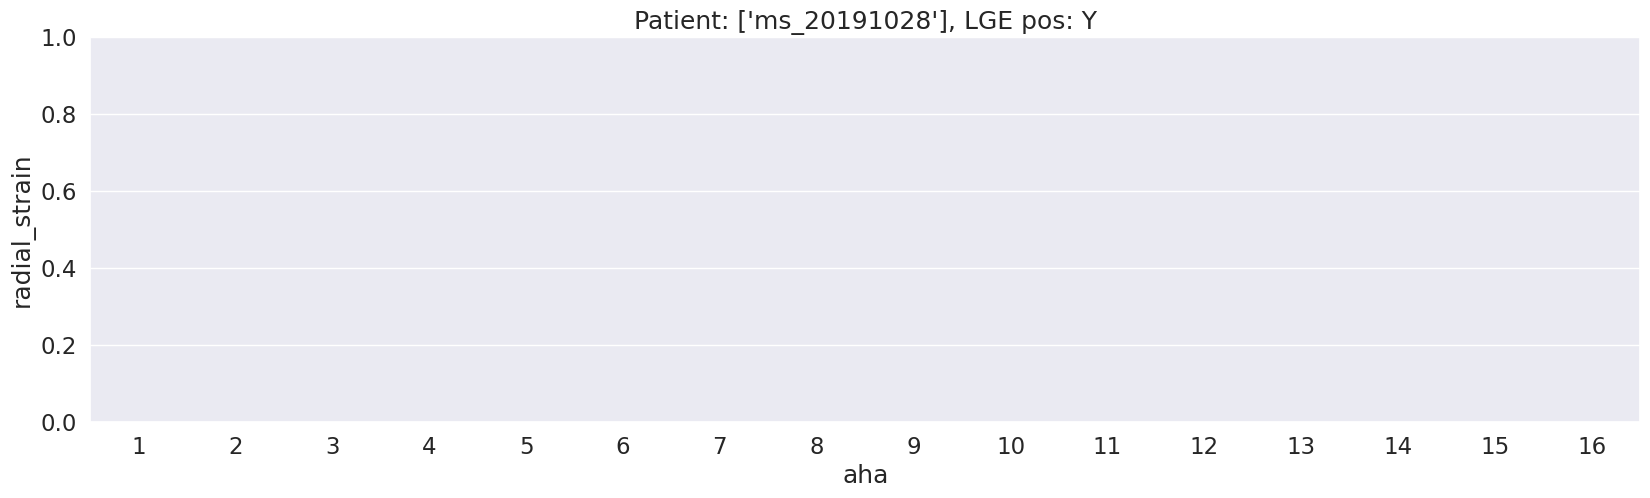

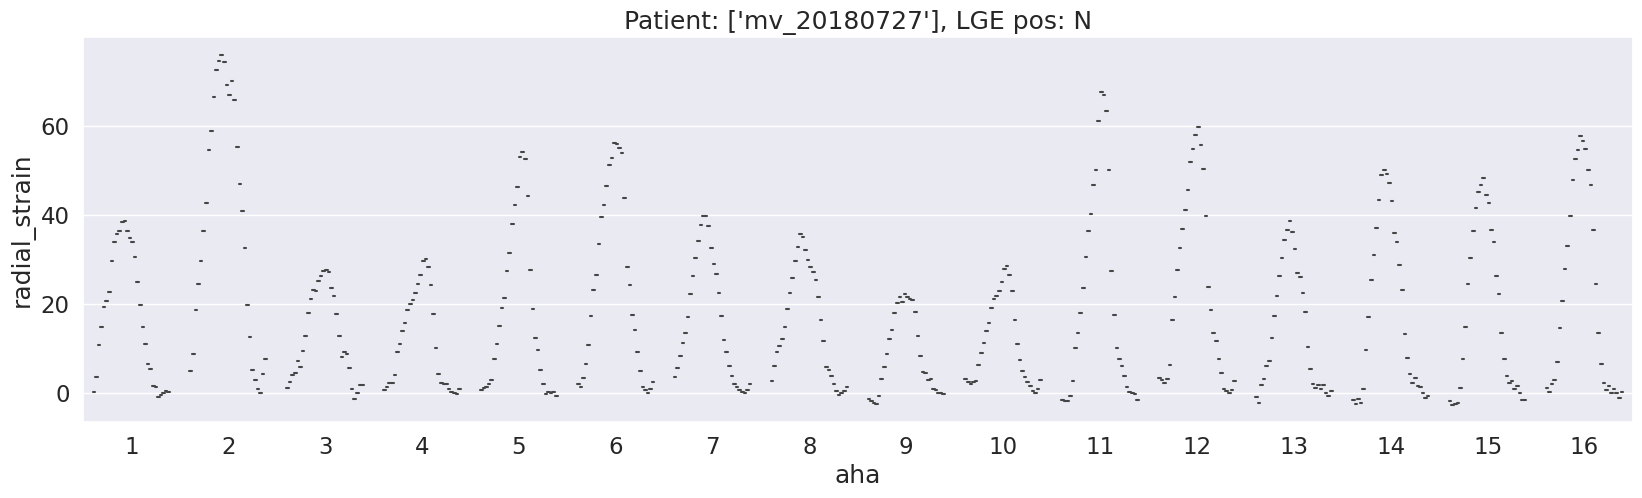

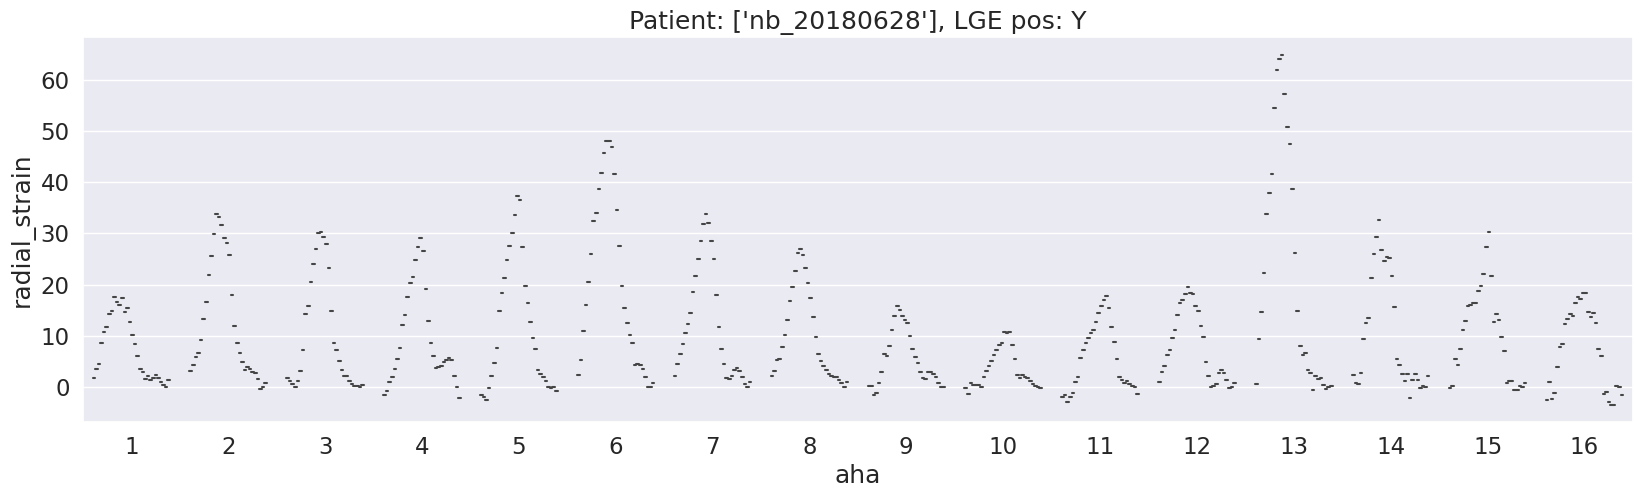

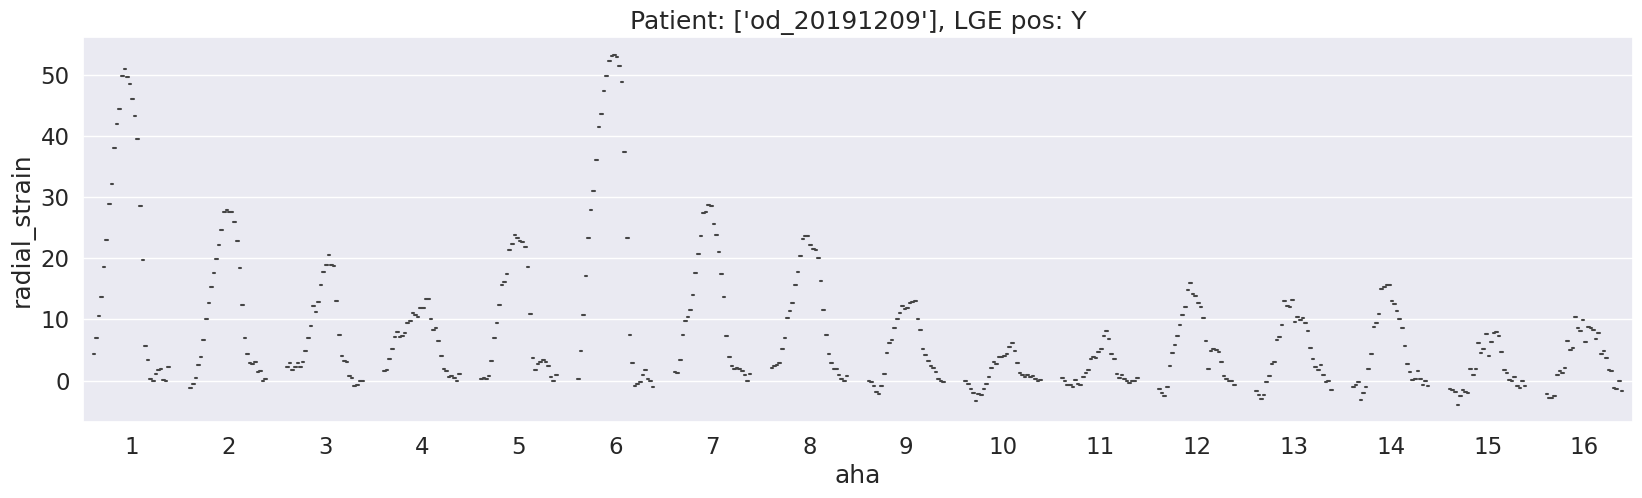

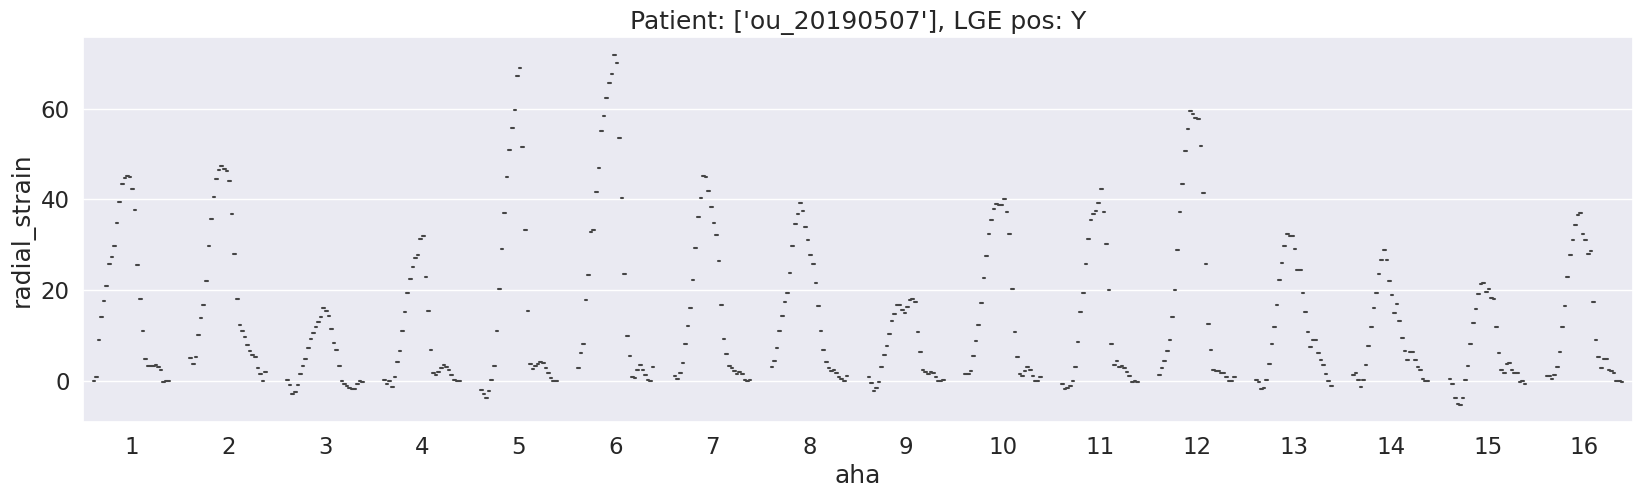

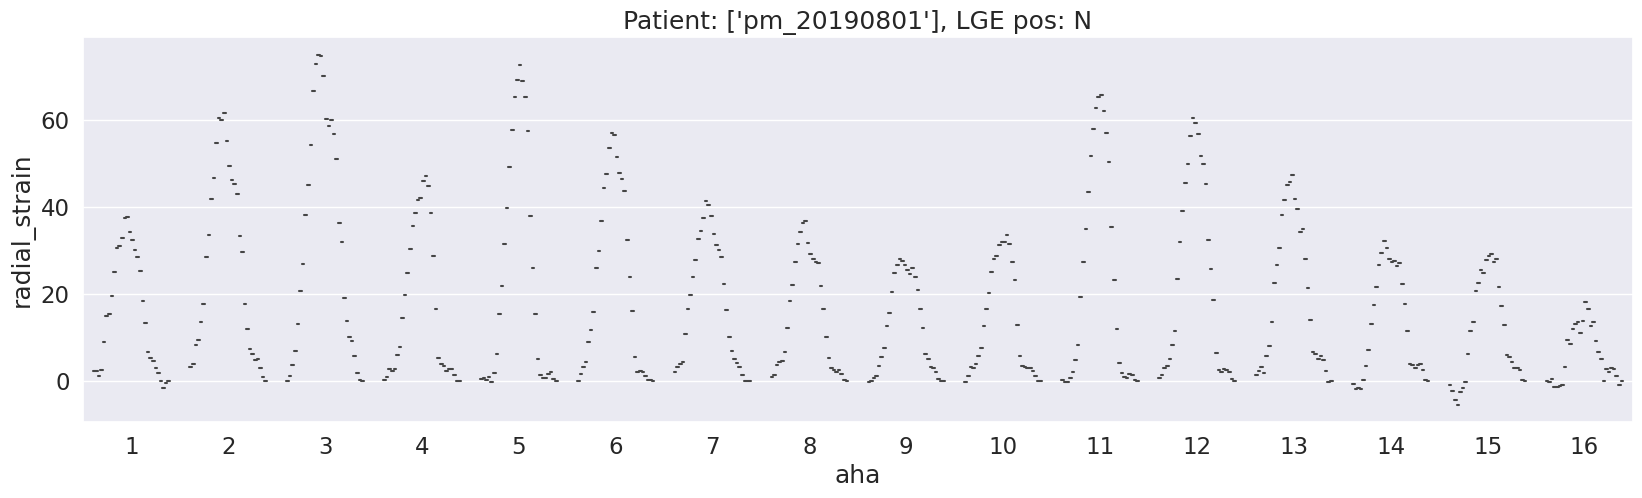

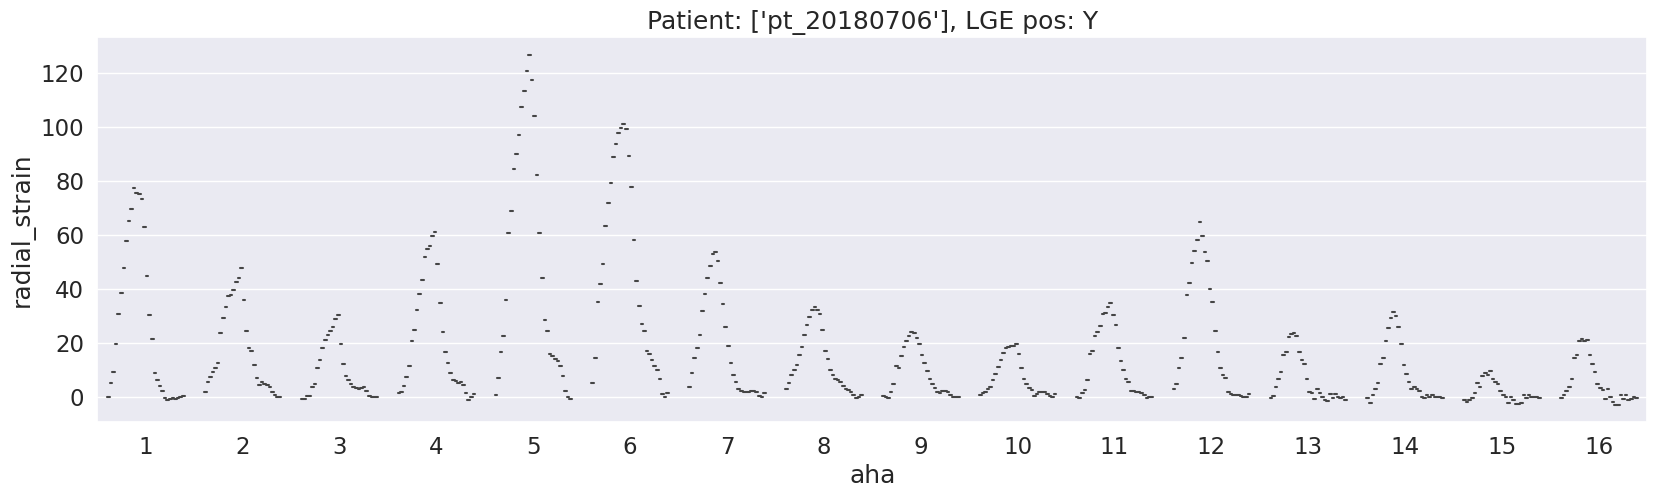

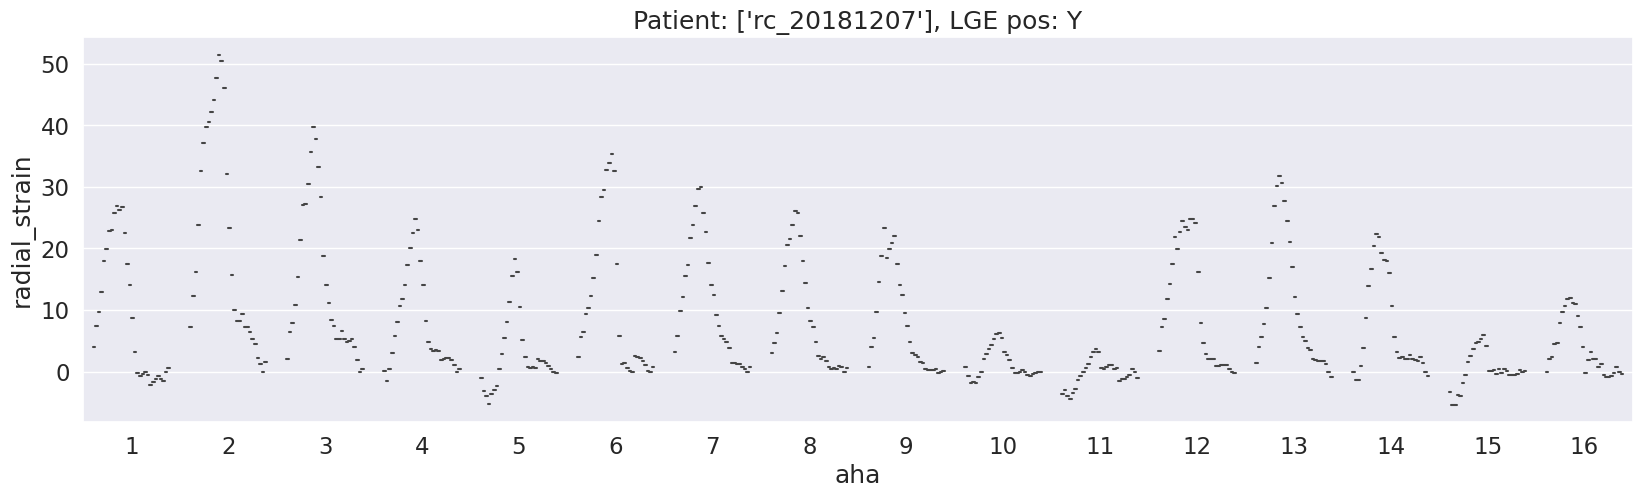

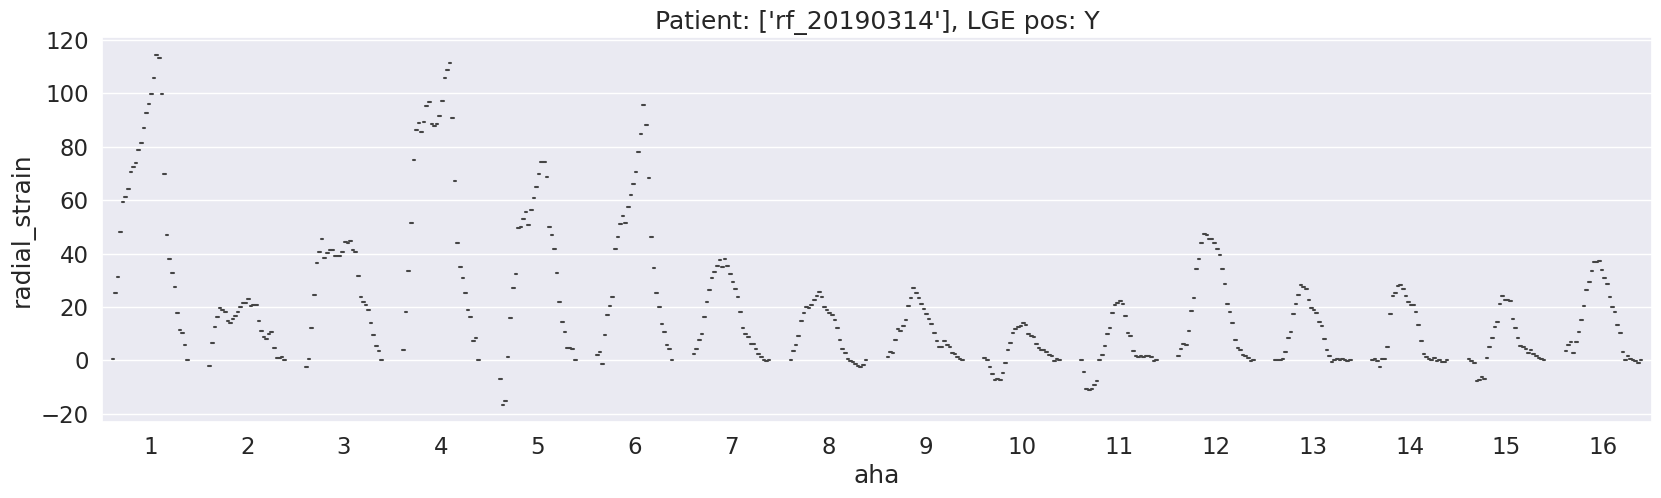

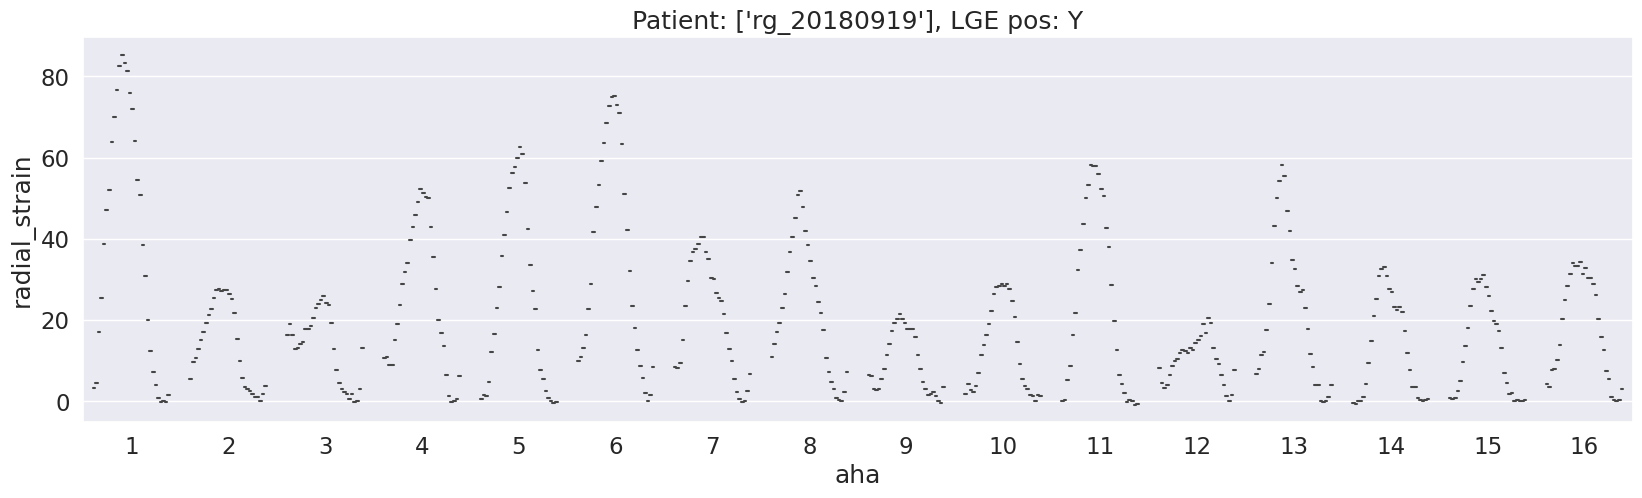

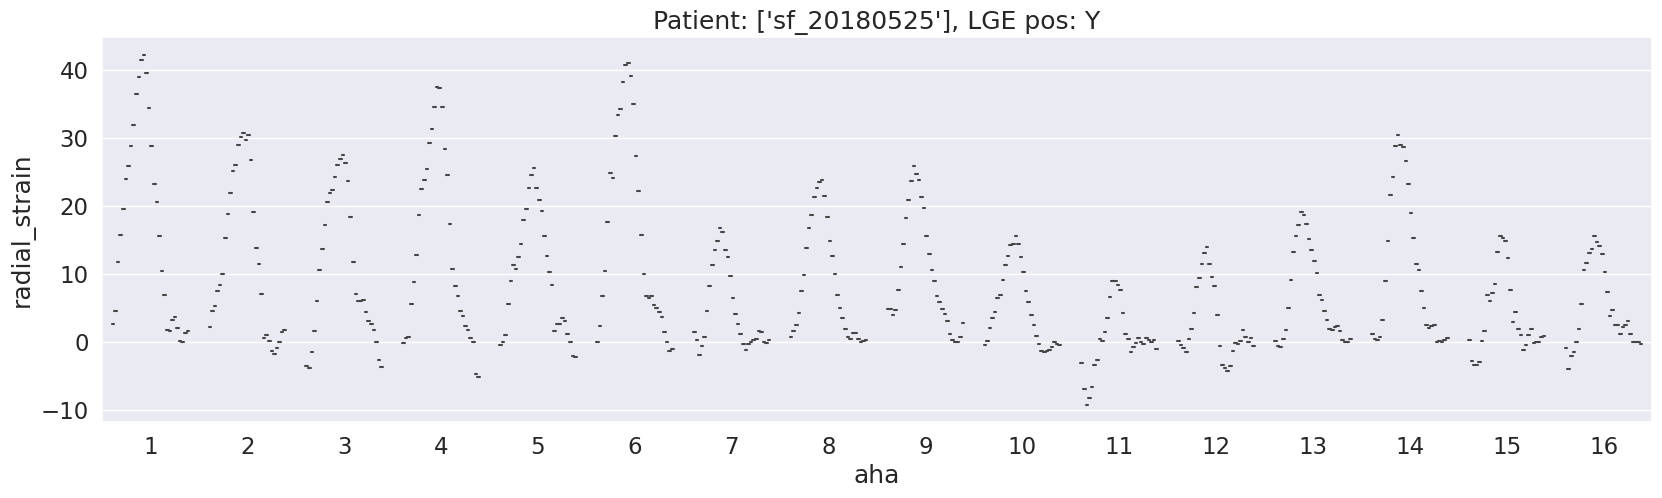

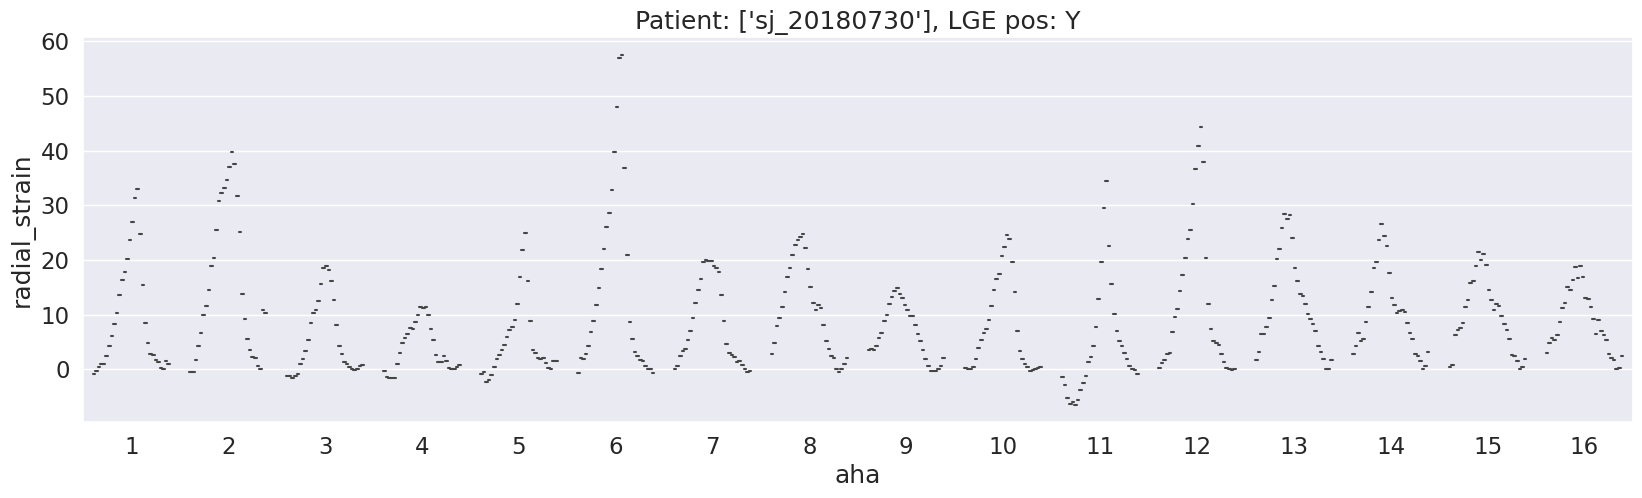

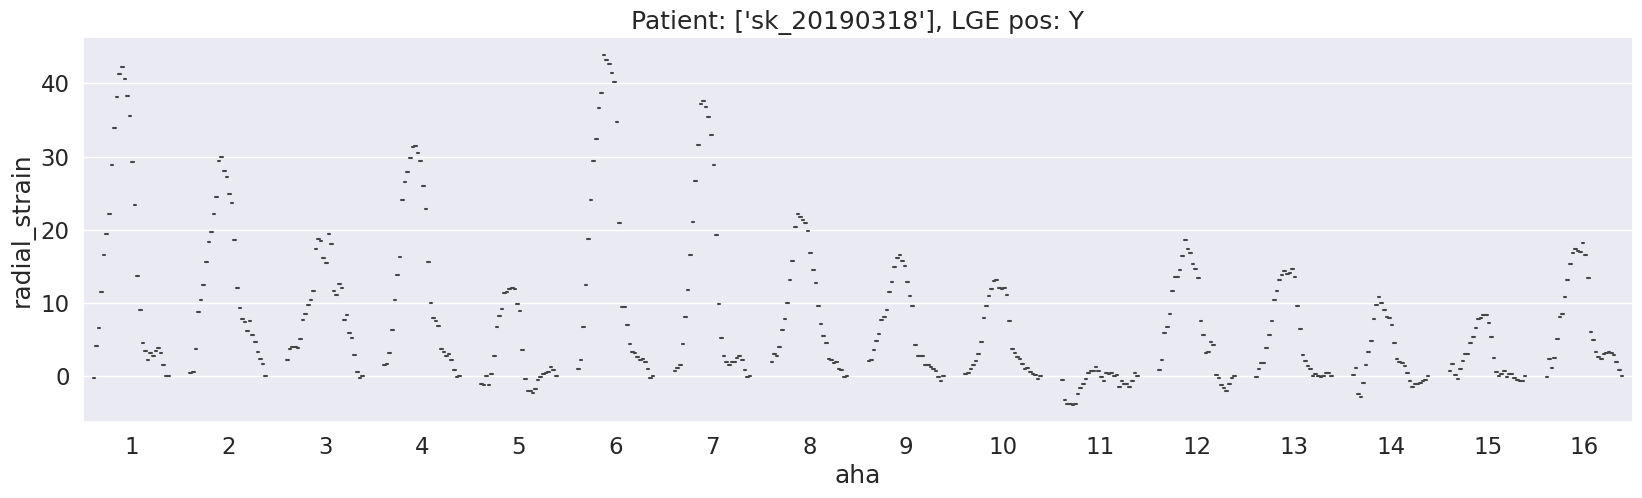

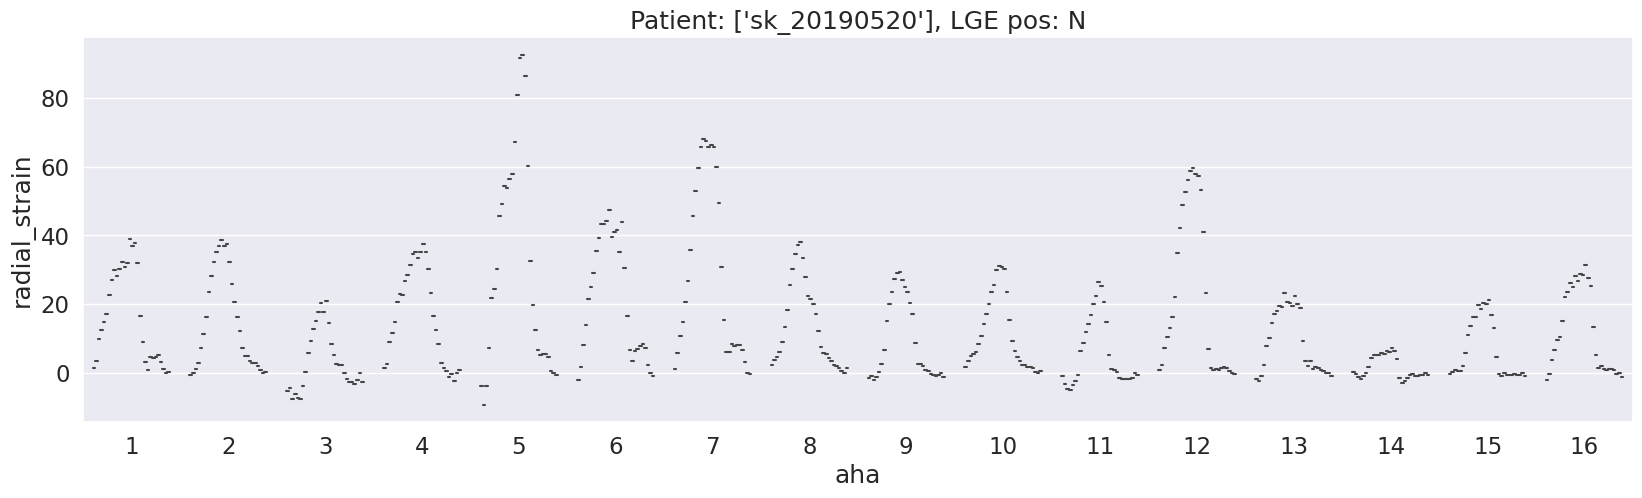

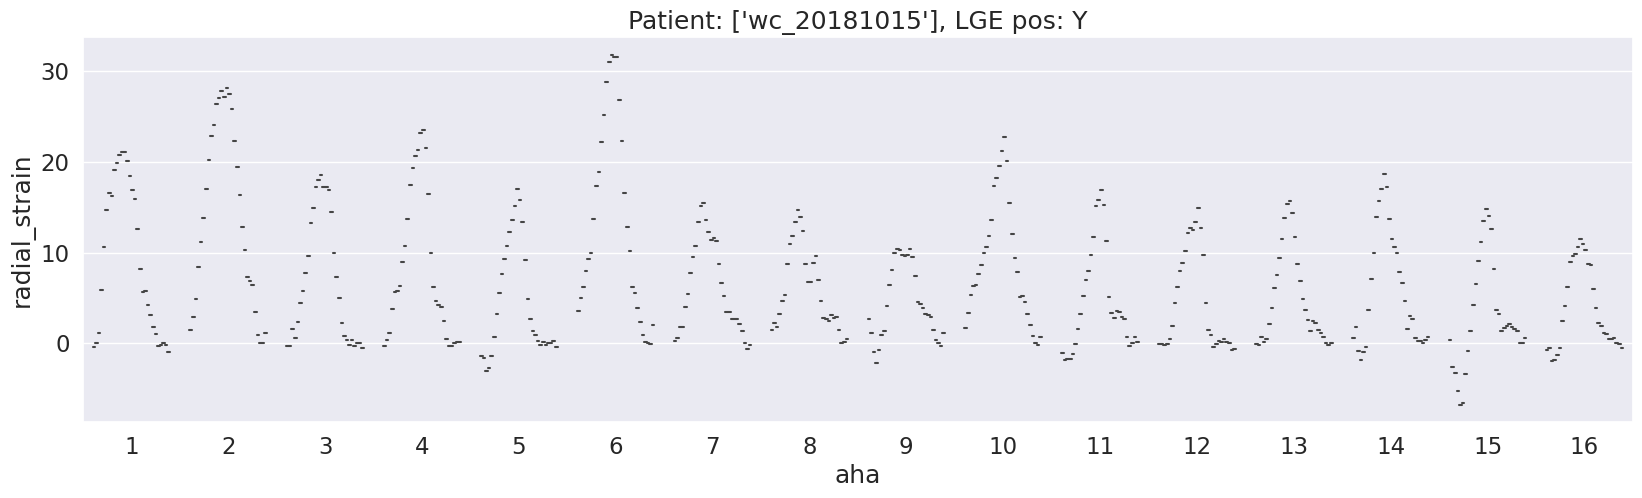

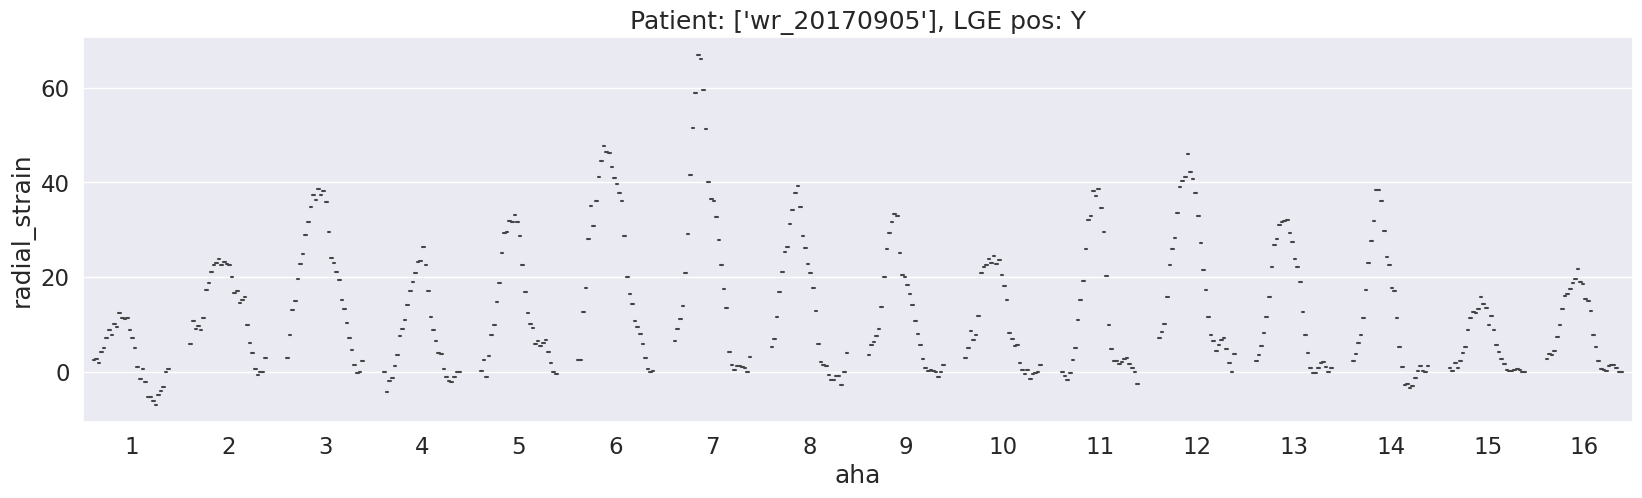

In [58]:
def plot_strain(df, segments=[1]):
    sb.set_context('paper')
    sb.set(font_scale = 1.5)
    fig, ax = plt.subplots(1,1,figsize=(20,5))
    plt.title('Patient: {}, LGE pos: {}'.format(segments, df[df['patient'].isin(segments)].target.values[0]))
    sb.violinplot(x="aha", y="radial_strain",inner='quart',
                     data=df[df['patient'].isin(segments)],
                  ax=ax,
                 hue='frame',
                  #scale_hue=True,
                 #split=True
                 )
    plt.legend([],[], frameon=False)
    plt.show()
_ = [plot_strain(df_merged, segments=[i]) for i in df_merged.patient.unique()]

In [19]:
df_merged.describe() # 27360 = 57 patients x 16 segments x 30 frames

aha  radial_strain   circ_strain  ed_pred_early  \
count  62000.000000   62000.000000  62000.000000   61504.000000   
mean       8.500000      11.497785     -7.011775      26.104839   
std        4.609809      14.393323      7.243935       7.437779   
min        1.000000     -20.510000    -34.678000       0.000000   
25%        4.750000       1.129000    -12.167000      28.000000   
50%        8.500000       6.183500     -5.074500      28.000000   
75%       12.250000      17.672000     -1.047000      29.000000   
max       16.000000     164.404000     45.347000      29.000000   

       ms_pred_early  es_pred_early  pf_pred_early  md_pred_early  \
count   61504.000000   61504.000000   61504.000000   61504.000000   
mean        5.024194      11.459677      17.661290      24.637097   
std         0.902188       1.227381       1.908769       2.476798   
min         1.000000       8.000000      12.000000       1.000000   
25%         5.000000      11.000000      16.000000      24.000000   
50%         5.000000      12.000000      18.000000      25.000000   
75%         5.250000      12.000000      19.000000      26.000000   
max         8.000000      14.000000      22.000000      29.000000   

             weight        height  ...       lv mass          rvef  \
count  62000.000000  62000.000000  ...  61504.000000  61504.000000   
mean      57.869600    146.888000  ...     65.733871     24.956613   
std       24.078304     17.411693  ...     26.034342     28.060725   
min       22.700000     65.800000  ...     27.000000      0.330000   
25%       39.300000    135.300000  ...     50.750000      0.550000   
50%       53.900000    146.900000  ...     59.000000      0.640000   
75%       70.300000    160.000000  ...     74.000000     54.250000   
max      153.900000    182.000000  ...    195.000000     74.000000   

              rvedv         rvesv    reduced ef           ed#           ms#  \
count  61504.000000  61504.000000  61504.000000  62000.000000  62000.000000   
mean      99.169355     43.620968      0.483871     21.832000      4.864000   
std       31.890121     17.456351      0.499744     12.039855      0.949483   
min       49.000000     17.000000      0.000000      0.000000      1.000000   
25%       79.750000     32.000000      0.000000     27.000000      4.000000   
50%       92.000000     41.000000      0.000000     28.000000      5.000000   
75%      111.250000     51.000000      1.000000     29.000000      5.000000   
max      267.000000    132.000000      1.000000     29.000000      8.000000   

                es#           pf#           md#  
count  62000.000000  62000.000000  62000.000000  
mean      11.136000     17.848000     25.184000  
std        1.195628      2.004236      2.440951  
min        8.000000     12.000000      0.000000  
25%       10.000000     17.000000     25.000000  
50%       11.000000     18.000000     25.000000  
75%       12.000000     19.000000     26.000000  
max       14.000000     22.000000     29.000000  

[8 rows x 23 columns]

In [324]:
y = temp[temp.phase==0].sort_values(['pat', 'aha']).groupby('pat')['target'].apply(lambda x: list(x)[0]) # 57 patients
print(y.shape, y.sum(), y.shape[0]-y.sum())

(125,) 76 49


In [325]:
y

pat
aa_201807100    0
aa_201812110    0
ab_201807100    0
ac_201803010    1
ac_201812030    1
               ..
wbw_20211103    1
wc_201810150    1
wjh_20210621    1
wr_201709050    1
zg_202212270    1
Name: target, Length: 125, dtype: int64

In [33]:
df_merged.replace(to_replace=['None', 'None '], value=np.NaN, inplace=True)
df_merged = df_merged.fillna(value='0')
df_merged['radial_strain'] = df_merged.radial_strain.apply(float)
df_merged['circ_strain'] = df_merged.circ_strain.apply(float)

In [20]:
# drop nan rows...
df_merged[['radial_strain', 'circ_strain']].isna().values.any()

False

In [21]:
df_merged.columns

Index(['pat', 'aha', 'frame', 'radial_strain', 'circ_strain', 'pat_x',
       'ed_pred_early', 'ms_pred_early', 'es_pred_early', 'pf_pred_early',
       'md_pred_early', 'pat_y', 'age', 'gender', 'weight', 'height', 'bsa',
       'hr', 'systolic bp', 'diastolic bp', 'lvef', 'lvedv', 'lvesv',
       'lv mass', 'rvef', 'rvedv', 'rvesv', 'reduced ef', 'lgepos_eq',
       'lgepos_', 'lge present', 'nocturnal bipap use',
       'resp support required', 'wheelchair', 'ambulatory', 'steroid use',
       'any med use', 'ace-i', 'arb', 'mra', 'bb', 'soa', 'lgepos', 'target',
       'ed#', 'ms#', 'es#', 'pf#', 'md#', 'patient'],
      dtype='object')

# lge+/lge- classifaction based on different circle strain values

1. select the features of choice
2. start the grid search, which will use the current x and y values
3. Refit an estimator with the best parameters from the gridseach and plot the metrics + SD per split

# Circle RS/CS five keyframes

(54, 80)
(54,) 32 22
(71, 80)
(71,) 44 27
********** MLP **********
[1.         0.83333333 0.57142857 0.85714286 1.        ]
Balanced accuracy: 0.70 (+/- 0.09) [MLP]
Sensitivity: 0.85 (+/- 0.16) [MLP]
Specifity: 0.54 (+/- 0.21) [MLP]
********** Logistic Regression **********
[0.33333333 0.83333333 0.71428571 0.71428571 0.83333333]
Balanced accuracy: 0.51 (+/- 0.19) [Logistic Regression]
Sensitivity: 0.69 (+/- 0.18) [Logistic Regression]
Specifity: 0.33 (+/- 0.26) [Logistic Regression]
********** Random Forest **********
[1.         0.83333333 0.57142857 0.71428571 0.83333333]
Balanced accuracy: 0.56 (+/- 0.07) [Random Forest]
Sensitivity: 0.79 (+/- 0.14) [Random Forest]
Specifity: 0.33 (+/- 0.19) [Random Forest]
********** Naive Bayes **********
[0.83333333 0.66666667 0.57142857 0.71428571 0.66666667]
Balanced accuracy: 0.64 (+/- 0.09) [Naive Bayes]
Sensitivity: 0.69 (+/- 0.09) [Naive Bayes]
Specifity: 0.59 (+/- 0.22) [Naive Bayes]
********** Scaled DecissionTree **********
[0.5       

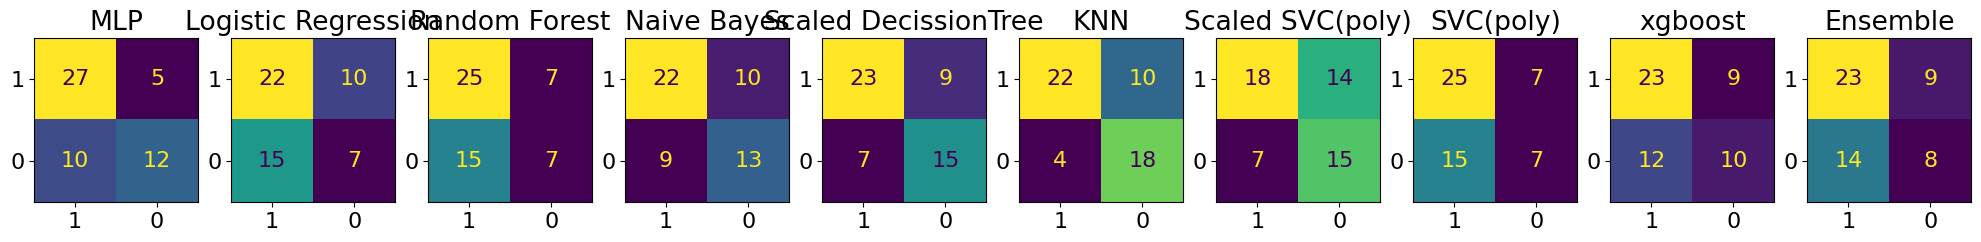

In [178]:
# radial and circ strain per segment and frame 16 x time x 2
select_split = [1]
pat_train = temp.first_split.isin(select_split)

# train
y_train = temp_key[(temp_key.phase==0) & (pat_train)].sort_values(['pat', 'aha']).groupby('pat')['target'].apply(lambda x: list(x)[0])
#x = np.stack(temp[pat_train].sort_values(['pat','aha']).groupby(['pat'])['our_rs'].apply(list).values).astype(np.float32) # 57 patient a 480 features (16 segments x 30 frames)
x2 = np.stack(temp_key[pat_train].sort_values(['pat', 'aha']).groupby(['pat'])['our_cs'].apply(list).values).astype(np.float32) # 57 patient a 480 features (16 segments x 30 frames)
#x_train = np.concatenate([x,x2], axis=1) # 480 + 480 = 960
x_train = x2

# test
y_test = temp_key[(temp_key.phase==0) & ~(pat_train)].sort_values(['pat', 'aha']).groupby('pat')['target'].apply(lambda x: list(x)[0])
#x = np.stack(temp[~pat_train].sort_values(['pat','aha']).groupby(['pat'])['our_rs'].apply(list).values).astype(np.float32) # 57 patient a 480 features (16 segments x 30 frames)
x2 = np.stack(temp_key[~pat_train].sort_values(['pat', 'aha']).groupby(['pat'])['our_cs'].apply(list).values).astype(np.float32) # 57 patient a 480 features (16 segments x 30 frames)
#x_test = np.concatenate([x,x2], axis=1) # 480 + 480 = 960
x_test = x2
print(x_train.shape)
print(y_train.shape, y_train.sum(), y_train.shape[0]-y_train.sum())

print(x_test.shape)
print(y_test.shape, y_test.sum(), y_test.shape[0]-y_test.sum())
x_train = np.nan_to_num(x_train)
cross_validate_f1(x_train,y_train)

# Circle all frames - CS,RS

(54, 480)
(54,) 32 22
(71, 480)
(71,) 44 27
********** MLP **********
[0.83333333 0.83333333 0.57142857 0.71428571 0.83333333]
Balanced accuracy: 0.55 (+/- 0.15) [MLP]
Sensitivity: 0.76 (+/- 0.10) [MLP]
Specifity: 0.35 (+/- 0.28) [MLP]
********** Logistic Regression **********
[0.5        0.5        0.71428571 0.85714286 0.83333333]
Balanced accuracy: 0.48 (+/- 0.09) [Logistic Regression]
Sensitivity: 0.68 (+/- 0.16) [Logistic Regression]
Specifity: 0.27 (+/- 0.17) [Logistic Regression]
********** Random Forest **********
[1.         0.83333333 0.71428571 0.71428571 0.83333333]
Balanced accuracy: 0.54 (+/- 0.11) [Random Forest]
Sensitivity: 0.82 (+/- 0.10) [Random Forest]
Specifity: 0.27 (+/- 0.17) [Random Forest]
********** Naive Bayes **********
[1.         0.66666667 0.42857143 0.71428571 0.66666667]
Balanced accuracy: 0.62 (+/- 0.15) [Naive Bayes]
Sensitivity: 0.70 (+/- 0.18) [Naive Bayes]
Specifity: 0.55 (+/- 0.27) [Naive Bayes]
********** Scaled DecissionTree **********
[0.5     

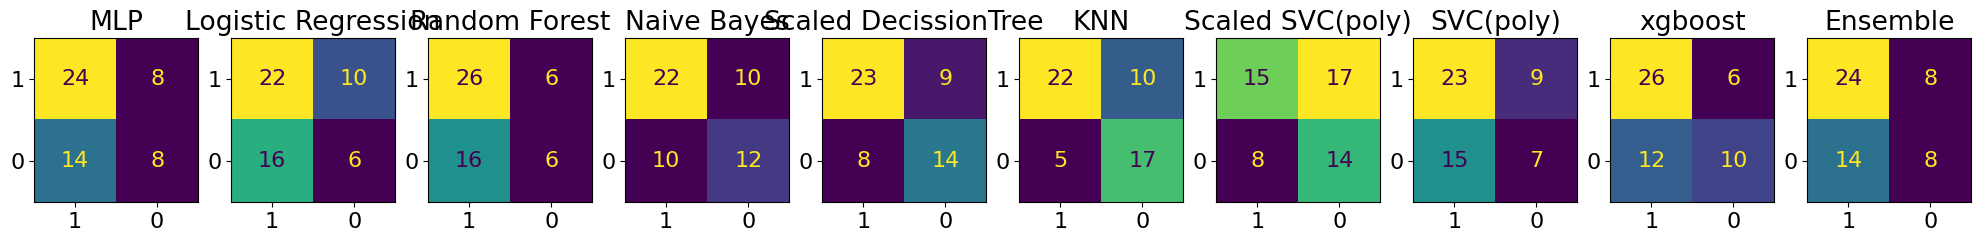

In [168]:
# radial and circ strain per segment and frame 16 x time x 2
select_split = [1]
pat_train = temp.first_split.isin(select_split)

# train
y_train = temp[(temp.phase==0) & (pat_train)].sort_values(['pat', 'aha']).groupby('pat')['target'].apply(lambda x: list(x)[0])
x = np.stack(temp[pat_train].sort_values(['pat','aha']).groupby(['pat'])['our_rs'].apply(list).values).astype(np.float32) # 57 patient a 480 features (16 segments x 30 frames)
x2 = np.stack(temp[pat_train].sort_values(['pat', 'aha']).groupby(['pat'])['our_cs'].apply(list).values).astype(np.float32) # 57 patient a 480 features (16 segments x 30 frames)
x_train = np.concatenate([x,x2], axis=1) # 480 + 480 = 960

# test
y_test = temp[(temp.phase==0) & ~(pat_train)].sort_values(['pat', 'aha']).groupby('pat')['target'].apply(lambda x: list(x)[0])
x = np.stack(temp[~pat_train].sort_values(['pat','aha']).groupby(['pat'])['our_rs'].apply(list).values).astype(np.float32) # 57 patient a 480 features (16 segments x 30 frames)
x2 = np.stack(temp[~pat_train].sort_values(['pat', 'aha']).groupby(['pat'])['our_cs'].apply(list).values).astype(np.float32) # 57 patient a 480 features (16 segments x 30 frames)
x_test = np.concatenate([x,x2], axis=1) # 480 + 480 = 960

print(x_train.shape)
print(y_train.shape, y_train.sum(), y_train.shape[0]-y_train.sum())

print(x_test.shape)
print(y_test.shape, y_test.sum(), y_test.shape[0]-y_test.sum())
x_train = np.nan_to_num(x_train)
cross_validate_f1(x_train,y_train)

# Circle all frames - CS

In [327]:
# radial and circ strain per segment and frame 16 x time x 2
select_split = [1]
pat_train = temp.first_split.isin(select_split)

# train
y_train = temp[(temp.phase==0) & (pat_train)].sort_values(['pat', 'aha']).groupby('pat')['target'].apply(lambda x: list(x)[0])
#x = np.stack(temp[pat_train].sort_values(['pat','aha']).groupby(['pat'])['our_rs'].apply(list).values).astype(np.float32) # 57 patient a 480 features (16 segments x 30 frames)
x2 = np.stack(temp[pat_train].sort_values(['pat', 'aha']).groupby(['pat'])['our_cs'].apply(list).values).astype(np.float32) # 57 patient a 480 features (16 segments x 30 frames)
#x_train = np.concatenate([x,x2], axis=1) # 480 + 480 = 960
x_train = x2#

# test
y_test = temp[(temp.phase==0) & ~(pat_train)].sort_values(['pat', 'aha']).groupby('pat')['target'].apply(lambda x: list(x)[0])
#x = np.stack(temp[~pat_train].sort_values(['pat','aha']).groupby(['pat'])['our_rs'].apply(list).values).astype(np.float32) # 57 patient a 480 features (16 segments x 30 frames)
x2 = np.stack(temp[~pat_train].sort_values(['pat', 'aha']).groupby(['pat'])['our_cs'].apply(list).values).astype(np.float32) # 57 patient a 480 features (16 segments x 30 frames)
#x_test = np.concatenate([x,x2], axis=1) # 480 + 480 = 960
x_test = x2
print(x_train.shape)
print(y_train.shape, y_train.sum(), y_train.shape[0]-y_train.sum())

print(x_test.shape)
print(y_test.shape, y_test.sum(), y_test.shape[0]-y_test.sum())
#x_train = np.nan_to_num(x_train)
#cross_validate_f1(x_train,y_train)

(54, 480)
(54,) 32 22
(71, 480)
(71,) 44 27


# Circle all frames - RS

In [334]:
# radial and circ strain per segment and frame 16 x time x 2
select_split = [1]
pat_train = temp.first_split.isin(select_split)

# train
y_train = temp[(temp.phase==0) & (pat_train)].sort_values(['pat', 'aha']).groupby('pat')['target'].apply(lambda x: list(x)[0])
x2 = np.stack(temp[pat_train].sort_values(['pat', 'aha']).groupby(['pat'])['our_rs'].apply(list).values).astype(np.float32) # 57 patient a 480 features (16 segments x 30 frames)
x_train = x2

# test
y_test = temp[(temp.phase==0) & ~(pat_train)].sort_values(['pat', 'aha']).groupby('pat')['target'].apply(lambda x: list(x)[0])
x2 = np.stack(temp[~pat_train].sort_values(['pat', 'aha']).groupby(['pat'])['our_rs'].apply(list).values).astype(np.float32) # 57 patient a 480 features (16 segments x 30 frames)
x_test = x2
print(x_train.shape)
print(y_train.shape, y_train.sum(), y_train.shape[0]-y_train.sum())

print(x_test.shape)
print(y_test.shape, y_test.sum(), y_test.shape[0]-y_test.sum())
#x_train = np.nan_to_num(x_train)
#cross_validate_f1(x_train,y_train)

(54, 480)
(54,) 32 22
(71, 480)
(71,) 44 27


# Circle peak by phase - RS/CS

In [270]:
# Peak radial and circ strain per segment 16 x 2
select_split = [1]
pat_train = temp.first_split.isin(select_split)

# train
y_train = temp[(temp.phase==0) & (pat_train)].sort_values(['pat', 'aha']).groupby('pat')['target'].apply(lambda x: list(x)[0])
x = np.stack(temp_key[pat_train][temp_key.phase==2].sort_values(['pat','aha']).groupby(['pat'])['our_rs'].apply(list).values).astype(np.float32)
x2 = np.stack(temp_key[pat_train][temp_key.phase==2].sort_values(['pat','aha']).groupby(['pat'])['our_cs'].apply(list).values).astype(np.float32)
x_train = np.concatenate([x,x2], axis=1) # 480 + 480 = 960

# test
y_test = temp[(temp.phase==0) & ~(pat_train)].sort_values(['pat', 'aha']).groupby('pat')['target'].apply(lambda x: list(x)[0])
x = np.stack(temp_key[~pat_train][temp_key.phase==2].sort_values(['pat','aha']).groupby(['pat'])['our_rs'].apply(list).values).astype(np.float32)
x2 = np.stack(temp_key[~pat_train][temp_key.phase==2].sort_values(['pat','aha']).groupby(['pat'])['our_cs'].apply(list).values).astype(np.float32)
x_test = np.concatenate([x,x2], axis=1) # 480 + 480 = 960
print(x_train.shape)
print(y_train.shape, y_train.sum(), y_train.shape[0]-y_train.sum())

print(x_test.shape)
print(y_test.shape, y_test.sum(), y_test.shape[0]-y_test.sum())
x_train = np.nan_to_num(x_train)
#cross_validate_f1(x_train,y_train)

(54, 32)
(54,) 32 22
(71, 32)
(71,) 44 27


# Circle peak - RS/CS 

In [260]:
# Peak radial and circ strain per segment 16 x 2
select_split = [1]
pat_train = temp.first_split.isin(select_split)

# train
y_train = temp[(temp.phase==0) & (pat_train)].sort_values(['pat', 'aha']).groupby('pat')['target'].apply(lambda x: list(x)[0])
x = np.stack(temp[pat_train].sort_values(['pat','aha']).groupby(['pat','aha'])['our_rs'].apply(lambda x: max(list(x))).values).astype(np.float32).reshape((y_train.shape[0],16)) # patient a 480 features (16 segments x 30 frames)
x2 = np.stack(temp[pat_train].sort_values(['pat', 'aha']).groupby(['pat','aha'])['our_cs'].apply(lambda x: min(list(x))).values).astype(np.float32).reshape((y_train.shape[0],16)) # 57 patient a 480 features (16 segments x 30 frames)
x_train = np.concatenate([x,x2], axis=1) # 480 + 480 = 960

# test
y_test = temp[(temp.phase==0) & ~(pat_train)].sort_values(['pat', 'aha']).groupby('pat')['target'].apply(lambda x: list(x)[0])
x = np.stack(temp[~pat_train].sort_values(['pat','aha']).groupby(['pat','aha'])['our_rs'].apply(lambda x: max(list(x))).values).astype(np.float32).reshape((y_test.shape[0],16)) # 57 patient a 480 features (16 segments x 30 frames)
x2 = np.stack(temp[~pat_train].sort_values(['pat', 'aha']).groupby(['pat','aha'])['our_cs'].apply(lambda x: min(list(x))).values).astype(np.float32).reshape((y_test.shape[0],16)) # 57 patient a 480 features (16 segments x 30 frames)
x_test = np.concatenate([x,x2], axis=1) # 480 + 480 = 960
print(x_train.shape)
print(y_train.shape, y_train.sum(), y_train.shape[0]-y_train.sum())

print(x_test.shape)
print(y_test.shape, y_test.sum(), y_test.shape[0]-y_test.sum())
x_train = np.nan_to_num(x_train)
#cross_validate_f1(x_train,y_train)

(54, 32)
(54,) 32 22
(71, 32)
(71,) 44 27


# Circle peak - CS

In [22]:
# Peak radial and circ strain per segment 16 x 2
select_split = [1]
pat_train = temp.first_split.isin(select_split)

# train
y_train = temp[(temp.phase==0) & (pat_train)].sort_values(['pat', 'aha']).groupby('pat')['target'].apply(lambda x: list(x)[0])
x_train = np.stack(temp[pat_train].sort_values(['pat', 'aha']).groupby(['pat','aha'])['our_cs'].apply(lambda x: min(list(x))).values).astype(np.float32).reshape((y_train.shape[0],16)) 

# test
y_test = temp[(temp.phase==0) & ~(pat_train)].sort_values(['pat', 'aha']).groupby('pat')['target'].apply(lambda x: list(x)[0])
x_test = np.stack(temp[~pat_train].sort_values(['pat', 'aha']).groupby(['pat','aha'])['our_cs'].apply(lambda x: min(list(x))).values).astype(np.float32).reshape((y_test.shape[0],16)) # 57 patient a 480 features (16 segments x 30 frames)

print(x_train.shape)
print(y_train.shape, y_train.sum(), y_train.shape[0]-y_train.sum())

print(x_test.shape)
print(y_test.shape, y_test.sum(), y_test.shape[0]-y_test.sum())
x_train = np.nan_to_num(x_train)
#cross_validate_f1(x_train,y_train)

(54, 16)
(54,) 32 22
(71, 16)
(71,) 44 27


# Circle peak 5 most common segments - CS

(54, 6)
(54,) 32 22
(71, 6)
(71,) 44 27
********** MLP **********
[0.5        0.66666667 0.85714286 0.71428571 0.66666667]
Balanced accuracy: 0.58 (+/- 0.17) [MLP]
Sensitivity: 0.68 (+/- 0.11) [MLP]
Specifity: 0.47 (+/- 0.30) [MLP]
********** Logistic Regression **********
[0.66666667 0.5        0.57142857 0.71428571 0.66666667]
Balanced accuracy: 0.55 (+/- 0.12) [Logistic Regression]
Sensitivity: 0.62 (+/- 0.08) [Logistic Regression]
Specifity: 0.47 (+/- 0.18) [Logistic Regression]
********** Random Forest **********
[1.         0.83333333 0.85714286 0.85714286 0.83333333]
Balanced accuracy: 0.67 (+/- 0.10) [Random Forest]
Sensitivity: 0.88 (+/- 0.06) [Random Forest]
Specifity: 0.47 (+/- 0.24) [Random Forest]
********** Naive Bayes **********
[0.83333333 0.66666667 0.71428571 0.71428571 0.66666667]
Balanced accuracy: 0.63 (+/- 0.11) [Naive Bayes]
Sensitivity: 0.72 (+/- 0.06) [Naive Bayes]
Specifity: 0.54 (+/- 0.26) [Naive Bayes]
********** Scaled DecissionTree **********
[0.66666667 0

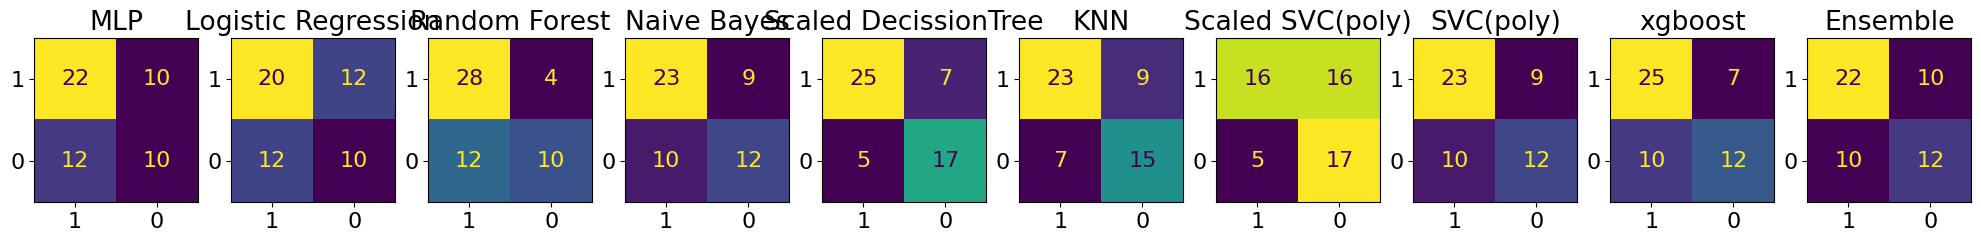

In [277]:
# Peak radial and circ strain per segment 16 x 2
select_split = [1]
pat_train = temp.first_split.isin(select_split)

# train
y_train = temp[(temp.phase==0) & (pat_train)].sort_values(['pat', 'aha']).groupby('pat')['target'].apply(lambda x: list(x)[0])
x_train = np.stack(temp[pat_train].sort_values(['pat', 'aha']).groupby(['pat','aha'])['our_cs'].apply(lambda x: min(list(x))).values).astype(np.float32).reshape((y_train.shape[0],16)) 

# test
y_test = temp[(temp.phase==0) & ~(pat_train)].sort_values(['pat', 'aha']).groupby('pat')['target'].apply(lambda x: list(x)[0])
x_test = np.stack(temp[~pat_train].sort_values(['pat', 'aha']).groupby(['pat','aha'])['our_cs'].apply(lambda x: min(list(x))).values).astype(np.float32).reshape((y_test.shape[0],16)) # 57 patient a 480 features (16 segments x 30 frames)

x_train = x_train[:,[3,4,5,9,10,11]]
x_test = x_test[:,[3,4,5,9,10,11]]

print(x_train.shape)
print(y_train.shape, y_train.sum(), y_train.shape[0]-y_train.sum())

print(x_test.shape)
print(y_test.shape, y_test.sum(), y_test.shape[0]-y_test.sum())
x_train = np.nan_to_num(x_train)
#cross_validate_f1(x_train,y_train)

# Circle peak - RS

In [29]:
# Peak radial and circ strain per segment 16 x 2
select_split = [1]
pat_train = temp.first_split.isin(select_split)

# train
y_train = temp[(temp.phase==0) & (pat_train)].sort_values(['pat', 'aha']).groupby('pat')['target'].apply(lambda x: list(x)[0])
x_train = np.stack(temp[pat_train].sort_values(['pat', 'aha']).groupby(['pat','aha'])['our_rs'].apply(lambda x: min(list(x))).values).astype(np.float32).reshape((y_train.shape[0],16)) 

# test
y_test = temp[(temp.phase==0) & ~(pat_train)].sort_values(['pat', 'aha']).groupby('pat')['target'].apply(lambda x: list(x)[0])
x_test = np.stack(temp[~pat_train].sort_values(['pat', 'aha']).groupby(['pat','aha'])['our_rs'].apply(lambda x: min(list(x))).values).astype(np.float32).reshape((y_test.shape[0],16)) # 57 patient a 480 features (16 segments x 30 frames)

print(x_train.shape)
print(y_train.shape, y_train.sum(), y_train.shape[0]-y_train.sum())

print(x_test.shape)
print(y_test.shape, y_test.sum(), y_test.shape[0]-y_test.sum())
x_train = np.nan_to_num(x_train)
#cross_validate_f1(x_train,y_train)

(54, 16)
(54,) 32 22
(71, 16)
(71,) 44 27


In [79]:
# Peak radial and circ strain per patient
x = np.stack(df_merged.sort_values(['pat']).groupby(['pat','aha'])['radial_strain'].apply(lambda x: np.mean(list(x))).values).astype(np.float32).reshape((y.shape[0],16))
x = np.max(x, axis=1)
x2 = np.stack(df_merged.sort_values(['pat']).groupby(['pat','aha'])['circ_strain'].apply(lambda x: np.mean(list(x))).values).astype(np.float32).reshape((y.shape[0],16))
x2 = np.min(x2, axis=1)
x = np.stack([x,x2], axis=1)
print(x.shape)
x = np.nan_to_num(x)
cross_validate_f1(x,y)

(125, 2)
********** MLP **********
[0.6        0.66666667 0.33333333 0.86666667 0.625     ]
Balanced accuracy: 0.49 (+/- 0.08) [MLP]
Sensitivity: 0.62 (+/- 0.17) [MLP]
Specifity: 0.36 (+/- 0.10) [MLP]
********** Logistic Regression **********
[0.13333333 0.         0.46666667 0.6        0.75      ]
Balanced accuracy: 0.53 (+/- 0.11) [Logistic Regression]
Sensitivity: 0.39 (+/- 0.28) [Logistic Regression]
Specifity: 0.66 (+/- 0.32) [Logistic Regression]
********** Random Forest **********
[0.8        0.66666667 0.53333333 0.86666667 0.875     ]
Balanced accuracy: 0.50 (+/- 0.03) [Random Forest]
Sensitivity: 0.75 (+/- 0.13) [Random Forest]
Specifity: 0.24 (+/- 0.12) [Random Forest]
********** Naive Bayes **********
[0.53333333 0.66666667 1.         0.93333333 0.5625    ]
Balanced accuracy: 0.46 (+/- 0.06) [Naive Bayes]
Sensitivity: 0.74 (+/- 0.19) [Naive Bayes]
Specifity: 0.18 (+/- 0.15) [Naive Bayes]
********** Scaled DecissionTree **********
[0.8        0.53333333 0.33333333 0.8       


KeyboardInterrupt



# Circle keyframe RS/CS

In [235]:
# radial and circ strain per segment and keyframe
select_split = [1]
pat_train = temp_key.first_split.isin(select_split)

# train
y_train = temp_key[(temp_key.phase==0) & (pat_train)].sort_values(['pat', 'aha']).groupby('pat')['target'].apply(lambda x: list(x)[0])
x = np.stack(temp_key[pat_train].sort_values(['pat','aha']).groupby(['pat'])['our_rs'].apply(list).values).astype(np.float32) # 57 patient a 480 features (16 segments x 30 frames)
x2 = np.stack(temp_key[pat_train].sort_values(['pat', 'aha']).groupby(['pat'])['our_cs'].apply(list).values).astype(np.float32) # 57 patient a 480 features (16 segments x 30 frames)
x_train = np.concatenate([x,x2], axis=1) # 480 + 480 = 960

# test
y_test = temp_key[(temp_key.phase==0) & ~(pat_train)].sort_values(['pat', 'aha']).groupby('pat')['target'].apply(lambda x: list(x)[0])
x = np.stack(temp_key[~pat_train].sort_values(['pat','aha']).groupby(['pat'])['our_rs'].apply(list).values).astype(np.float32) # 57 patient a 480 features (16 segments x 30 frames)
x2 = np.stack(temp_key[~pat_train].sort_values(['pat', 'aha']).groupby(['pat'])['our_cs'].apply(list).values).astype(np.float32) # 57 patient a 480 features (16 segments x 30 frames)
x_test = np.concatenate([x,x2], axis=1) # 480 + 480 = 960

print(x_train.shape)
print(y_train.shape, y_train.sum(), y_train.shape[0]-y_train.sum())

print(x_test.shape)
print(y_test.shape, y_test.sum(), y_test.shape[0]-y_test.sum())
x_train = np.nan_to_num(x_train)
#cross_validate_f1(x_train,y_train)

(54, 160)
(54,) 32 22
(71, 160)
(71,) 44 27


# Circle keyframe - CS

In [228]:
# radial and circ strain per segment and keyframe
select_split = [1]
pat_train = temp_key.first_split.isin(select_split)

# train
y_train = temp_key[(temp_key.phase==0) & (pat_train)].sort_values(['pat', 'aha']).groupby('pat')['target'].apply(lambda x: list(x)[0])
x_train = np.stack(temp_key[pat_train].sort_values(['pat','aha']).groupby(['pat'])['our_cs'].apply(list).values).astype(np.float32) # 57 patient a 480 features (16 segments x 30 frames)


# test
y_test = temp_key[(temp_key.phase==0) & ~(pat_train)].sort_values(['pat', 'aha']).groupby('pat')['target'].apply(lambda x: list(x)[0])
x_test = np.stack(temp_key[~pat_train].sort_values(['pat','aha']).groupby(['pat'])['our_cs'].apply(list).values).astype(np.float32) # 57 patient a 480 features (16 segments x 30 frames)

print(x_train.shape)
print(y_train.shape, y_train.sum(), y_train.shape[0]-y_train.sum())

print(x_test.shape)
print(y_test.shape, y_test.sum(), y_test.shape[0]-y_test.sum())
x_train = np.nan_to_num(x_train)
#cross_validate_f1(x_train,y_train)

(54, 80)
(54,) 32 22
(71, 80)
(71,) 44 27


# Circle keyframe - RS

In [221]:
# radial and circ strain per segment and keyframe
select_split = [1]
pat_train = temp_key.first_split.isin(select_split)

# train
y_train = temp_key[(temp_key.phase==0) & (pat_train)].sort_values(['pat', 'aha']).groupby('pat')['target'].apply(lambda x: list(x)[0])
x_train = np.stack(temp_key[pat_train].sort_values(['pat','aha']).groupby(['pat'])['our_rs'].apply(list).values).astype(np.float32) # 57 patient a 480 features (16 segments x 30 frames)


# test
y_test = temp_key[(temp_key.phase==0) & ~(pat_train)].sort_values(['pat', 'aha']).groupby('pat')['target'].apply(lambda x: list(x)[0])
x_test = np.stack(temp_key[~pat_train].sort_values(['pat','aha']).groupby(['pat'])['our_rs'].apply(list).values).astype(np.float32) # 57 patient a 480 features (16 segments x 30 frames)

print(x_train.shape)
print(y_train.shape, y_train.sum(), y_train.shape[0]-y_train.sum())

print(x_test.shape)
print(y_test.shape, y_test.sum(), y_test.shape[0]-y_test.sum())
x_train = np.nan_to_num(x_train)
#cross_validate_f1(x_train,y_train)

(54, 80)
(54,) 32 22
(71, 80)
(71,) 44 27


# Start Gridsearch with the train data

In [30]:
gs = create_grid_search()
gs = gs.fit(x_train, y_train)
print(x_train.shape)
# create a df from the gs results
results = pd.DataFrame.from_dict(gs.cv_results_)
results["params_str"] = results.params.apply(str)
pd.set_option('display.max_colwidth', None)
results.shape

(54, 16)


(2063, 75)

In [31]:
# sort by balanced acc
results.sort_values(by=['rank_test_balanced_accuracy','rank_test_recall','rank_test_f1'])[['mean_test_balanced_accuracy','mean_test_spec','mean_test_sens','mean_test_roc_auc', 'params_str']].head(5)

mean_test_balanced_accuracy  mean_test_spec  mean_test_sens  \
1163                     0.645952            0.83        0.461905   
1199                     0.645952            0.83        0.461905   
1235                     0.645952            0.83        0.461905   
1271                     0.645952            0.83        0.461905   
2042                     0.633571            0.41        0.857143   

      mean_test_roc_auc  \
1163           0.645952   
1199           0.645952   
1235           0.645952   
1271           0.645952   
2042           0.633571   

                                                                                                                                                                                                            params_str  
1163  {'clf': SVC(C=20, class_weight='balanced', degree=2, gamma=0.1, kernel='sigmoid'), 'clf__C': 20, 'clf__class_weight': 'balanced', 'clf__degree': 2, 'clf__gamma': 0.1, 'clf__kernel': 'sigmoid', 'scaler': None}  
1199  {'clf': SVC(C=20, class_weight='balanced', degree=2, gamma=0.1, kernel='sigmoid'), 'clf__C': 20, 'clf__class_weight': 'balanced', 'clf__degree': 3, 'clf__gamma': 0.1, 'clf__kernel': 'sigmoid', 'scaler': None}  
1235  {'clf': SVC(C=20, class_weight='balanced', degree=2, gamma=0.1, kernel='sigmoid'), 'clf__C': 20, 'clf__class_weight': 'balanced', 'clf__degree': 4, 'clf__gamma': 0.1, 'clf__kernel': 'sigmoid', 'scaler': None}  
1271  {'clf': SVC(C=20, class_weight='balanced', degree=2, gamma=0.1, kernel='sigmoid'), 'clf__C': 20, 'clf__class_weight': 'balanced', 'clf__degree': 5, 'clf__gamma': 0.1, 'clf__kernel': 'sigmoid', 'scaler': None}  
2042                                                                                                                {'clf': DecisionTreeClassifier(class_weight='balanced'), 'clf__criterion': 'gini', 'scaler': None}

In [32]:
# sort by spec
results.sort_values(by=['rank_test_spec','rank_test_balanced_accuracy','rank_test_recall'])[['mean_test_balanced_accuracy','mean_test_spec','mean_test_sens','mean_test_roc_auc', 'params_str']].head(5)

mean_test_balanced_accuracy  mean_test_spec  mean_test_sens  \
322                          0.5             1.0             0.0   
341                          0.5             1.0             0.0   
345                          0.5             1.0             0.0   
349                          0.5             1.0             0.0   
353                          0.5             1.0             0.0   

     mean_test_roc_auc  \
322                0.5   
341                0.5   
345                0.5   
349                0.5   
353                0.5   

                                                                                                                                                                                                          params_str  
322    {'clf': SVC(C=20, class_weight='balanced', degree=2, gamma=0.1, kernel='sigmoid'), 'clf__C': 1, 'clf__class_weight': 'balanced', 'clf__degree': 2, 'clf__gamma': 1e-07, 'clf__kernel': 'rbf', 'scaler': None}  
341   {'clf': SVC(C=20, class_weight='balanced', degree=2, gamma=0.1, kernel='sigmoid'), 'clf__C': 1, 'clf__class_weight': 'balanced', 'clf__degree': 3, 'clf__gamma': 0.001, 'clf__kernel': 'poly', 'scaler': None}  
345  {'clf': SVC(C=20, class_weight='balanced', degree=2, gamma=0.1, kernel='sigmoid'), 'clf__C': 1, 'clf__class_weight': 'balanced', 'clf__degree': 3, 'clf__gamma': 0.0001, 'clf__kernel': 'poly', 'scaler': None}  
349   {'clf': SVC(C=20, class_weight='balanced', degree=2, gamma=0.1, kernel='sigmoid'), 'clf__C': 1, 'clf__class_weight': 'balanced', 'clf__degree': 3, 'clf__gamma': 1e-05, 'clf__kernel': 'poly', 'scaler': None}  
353   {'clf': SVC(C=20, class_weight='balanced', degree=2, gamma=0.1, kernel='sigmoid'), 'clf__C': 1, 'clf__class_weight': 'balanced', 'clf__degree': 3, 'clf__gamma': 1e-06, 'clf__kernel': 'poly', 'scaler': None}

In [33]:
# sort by f1
results.sort_values(by=['rank_test_f1','rank_test_balanced_accuracy','rank_test_recall'])[['mean_test_balanced_accuracy','mean_test_spec','mean_test_sens','mean_test_roc_auc', 'params_str']].head(5)

mean_test_balanced_accuracy  mean_test_spec  mean_test_sens  \
586                     0.599762            0.29        0.909524   
622                     0.599762            0.29        0.909524   
658                     0.599762            0.29        0.909524   
694                     0.599762            0.29        0.909524   
730                     0.599762            0.29        0.909524   

     mean_test_roc_auc  \
586           0.599762   
622           0.599762   
658           0.599762   
694           0.599762   
730           0.599762   

                                                                                                                                                                                                      params_str  
586  {'clf': SVC(C=20, class_weight='balanced', degree=2, gamma=0.1, kernel='sigmoid'), 'clf__C': 5, 'clf__class_weight': 'balanced', 'clf__degree': 2, 'clf__gamma': 0.1, 'clf__kernel': 'rbf', 'scaler': None}  
622  {'clf': SVC(C=20, class_weight='balanced', degree=2, gamma=0.1, kernel='sigmoid'), 'clf__C': 5, 'clf__class_weight': 'balanced', 'clf__degree': 3, 'clf__gamma': 0.1, 'clf__kernel': 'rbf', 'scaler': None}  
658  {'clf': SVC(C=20, class_weight='balanced', degree=2, gamma=0.1, kernel='sigmoid'), 'clf__C': 5, 'clf__class_weight': 'balanced', 'clf__degree': 4, 'clf__gamma': 0.1, 'clf__kernel': 'rbf', 'scaler': None}  
694  {'clf': SVC(C=20, class_weight='balanced', degree=2, gamma=0.1, kernel='sigmoid'), 'clf__C': 5, 'clf__class_weight': 'balanced', 'clf__degree': 5, 'clf__gamma': 0.1, 'clf__kernel': 'rbf', 'scaler': None}  
730        {'clf': SVC(C=20, class_weight='balanced', degree=2, gamma=0.1, kernel='sigmoid'), 'clf__C': 5, 'clf__class_weight': None, 'clf__degree': 2, 'clf__gamma': 0.1, 'clf__kernel': 'rbf', 'scaler': None}

## Evaluate best estimators from gridsearch CV

**Recall** in this context is also referred to as the true positive rate or sensitivity, and 

$\frac{tp}{tp+fn}$ 



**Precision** is also referred to as positive predictive value (PPV); other related measures used in classification include true negative rate and accuracy. True negative rate is also called specificity.

$\frac{tp}{tp+fp)}$



**Accuracy** (maybe missleading for imbalanced data.)

$\frac{tp+tn}{tp+tn+fp+fn}$



Balanced Accuracy: 0.65 (+/- 0.13)
Sensitivity: 0.46 (+/- 0.18)
Specifity: 0.83 (+/- 0.15)
params: {'clf': SVC(C=20, class_weight='balanced', degree=2, gamma=0.1, kernel='sigmoid'), 'clf__C': 20, 'clf__class_weight': 'balanced', 'clf__degree': 2, 'clf__gamma': 0.1, 'clf__kernel': 'sigmoid', 'scaler': None}
Recall: 0.46 (+/- 0.18)
Accuracy: 0.61 (+/- 0.12)
Precision: 0.77 (+/- 0.20)
F1: 0.57 (+/- 0.19)
AUC: 0.65 (+/- 0.13)


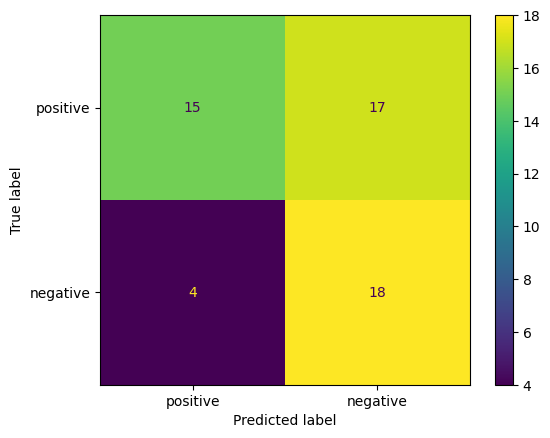

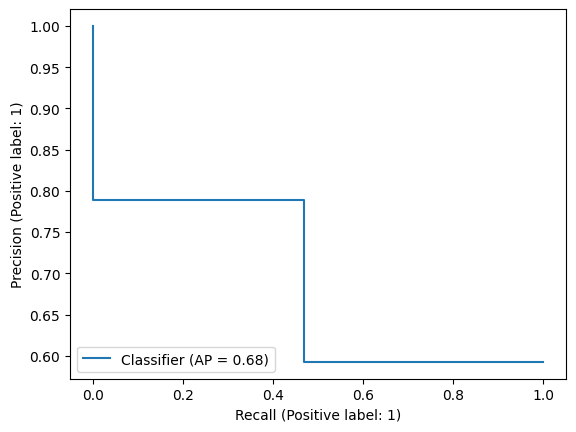

In [34]:
# use the parameters of the best classifier from the gridsearch and refit on data in CV manner 
import copy
# we should not change the gs instance
hits, y_pred = plot_report(copy.deepcopy(gs.best_estimator_), x_train, y_train, label=gs.best_params_,cv=5)
plt.show()

len train: 54
len test: 71
Pipeline(steps=[('scaler', None),
                ('clf',
                 SVC(C=20, class_weight='balanced', degree=2, gamma=0.1,
                     kernel='sigmoid'))])
{'clf': SVC(C=20, class_weight='balanced', degree=2, gamma=0.1, kernel='sigmoid'), 'clf__C': 20, 'clf__class_weight': 'balanced', 'clf__degree': 2, 'clf__gamma': 0.1, 'clf__kernel': 'sigmoid', 'scaler': None}
train f1: 0.5172413793103449  acc: 0.484375  sens: 0.46875  spec: 0.5
test f1: 0.3728813559322034  acc: 0.5509259259259259  sens: 0.25  spec: 0.8518518518518519


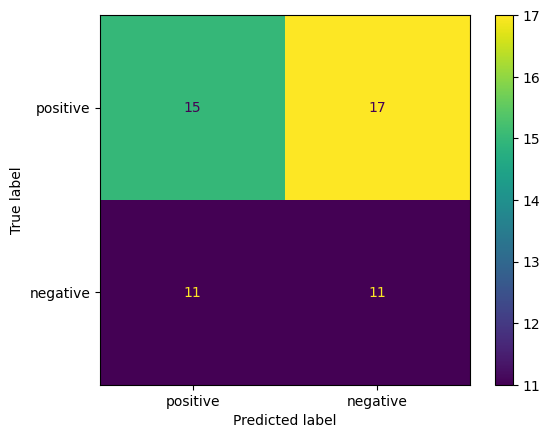

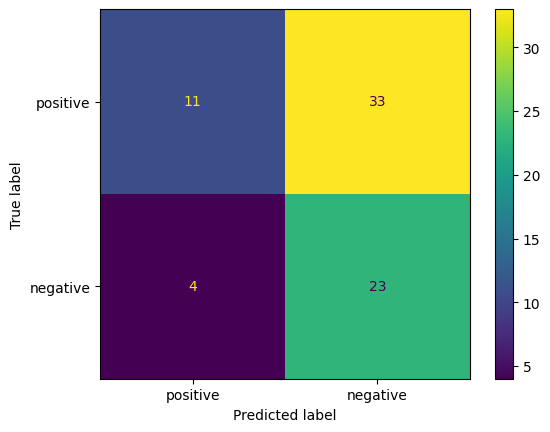

In [35]:
# the gs instance is refit on all trainings files with the refit parameter according to the balance accuracy
# now we can use the gs instance as estimator
pred_train = gs.predict(x_train)
pred_test = gs.predict(x_test)
true_train = pred_train==y_train
true_test = pred_test==y_test
print('len train:',len(pred_train))
print('len test:', len(pred_test))

from src.utils.Evaluation import my_sens, my_spec, bacc_m
from sklearn.metrics import balanced_accuracy_score, f1_score
spec_train = my_spec(y_train, pred_train)
sens_train = my_sens(y_train, pred_train)
acc_train = balanced_accuracy_score(y_train, pred_train)
spec_test = my_spec(y_test, pred_test)
sens_test = my_sens(y_test, pred_test)
acc_test = balanced_accuracy_score(y_test, pred_test)
f1_train = f1_score(y_train,pred_train)
f1_test = f1_score(y_test,pred_test)

print(gs.best_estimator_)
print(gs.best_params_)
print('train f1:',f1_train, ' acc:', acc_train, ' sens:',sens_train, ' spec:',spec_train)
print('test f1:',f1_test, ' acc:', acc_test, ' sens:',sens_test,' spec:',spec_test)

# visualise train and test confusion matrix
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix, ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay.from_predictions(y_train, pred_train, labels=[1, 0], display_labels=['positive', 'negative'],
                                                   colorbar=True)
disp = ConfusionMatrixDisplay.from_predictions(y_test, pred_test, labels=[1, 0], display_labels=['positive', 'negative'],
                                                   colorbar=True)
plt.show()

(123, 16)
********** Logistic Regression **********
[0.46666667 0.66666667 0.8        0.64285714 0.8       ]
Balanced accuracy: 0.62 (+/- 0.08) [Logistic Regression]
Sensitivity: 0.68 (+/- 0.12) [Logistic Regression]
Specifity: 0.57 (+/- 0.13) [Logistic Regression]
********** Random Forest **********
[0.73333333 0.66666667 0.8        0.85714286 0.86666667]
Balanced accuracy: 0.63 (+/- 0.07) [Random Forest]
Sensitivity: 0.78 (+/- 0.08) [Random Forest]
Specifity: 0.47 (+/- 0.12) [Random Forest]
********** Naive Bayes **********
[0.46666667 0.66666667 0.73333333 0.71428571 0.86666667]
Balanced accuracy: 0.71 (+/- 0.09) [Naive Bayes]
Sensitivity: 0.69 (+/- 0.13) [Naive Bayes]
Specifity: 0.73 (+/- 0.13) [Naive Bayes]
********** Scaled DecissionTree **********
[0.66666667 0.53333333 0.66666667 0.78571429 0.86666667]
Balanced accuracy: 0.66 (+/- 0.08) [Scaled DecissionTree]
Sensitivity: 0.70 (+/- 0.11) [Scaled DecissionTree]
Specifity: 0.61 (+/- 0.15) [Scaled DecissionTree]
********** KNN ***

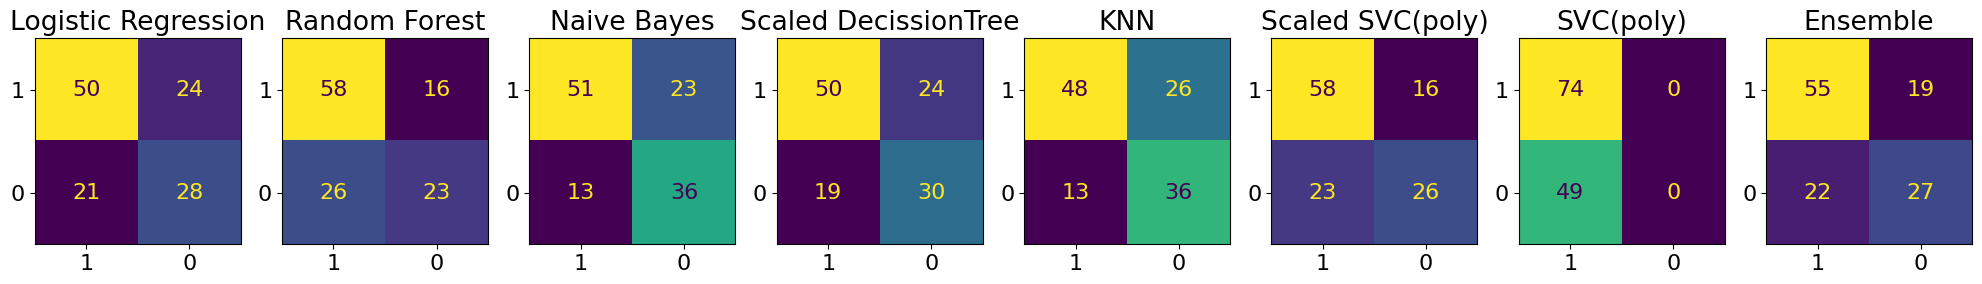

In [22]:
# Peak radial strain per patient or sliced phase strain
x = np.stack(df_merged.sort_values(['pat']).groupby(['pat','aha'])['circ_strain'].apply(lambda x: np.min(list(x))).values).astype(np.float32).reshape((y.shape[0],16))
#x = np.max(x, axis=1)[:,None]
print(x.shape)
x = np.nan_to_num(x)
cross_validate_f1(x,y)

(57, 2)
********** Logistic Regression **********
[0.71428571 0.42857143 0.5        0.66666667 0.57142857]
F1: 0.58 (+/- 0.09) [Logistic Regression]
Recall: 0.58 (+/- 0.10) [Logistic Regression]
Accuracy: 0.52 (+/- 0.10) [Logistic Regression]
********** Random Forest **********
[0.71428571 0.42857143 0.5        0.66666667 0.85714286]
F1: 0.59 (+/- 0.09) [Random Forest]
Recall: 0.63 (+/- 0.15) [Random Forest]
Accuracy: 0.48 (+/- 0.11) [Random Forest]
********** naive Bayes **********
[1.         0.71428571 1.         0.66666667 0.71428571]
F1: 0.68 (+/- 0.06) [naive Bayes]
Recall: 0.82 (+/- 0.15) [naive Bayes]
Accuracy: 0.51 (+/- 0.06) [naive Bayes]
********** scaled DecissionTree **********
[0.57142857 0.28571429 0.5        0.66666667 0.71428571]
F1: 0.56 (+/- 0.11) [scaled DecissionTree]
Recall: 0.55 (+/- 0.15) [scaled DecissionTree]
Accuracy: 0.52 (+/- 0.05) [scaled DecissionTree]
********** KNN **********
[0.57142857 0.28571429 0.         0.66666667 0.14285714]
F1: 0.39 (+/- 0.25) [

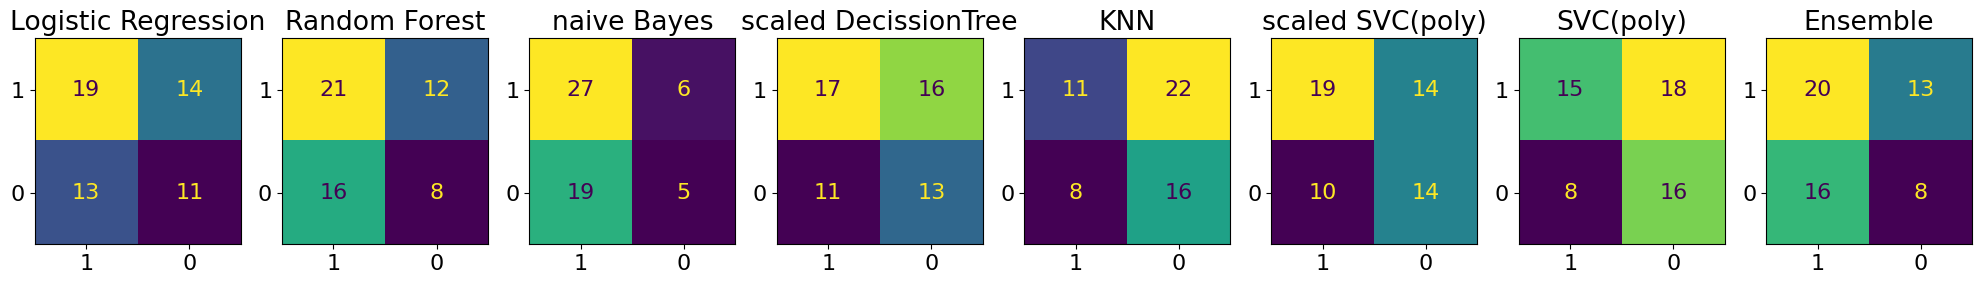

In [24]:
# Peak radial and circ strain per patient
x = np.stack(df_merged.sort_values(['pat']).groupby(['pat','aha'])['radial_strain'].apply(lambda x: np.mean(list(x))).values).astype(np.float32).reshape((57,16))
x = np.max(x, axis=1)
x2 = np.stack(df_merged.sort_values(['pat']).groupby(['pat','aha'])['circ_strain'].apply(lambda x: np.mean(list(x))).values).astype(np.float32).reshape((57,16))
x2 = np.min(x2, axis=1)
x = np.stack([x,x2], axis=1)
print(x.shape)
x = np.nan_to_num(x)
cross_validate_f1(x,y)

In [130]:
# Peak radial strain per segment
x = np.stack(df_merged.sort_values(['pat']).groupby(['pat','aha'])['radial_strain'].apply(lambda x: max(list(x))).values).astype(np.float32).reshape((57,16))
print(x.shape)
x = np.nan_to_num(x)


(57, 16)


(57, 32)
********** Logistic Regression **********
[0.42857143 0.71428571 1.         0.33333333 1.        ]
F1: 0.70 (+/- 0.24) [Logistic Regression]
Recall: 0.70 (+/- 0.28) [Logistic Regression]
Accuracy: 0.68 (+/- 0.24) [Logistic Regression]
********** Random Forest **********
[0.71428571 0.71428571 0.5        0.5        0.71428571]
F1: 0.62 (+/- 0.12) [Random Forest]
Recall: 0.63 (+/- 0.10) [Random Forest]
Accuracy: 0.53 (+/- 0.17) [Random Forest]
********** naive Bayes **********
[0.57142857 0.71428571 0.5        0.66666667 0.71428571]
F1: 0.66 (+/- 0.08) [naive Bayes]
Recall: 0.63 (+/- 0.08) [naive Bayes]
Accuracy: 0.61 (+/- 0.12) [naive Bayes]
********** scaled DecissionTree **********
[0.57142857 0.42857143 0.33333333 0.5        0.57142857]
F1: 0.51 (+/- 0.10) [scaled DecissionTree]
Recall: 0.48 (+/- 0.09) [scaled DecissionTree]
Accuracy: 0.48 (+/- 0.11) [scaled DecissionTree]
********** KNN **********
[0.42857143 0.85714286 0.66666667 0.66666667 0.71428571]
F1: 0.73 (+/- 0.14) 

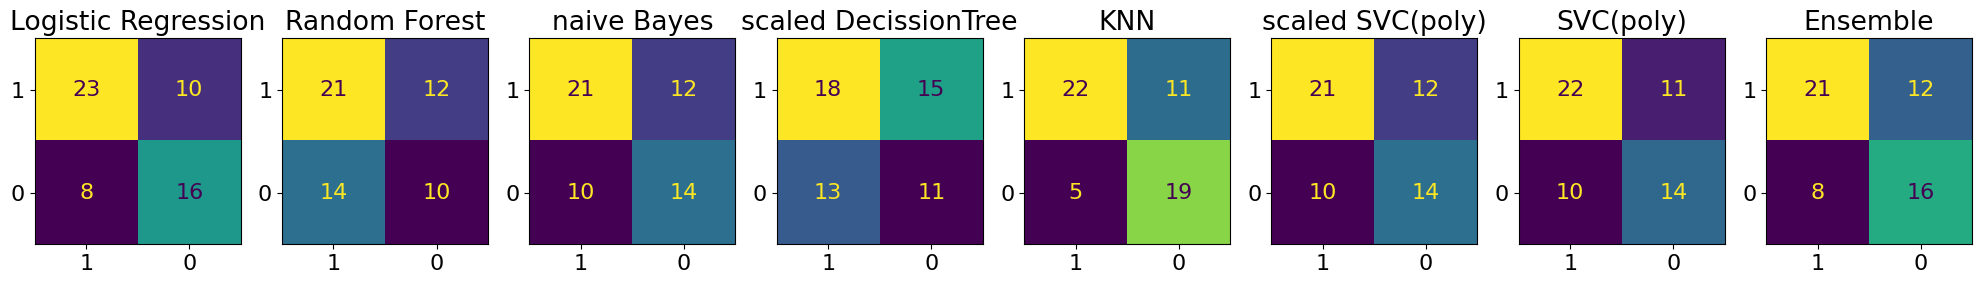

In [61]:
# Peak radial and circ strain per segment
x = np.stack(df_merged.sort_values(['pat']).groupby(['pat','aha'])['radial_strain'].apply(lambda x: max(list(x))).values).astype(np.float32).reshape((57,16))
x2 = np.stack(df_merged.sort_values(['pat']).groupby(['pat','aha'])['circ_strain'].apply(lambda x: min(list(x))).values).astype(np.float32).reshape((57,16))
x = np.concatenate([x,x2], axis=1)
print(x.shape)
x = np.nan_to_num(x)
cross_validate_f1(x,y)

In [106]:
# radial strain per segment and frame 16 x 30
x = np.stack(df_merged.sort_values(['pat']).groupby(['pat'])['radial_strain'].apply(list).values).astype(np.float32) # 57 patient a 480 features (16 segments x 30 frames)
print(x.shape)
x = np.nan_to_num(x)

(57, 480)


(57, 160)
********** Logistic Regression **********
[0.42857143 0.14285714 0.5        0.83333333 0.57142857]
F1: 0.47 (+/- 0.14) [Logistic Regression]
Recall: 0.50 (+/- 0.22) [Logistic Regression]
Accuracy: 0.41 (+/- 0.10) [Logistic Regression]
********** Random Forest **********
[0.57142857 0.85714286 1.         0.83333333 0.71428571]
F1: 0.69 (+/- 0.11) [Random Forest]
Recall: 0.80 (+/- 0.14) [Random Forest]
Accuracy: 0.54 (+/- 0.16) [Random Forest]
********** naive Bayes **********
[0.28571429 0.71428571 0.5        0.66666667 0.57142857]
F1: 0.55 (+/- 0.15) [naive Bayes]
Recall: 0.55 (+/- 0.15) [naive Bayes]
Accuracy: 0.49 (+/- 0.19) [naive Bayes]
********** scaled DecissionTree **********
[0.57142857 0.71428571 0.5        0.5        0.57142857]
F1: 0.58 (+/- 0.09) [scaled DecissionTree]
Recall: 0.57 (+/- 0.08) [scaled DecissionTree]
Accuracy: 0.52 (+/- 0.11) [scaled DecissionTree]
********** KNN **********
[0.42857143 0.42857143 0.66666667 0.5        0.57142857]
F1: 0.55 (+/- 0.08)

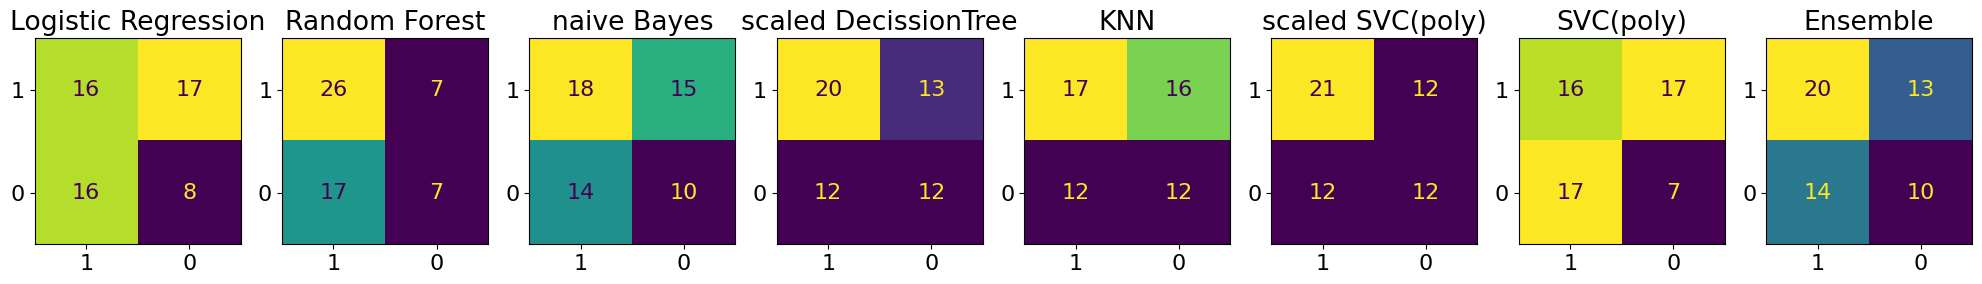

In [62]:
# radial and circ strain per segment and frame 16 x time x 2
x = np.stack(df_merged.sort_values(['pat']).groupby(['pat'])['radial_strain'].apply(list).values).astype(np.float32) # 57 patient a 480 features (16 segments x 30 frames)
x2 = np.stack(df_merged.sort_values(['pat']).groupby(['pat'])['circ_strain'].apply(list).values).astype(np.float32) # 57 patient a 480 features (16 segments x 30 frames)
x = np.concatenate([x,x2], axis=1)
print(x.shape)
x = np.nan_to_num(x)
cross_validate_f1(x,y)

********** Logistic Regression **********
[0.42857143 0.57142857 0.83333333 0.66666667 0.57142857]
F1: 0.62 (+/- 0.10) [Logistic Regression]
Recall: 0.61 (+/- 0.13) [Logistic Regression]
Accuracy: 0.56 (+/- 0.11) [Logistic Regression]
********** Random Forest **********
[0.57142857 0.42857143 0.66666667 0.66666667 0.71428571]
F1: 0.61 (+/- 0.10) [Random Forest]
Recall: 0.61 (+/- 0.10) [Random Forest]
Accuracy: 0.54 (+/- 0.12) [Random Forest]
********** naive Bayes **********
[1.         0.71428571 1.         0.66666667 0.85714286]
F1: 0.67 (+/- 0.06) [naive Bayes]
Recall: 0.85 (+/- 0.14) [naive Bayes]
Accuracy: 0.46 (+/- 0.03) [naive Bayes]
********** scaled DecissionTree **********
[0.57142857 0.57142857 0.5        0.33333333 0.28571429]
F1: 0.50 (+/- 0.13) [scaled DecissionTree]
Recall: 0.45 (+/- 0.12) [scaled DecissionTree]
Accuracy: 0.49 (+/- 0.14) [scaled DecissionTree]
********** KNN **********
[0.57142857 0.42857143 0.33333333 0.33333333 0.28571429]
F1: 0.49 (+/- 0.09) [KNN]
Rec

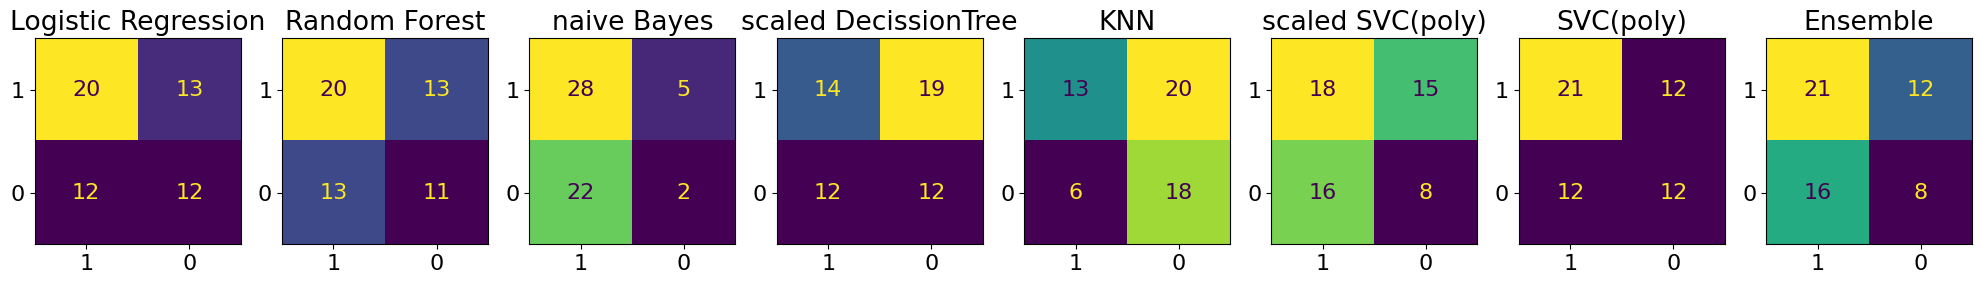

In [246]:
cross_validate_f1(x,y)